<a href="https://colab.research.google.com/github/sandra-olea/pgy_proyecto1/blob/master/CMF_Fase1_Clasificacion_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fase 1 - CMF Reclamos: Canonizacion, Clasificacion y Preparacion para AHP/Asignacion

Este notebook implementa el pipeline de Fase 1 con el nuevo esquema de datos:
- Carga del CSV (nuevo formulario)
- Canonizacion -> construccion del campo `texto` y etiquetas `mercado`, `producto`, `materia`
- Split temporal train/test
- Compactacion de clases raras (producto y materia)
- Entrenamiento RAM-friendly por target (con modo rapido para materia)
- Artefactos guardados para uso posterior (Fase 2: AHP/Asignacion)

Archivo detectado automaticamente:
`/mnt/data/reclamosNuevaClasificación21102025_2.csv`


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ⬇️ Instalación de dependencias
!pip -q install pandas numpy scikit-learn joblib unidecode openpyxl

In [ ]:
import os, json, re, time, warnings
import pandas as pd
import numpy as np
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, f1_score
from joblib import dump
# --- Comprobar dónde estás y qué archivos hay ---
import os, glob, pandas as pd


warnings.filterwarnings("ignore")

## 1) Parametros y utilidades
Seteo de constantes y funciones auxiliares de limpieza/parsing.

In [ ]:

# --- Parametros generales ---
TEST_SIZE          = 0.20         # 80/20 temporal
MIN_COUNT_PRODUCTO = 100           # compactacion por clase (ajusta segun soporte)
MIN_COUNT_MATERIA  = 120
MAX_CHARS          = 3000         # recorte de texto
RANDOM_STATE       = 13
MONTHS_WINDOW      = 18           # si quieres filtrar solo ultimos N meses

DATA_PATH = r"/content/drive/MyDrive/Personal/Tesis/Programacion/reclamosNuevaClasificación21102025_2.csv"
ARTIFACTS_DIR = "artifacts"



# Utilidades de limpieza / parsing
def clean_text(s):
    """Normaliza: str, minusculas, sin tildes, espacios colapsados."""
    if pd.isna(s): return ""
    s = unidecode(str(s).lower()).strip()
    return re.sub(r"\s+", " ", s)

DELIMS = re.compile(r"\s*[/>\-:|]\s*")
def parse_clasificacion(raw):
    """
    Extrae (entidad, producto, materia) desde CLASIFICACION cuando viene con separadores.
    Acepta patrones: 'Banco/Credito/Morosidad', 'Seguro - Auto - Siniestro', etc.
    """
    s = clean_text(raw)
    if not s: return (None, None, None)
    parts = [p for p in DELIMS.split(s) if p]
    ent = parts[0] if len(parts) >= 1 else None
    prod = parts[1] if len(parts) >= 2 else None
    mat  = parts[2] if len(parts) >= 3 else (parts[-1] if len(parts) >= 1 else None)
    return (ent, prod, mat)

def map_mercado_from_proceso(val):
    s = clean_text(val)
    if "banco" in s:   return "Banco"
    if "seguro" in s:  return "Seguro"
    if "valor" in s or "valore" in s: return "Valores"
    return None

def ensure_datetime(s):
    return pd.to_datetime(s, errors="coerce")

def cutoff_months_ago(months=18):
    today = pd.Timestamp.today()
    return (today.normalize() - pd.DateOffset(months=months))

def build_text(df):
    """
    Construye 'texto' desde columnas informativas del nuevo esquema:
      - DESCRIPCION_CIUDADANO, CASO_NOMBRE_CASO, PETICION_CIUDADANO, PROBLEMA_CIUDADANO
      - (Opcional) NOMBRE_ENTIDAD, PROCESO -> aportan senal para producto
    """
    cols = ["DESCRIPCION_CIUDADANO","CASO_NOMBRE_CASO","PETICION_CIUDADANO","PROBLEMA_CIUDADANO","NOMBRE_ENTIDAD","PROCESO"]
    present = [c for c in cols if c in df.columns]
    tmp = df[present].copy()
    for c in present: tmp[c] = tmp[c].map(clean_text)
    texto = tmp.fillna("").agg(" ".join, axis=1).str.replace(r"\s+", " ", regex=True).str.strip()
    return texto.str.slice(stop=MAX_CHARS)


## 2) Carga de datos (CSV)
Lectura robusta del archivo (intenta UTF-8 y Latin-1). Conversion de fechas clave.

In [ ]:



# Intento de lectura robusta (UTF-8 -> Latin-1)
try:
    raw = pd.read_csv(DATA_PATH, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    raw = pd.read_csv(DATA_PATH, sep=",", encoding="latin-1")

print("Filas, columnas:", raw.shape)
print("Columnas:", list(raw.columns)[:25])
raw.head(3)


Filas, columnas: (30729, 23)
Columnas: ['CASO_ID', 'PROCESO', 'ID_PROCESO', 'FECHA_INGRESO', 'CASO_FECHA_TERMINO', 'FECHA_INGRESO_ANIOMES', 'FECHA_TERMINO_ANIOMES', 'CANTIDAD_DIAS_TERMINO', 'CANTIDAD_DIAS_TRANSCURRIDOS', 'CASO_NOMBRE_CASO', 'ESTADO_CASO', 'ANNIO_TERMINO', 'MES_TERMINO', 'ASIGNADO', 'NOMBRE_ENTIDAD', 'ACOGE', 'DESCRIPCION_CIUDADANO', 'PETICION_CIUDADANO', 'PRODUCTO_CIUDADANO', 'ETIQUETA', 'CLASIFICACION', 'ESTADO_TERMINO', 'PROBLEMA_CIUDADANO']


CASO_ID                                  PROCESO  ID_PROCESO FECHA_INGRESO  \
0  3192430  Reclamos Bancos y Entidades Financieras         666      17/10/25   
1  3192967                         Reclamo Seguros          129      17/10/25   
2  3192423  Reclamos Bancos y Entidades Financieras         666      17/10/25   

  CASO_FECHA_TERMINO  FECHA_INGRESO_ANIOMES  FECHA_TERMINO_ANIOMES  \
0                NaN                 202510                    NaN   
1                NaN                 202510                    NaN   
2                NaN                 202510                    NaN   

   CANTIDAD_DIAS_TERMINO  CANTIDAD_DIAS_TRANSCURRIDOS  \
0                    NaN                          2.0   
1                    NaN                          2.0   
2                    NaN                          2.0   

                                    CASO_NOMBRE_CASO  ...  \
0  2025/10/17 3192430 WEB Patricio Augusto Valle ...  ...   
1  2025/10/17 3192967 WEB Roxana Leticia Oyarzo Ruiz  ...   
2  2025/10/17 3192423 WEB David Angel Pincheira R...  ...   

                   ASIGNADO       NOMBRE_ENTIDAD  ACOGE  \
0  ANDRÉS GARCÍA D. y otros       BANCO DE CHILE    NaN   
1   MICHEL LORCA V. y otros     HDI SEGUROS S.A.    NaN   
2  ANDRÉS GARCÍA D. y otros  TENPO PAYMENTS S.A.    NaN   

                               DESCRIPCION_CIUDADANO  \
0            cierre de cta cte , sin motivo alguno,    
1  VENGO A COMENTAR QUE tengo un seguro hogar est...   
2  Buen dia, he hecho 2 reclamos a Tenpo por un r...   

                                  PETICION_CIUDADANO  \
0  se reclamo el 26 de agosto 2025. aun sin respu...   
1  necesito la reapertura del caso y que puedan l...   
2  El comercio (llamado SegPay) efectivamente gen...   

                                  PRODUCTO_CIUDADANO ETIQUETA  \
0  CUENTA CORRIENTE (APLICA PARA MONEDA NACIONAL ...      NaN   
1                                      MUTLIRIESGOS       NaN   
2                     TARJETA DE CRÉDITO NO BANCARIA      NaN   

                                       CLASIFICACION ESTADO_TERMINO  \
0  BANCO/CUENTA CORRIENTE (APLICA PARA MONEDA NAC...            NaN   
1                               CSGEN/MUTLIRIESGOS /            NaN   
2              TCEEM/TARJETA DE CRÉDITO NO BANCARIA/            NaN   

                          PROBLEMA_CIUDADANO  
0                              OTRO PROBLEMA  
1  ME RECHAZARON INDEBIDAMENTE EL SINIESTRO   
2                              OTRO PROBLEMA  

[3 rows x 23 columns]

## 3) (Opcional) Filtrado a ultimos N meses
Limita a una ventana temporal (por defecto 18 meses).

In [ ]:

df = raw.copy()

# Normaliza y calcula fechas relevantes
for col in ["FECHA_INGRESO","CASO_FECHA_TERMINO","FECHA_INGRESO_ANIOMES","FECHA_TERMINO_ANIOMES"]:
    if col in df.columns:
        df[col] = ensure_datetime(df[col])

# Aplica filtro si lo deseas (activar/desactivar con el flag):
APLICAR_FILTRO_ULTIMOS_MESES = True
if APLICAR_FILTRO_ULTIMOS_MESES and "FECHA_INGRESO" in df.columns:
    cut = cutoff_months_ago(MONTHS_WINDOW)
    before = len(df)
    df = df[df["FECHA_INGRESO"] >= cut].copy()
    print(f"Filtrado ultimos {MONTHS_WINDOW} meses -> {before} -> {len(df)} filas")
else:
    print("Sin filtro temporal (usa todo el universo).")

df.head(3)


Filtrado ultimos 18 meses -> 30729 -> 30729 filas


CASO_ID                                  PROCESO  ID_PROCESO FECHA_INGRESO  \
0  3192430  Reclamos Bancos y Entidades Financieras         666    2025-10-17   
1  3192967                         Reclamo Seguros          129    2025-10-17   
2  3192423  Reclamos Bancos y Entidades Financieras         666    2025-10-17   

  CASO_FECHA_TERMINO         FECHA_INGRESO_ANIOMES FECHA_TERMINO_ANIOMES  \
0                NaT 1970-01-01 00:00:00.000202510                   NaT   
1                NaT 1970-01-01 00:00:00.000202510                   NaT   
2                NaT 1970-01-01 00:00:00.000202510                   NaT   

   CANTIDAD_DIAS_TERMINO  CANTIDAD_DIAS_TRANSCURRIDOS  \
0                    NaN                          2.0   
1                    NaN                          2.0   
2                    NaN                          2.0   

                                    CASO_NOMBRE_CASO  ...  \
0  2025/10/17 3192430 WEB Patricio Augusto Valle ...  ...   
1  2025/10/17 3192967 WEB Roxana Leticia Oyarzo Ruiz  ...   
2  2025/10/17 3192423 WEB David Angel Pincheira R...  ...   

                   ASIGNADO       NOMBRE_ENTIDAD  ACOGE  \
0  ANDRÉS GARCÍA D. y otros       BANCO DE CHILE    NaN   
1   MICHEL LORCA V. y otros     HDI SEGUROS S.A.    NaN   
2  ANDRÉS GARCÍA D. y otros  TENPO PAYMENTS S.A.    NaN   

                               DESCRIPCION_CIUDADANO  \
0            cierre de cta cte , sin motivo alguno,    
1  VENGO A COMENTAR QUE tengo un seguro hogar est...   
2  Buen dia, he hecho 2 reclamos a Tenpo por un r...   

                                  PETICION_CIUDADANO  \
0  se reclamo el 26 de agosto 2025. aun sin respu...   
1  necesito la reapertura del caso y que puedan l...   
2  El comercio (llamado SegPay) efectivamente gen...   

                                  PRODUCTO_CIUDADANO ETIQUETA  \
0  CUENTA CORRIENTE (APLICA PARA MONEDA NACIONAL ...      NaN   
1                                      MUTLIRIESGOS       NaN   
2                     TARJETA DE CRÉDITO NO BANCARIA      NaN   

                                       CLASIFICACION ESTADO_TERMINO  \
0  BANCO/CUENTA CORRIENTE (APLICA PARA MONEDA NAC...            NaN   
1                               CSGEN/MUTLIRIESGOS /            NaN   
2              TCEEM/TARJETA DE CRÉDITO NO BANCARIA/            NaN   

                          PROBLEMA_CIUDADANO  
0                              OTRO PROBLEMA  
1  ME RECHAZARON INDEBIDAMENTE EL SINIESTRO   
2                              OTRO PROBLEMA  

[3 rows x 23 columns]

## 4) Canonizacion v2
Construccion de `texto` y etiquetas `y_mercado`, `y_producto`, `y_materia` a partir del nuevo esquema.

In [ ]:

def to_canon_v2(df):
    cdf = df.copy()

    # ID
    if "CASO_ID" in cdf.columns:
        cdf["id"] = cdf["CASO_ID"].astype(str)
    elif "caso_id" in cdf.columns:
        cdf["id"] = cdf["caso_id"].astype(str)
    else:
        cdf["id"] = cdf.index.astype(str)

    # Texto unificado
    cdf["texto"] = build_text(cdf)

    # Mercado desde PROCESO
    cdf["y_mercado"] = cdf.get("PROCESO", pd.Series(dtype=str)).map(map_mercado_from_proceso)

    # Parser de CLASIFICACION (analista)
    ent_col, prod_col, mat_col = None, None, None
    if "CLASIFICACION" in cdf.columns:
        parsed = cdf["CLASIFICACION"].map(parse_clasificacion)
        cdf[["_ent", "_prod", "_mat"]] = pd.DataFrame(parsed.tolist(), index=cdf.index)
        ent_col, prod_col, mat_col = "_ent", "_prod", "_mat"

    # Producto (regla)
    def producto_rule(row):
        mercado = row.get("y_mercado")
        pc      = clean_text(row.get("PRODUCTO_CIUDADANO", ""))
        p_cls   = clean_text(row.get(prod_col, "")) if prod_col in row else ""
        if mercado == "Banco":
            return pc if pc else (p_cls if p_cls else None)
        return p_cls if p_cls else None

    cdf["y_producto"] = cdf.apply(producto_rule, axis=1)

    # Materia desde CLASIFICACION (analista) si existe
    cdf["y_materia"] = cdf.get(mat_col, pd.Series(dtype=str))

    # Fecha canonica
    if "FECHA_INGRESO" in cdf.columns:
        cdf["fecha_ingreso"] = ensure_datetime(cdf["FECHA_INGRESO"])
    else:
        cdf["fecha_ingreso"] = pd.NaT

    # Limpieza final de etiquetas
    for col in ["y_mercado","y_producto","y_materia"]:
        if col in cdf.columns:
            cdf[col] = cdf[col].map(lambda x: clean_text(x) if pd.notna(x) else None)

    # Extras utiles
    keep_extras = [c for c in ["ESTADO_CASO","ESTADO_TERMINO","ACOGE","ASIGNADO","NOMBRE_ENTIDAD","ETIQUETA","PROBLEMA_CIUDADANO","ID_PROCESO"] if c in cdf.columns]

    keep = ["id","fecha_ingreso","texto","y_mercado","y_producto","y_materia","CLASIFICACION","PRODUCTO_CIUDADANO","PROCESO"]
    keep = [c for c in keep if c in cdf.columns] + keep_extras

    out = cdf[keep].copy()
    return out

canon = to_canon_v2(df)
print("canon shape:", canon.shape)
canon.head(3)


canon shape: (30729, 17)


id fecha_ingreso                                              texto  \
0  3192430    2025-10-17  cierre de cta cte , sin motivo alguno, 2025/10...   
1  3192967    2025-10-17  vengo a comentar que tengo un seguro hogar est...   
2  3192423    2025-10-17  buen dia, he hecho 2 reclamos a tenpo por un r...   

  y_mercado                                         y_producto  \
0     banco  cuenta corriente (aplica para moneda nacional ...   
1    seguro                                       mutliriesgos   
2     banco                     tarjeta de credito no bancaria   

                                           y_materia  \
0  cuenta corriente (aplica para moneda nacional ...   
1                                       mutliriesgos   
2                     tarjeta de credito no bancaria   

                                       CLASIFICACION  \
0  BANCO/CUENTA CORRIENTE (APLICA PARA MONEDA NAC...   
1                               CSGEN/MUTLIRIESGOS /   
2              TCEEM/TARJETA DE CRÉDITO NO BANCARIA/   

                                  PRODUCTO_CIUDADANO  \
0  CUENTA CORRIENTE (APLICA PARA MONEDA NACIONAL ...   
1                                      MUTLIRIESGOS    
2                     TARJETA DE CRÉDITO NO BANCARIA   

                                   PROCESO ESTADO_CASO ESTADO_TERMINO ACOGE  \
0  Reclamos Bancos y Entidades Financieras        OPEN            NaN   NaN   
1                         Reclamo Seguros         OPEN            NaN   NaN   
2  Reclamos Bancos y Entidades Financieras        OPEN            NaN   NaN   

                   ASIGNADO       NOMBRE_ENTIDAD ETIQUETA  \
0  ANDRÉS GARCÍA D. y otros       BANCO DE CHILE      NaN   
1   MICHEL LORCA V. y otros     HDI SEGUROS S.A.      NaN   
2  ANDRÉS GARCÍA D. y otros  TENPO PAYMENTS S.A.      NaN   

                          PROBLEMA_CIUDADANO  ID_PROCESO  
0                              OTRO PROBLEMA         666  
1  ME RECHAZARON INDEBIDAMENTE EL SINIESTRO          129  
2                              OTRO PROBLEMA         666

## 5) Split temporal y limpieza minima
Ordena por `fecha_ingreso`, separa 80/20 y exige calidad minima del texto/etiquetas.

In [ ]:

# Orden temporal
canon["fecha_ingreso"] = pd.to_datetime(canon["fecha_ingreso"], errors="coerce")
canon = canon.sort_values("fecha_ingreso").reset_index(drop=True)

# Congelar targets
canon["mercado"]  = canon["y_mercado"]
canon["producto"] = canon["y_producto"]
canon["materia"]  = canon["y_materia"]

# Limpieza minima
canon["texto"] = canon["texto"].fillna("").astype(str).str.slice(stop=MAX_CHARS)

# Split 80/20
cut = int(len(canon) * (1 - TEST_SIZE))
train_df = canon.iloc[:cut].copy()
test_df  = canon.iloc[cut:].copy()

def drop_bad(df):
    df = df.copy()
    df = df[df["texto"].str.len() >= 20]
    for t in ["mercado","producto","materia"]:
        df = df[df[t].notna() & (df[t].astype(str).str.len() > 0) & (df[t].astype(str).str.lower() != "none")]
    return df

train_df = drop_bad(train_df)
test_df  = drop_bad(test_df)

print("Train/Test:", train_df.shape, test_df.shape)
train_df[["mercado","producto","materia"]].nunique()


Train/Test: (24549, 20) (6146, 20)


mercado       3
producto     49
materia     138
dtype: int64

In [ ]:
# 5.1) Normalización de etiquetas (rellena con tus sinónimos reales)
MAP_PROD = {
    "tc": "tarjeta_credito",
    "tarjeta credito": "tarjeta_credito",
    "t credito": "tarjeta_credito",
    "cta cte": "cuenta_corriente",
    "cuenta cte": "cuenta_corriente",
    # ...
}
MAP_MAT = {
    # ejemplos:
    "cobranza extrajudicial": "cobranza",
    "cobranza- extrajudicial": "cobranza",
    # ...
}

def _norm_label(x, mapping):
    s = (str(x) if x is not None else "").strip().lower()
    return mapping.get(s, s)

for _df in (train_df, test_df):
    _df["producto"] = _df["producto"].map(lambda x: _norm_label(x, MAP_PROD))
    _df["materia"]  = _df["materia"].map(lambda x: _norm_label(x, MAP_MAT))


## 6) Compactacion de clases raras y cap por clase (materia)
Reduce cola de clases raras y acelera entrenamiento.

In [ ]:

def compact_rare_classes(df_train, df_test, col, min_count=60, other_label="otros"):
    vc = df_train[col].value_counts()
    rares = set(vc[vc < min_count].index)
    df_train[col] = df_train[col].apply(lambda x: other_label if x in rares else x)
    known = set(df_train[col].unique())
    df_test[col]  = df_test[col].apply(lambda x: x if x in known else other_label)
    return df_train, df_test

train_df, test_df = compact_rare_classes(train_df, test_df, "producto", min_count=MIN_COUNT_PRODUCTO, other_label="otros")
train_df, test_df = compact_rare_classes(train_df, test_df, "materia",  min_count=MIN_COUNT_MATERIA,  other_label="otros")

def cap_per_class(df, col, max_per=2000, random_state=13):
    return (df.groupby(col, group_keys=False)
              .apply(lambda g: g.sample(n=min(len(g), max_per), random_state=random_state))
              .reset_index(drop=True))

train_df = cap_per_class(train_df, "materia", max_per=2000)
train_df[["mercado","producto","materia"]].nunique()


mercado      3
producto    29
materia     31
dtype: int64

In [ ]:
# 6.1) Re-peso de señales para PRODUCTO (duplica PROCESO y NOMBRE_ENTIDAD en el texto)
def boost_for_producto(df):
    extra = (df.get("PROCESO","").astype(str) + " " + df.get("NOMBRE_ENTIDAD","").astype(str)).map(clean_text)
    # duplicamos 'extra' para darle más peso
    return (df["texto"].astype(str) + " " + extra + " " + extra).str.strip()

texto_train_prod = boost_for_producto(train_df)
texto_test_prod  = boost_for_producto(test_df)


## 7) Entrenamiento RAM-friendly por target
TF-IDF por target con config distinta y modo FAST para materia con fallback Hashing+SGD.

In [ ]:

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, classification_report
from joblib import dump
import gc
import time

os.makedirs(ARTIFACTS_DIR, exist_ok=True)

def train_lin_svc(text_train, y_train, text_test, y_test, cfg_word, cfg_char=None, Cs=(0.5,1.0,2.0)):
    t0 = time.time()
    v_w = TfidfVectorizer(**cfg_word)
    Xw_tr = v_w.fit_transform(text_train); Xw_te = v_w.transform(text_test)
    if cfg_char is not None:
        v_c = TfidfVectorizer(**cfg_char)
        Xc_tr = v_c.fit_transform(text_train); Xc_te = v_c.transform(text_test)
        X_tr = hstack([Xw_tr, Xc_tr], format="csr", dtype=np.float32)
        X_te = hstack([Xw_te, Xc_te], format="csr", dtype=np.float32)
    else:
        X_tr, X_te = Xw_tr, Xw_te; v_c = None

    best = (-1, None)
    for C in Cs:
        clf = LinearSVC(class_weight="balanced", dual="auto", C=C)
        clf.fit(X_tr, y_train)
        pred = clf.predict(X_te)
        score = f1_score(y_test, pred, average="macro", zero_division=0.0)
        if score > best[0]:
            best = (score, (C, clf))
    f1best, (Cbest, best_clf) = best
    rep = classification_report(y_test, best_clf.predict(X_te), output_dict=True, zero_division=0.0)
    del X_tr, X_te; gc.collect()
    return best_clf, v_w, v_c, Cbest, float(f1best), rep, time.time()-t0

def train_hash_sgd(text_train, y_train, text_test, y_test, n_features=2**19):
    t0 = time.time()
    hv  = HashingVectorizer(ngram_range=(1,2), alternate_sign=False, n_features=n_features,
                            norm="l2", dtype=np.float32)
    X_tr = hv.transform(text_train); X_te = hv.transform(text_test)
    clf = SGDClassifier(loss="hinge", alpha=1e-5, max_iter=15, tol=1e-3,
                        early_stopping=True, n_iter_no_change=3, class_weight="balanced",
                        random_state=RANDOM_STATE)
    clf.fit(X_tr, y_train)
    pred = clf.predict(X_te)
    f1b  = f1_score(y_test, pred, average="macro", zero_division=0.0)
    rep  = classification_report(y_test, pred, output_dict=True, zero_division=0.0)
    del X_tr, X_te; gc.collect()
    return clf, hv, None, "hashing+SGD", float(f1b), rep, time.time()-t0

CFG_MERCADO = {
    "word": dict(ngram_range=(1,2), min_df=5,  max_df=0.9,  max_features=80_000,
                 dtype=np.float32, sublinear_tf=True),
    "char": None, "Cs": (0.5,1.0,2.0)
}

CFG_PRODUCTO = {
    "word": dict(ngram_range=(1,2), min_df=8, max_df=0.95, max_features=60_000,
                 dtype=np.float32, sublinear_tf=True),
    "char": None,
    "Cs": (0.5, 1.0, 2.0)
}

CFG_MATERIA_FAST = {
    "word": dict(ngram_range=(1,2), min_df=12, max_df=0.95, max_features=60_000,
                 dtype=np.float32, sublinear_tf=True),
    "char": dict(analyzer="char", ngram_range=(3,4), min_df=10, max_df=1.0,
                 max_features=25_000, dtype=np.float32, sublinear_tf=True)
}


macro = {}

# Mercado
print("\n=== Target: mercado ===")
clf, v_w, v_c, Cbest, f1b, rep, secs = train_lin_svc(
    texto_train_prod.values, train_df["mercado"].astype(str).values,
    texto_test_prod.values,  test_df["mercado"].astype(str).values,
    cfg_word=CFG_MERCADO["word"], cfg_char=CFG_MERCADO["char"], Cs=CFG_MERCADO["Cs"]
)
macro["mercado"] = f1b
dump(clf, os.path.join(ARTIFACTS_DIR, "model_mercado.joblib"))
dump(v_w, os.path.join(ARTIFACTS_DIR, "tfidf_word_mercado.joblib"))
with open(os.path.join(ARTIFACTS_DIR, "report_mercado.json"),"w",encoding="utf-8") as f: json.dump(rep, f, ensure_ascii=False, indent=2)
del clf, v_w, v_c; gc.collect()
print(f"  macro-F1={f1b:.3f} | tiempo={secs:.1f}s")

# Producto
print("\n=== Target: producto ===")

clf, v_w, v_c, Cbest, f1b, rep, secs = train_lin_svc(
    texto_train_prod.values, train_df["producto"].astype(str).values,
    texto_test_prod.values,  test_df["producto"].astype(str).values,
    cfg_word=CFG_PRODUCTO["word"], cfg_char=CFG_PRODUCTO["char"], Cs=CFG_PRODUCTO["Cs"]
)
macro["producto"] = f1b
dump(clf, os.path.join(ARTIFACTS_DIR, "model_producto.joblib"))
dump(v_w, os.path.join(ARTIFACTS_DIR, "tfidf_word_producto.joblib"))
if v_c is not None: dump(v_c, os.path.join(ARTIFACTS_DIR, "tfidf_char_producto.joblib"))
with open(os.path.join(ARTIFACTS_DIR, "report_producto.json"),"w",encoding="utf-8") as f: json.dump(rep, f, ensure_ascii=False, indent=2)
del clf, v_w, v_c; gc.collect()
print(f"  macro-F1={f1b:.3f} | tiempo={secs:.1f}s")

# Materia (FAST con fallback hashing)
print("\n=== Target: materia (FAST) ===")
try:
    clf, v_w, v_c, Cbest, f1b, rep, secs = train_lin_svc(
        texto_train_prod.values, train_df["materia"].astype(str).values,
        texto_test_prod.values,  test_df["materia"].astype(str).values,
        cfg_word=CFG_MATERIA_FAST["word"], cfg_char=CFG_MATERIA_FAST["char"], Cs=(0.5,1.0,2.0)
    )
    vect_id = "tfidf"
except MemoryError:
    print("  RAM alta en materia -> Hashing+SGD")
    clf, v_w, v_c, Cbest, f1b, rep, secs = train_hash_sgd(
        texto_train_prod.values, train_df["materia"].astype(str).values,
        texto_test_prod.values,  test_df["materia"].astype(str).values,
        n_features=2**19
    )
    vect_id = "hash"

macro["materia"] = f1b
dump(clf, os.path.join(ARTIFACTS_DIR, "model_materia.joblib"))
if vect_id == "tfidf":
    if v_c is None:
        dump(v_w, os.path.join(ARTIFACTS_DIR, "tfidf_materia.joblib"))
    else:
        dump(v_w, os.path.join(ARTIFACTS_DIR, "tfidf_word_materia.joblib"))
        dump(v_c, os.path.join(ARTIFACTS_DIR, "tfidf_char_materia.joblib"))
elif vect_id == "hash":
    dump(v_w, os.path.join(ARTIFACTS_DIR, "hash_materia.joblib"))

#dump(v_w, os.path.join(ARTIFACTS_DIR, f"{vect_id}_materia.joblib"))
with open(os.path.join(ARTIFACTS_DIR, "report_materia.json"),"w",encoding="utf-8") as f: json.dump(rep, f, ensure_ascii=False, indent=2)
del clf, v_w, v_c; gc.collect()
print(f"  macro-F1={f1b:.3f} | tiempo={secs:.1f}s")

print("\nMacro-F1:", macro)







=== Target: mercado ===
  macro-F1=0.995 | tiempo=33.2s

=== Target: producto ===
  macro-F1=0.718 | tiempo=78.3s

=== Target: materia (FAST) ===
  macro-F1=0.567 | tiempo=426.6s

Macro-F1: {'mercado': 0.9950958274901938, 'producto': 0.7183222733042206, 'materia': 0.567363227377631}


## 7.1) Diagnóstico por target
Reporte rápido en TEST: distribución de predicciones, classification_report y macro-F1.


In [ ]:
from joblib import load
from sklearn.metrics import classification_report, f1_score
from scipy.sparse import hstack
import os, pandas as pd

def per_target_report(df_test, tgt, artifacts_dir=ARTIFACTS_DIR, topn=10):
    """
    Carga el modelo y sus vectorizadores para 'tgt' y evalúa en df_test.
    Soporta:
      - mercado/producto: tfidf_word_* (+ tfidf_char_* si existe)
      - materia: tfidf_materia.joblib o hash_materia.joblib (fallback)
    Imprime distribución de predicciones, classification_report y macro-F1.
    Devuelve (y_true, y_pred).
    """
    # Rutas posibles de artefactos
    model_path = os.path.join(artifacts_dir, f"model_{tgt}.joblib")
    vw_word    = os.path.join(artifacts_dir, f"tfidf_word_{tgt}.joblib")
    vc_char    = os.path.join(artifacts_dir, f"tfidf_char_{tgt}.joblib")
    v_alt_tfidf= os.path.join(artifacts_dir, f"tfidf_{tgt}.joblib")  # p.ej. tfidf_materia.joblib
    v_alt_hash = os.path.join(artifacts_dir, f"hash_{tgt}.joblib")   # p.ej. hash_materia.joblib

    clf = load(model_path)

    # Construye X_test según lo disponible
    X_parts = []
    if os.path.exists(vw_word):  # word TF-IDF (mercado/producto)
        vw = load(vw_word)
        X_parts.append(vw.transform(df_test["texto"]))
        if os.path.exists(vc_char):  # char TF-IDF (producto)
            vc = load(vc_char)
            X_parts.append(vc.transform(df_test["texto"]))
    elif os.path.exists(v_alt_tfidf):  # p.ej. tfidf_materia.joblib
        v = load(v_alt_tfidf)
        X_parts.append(v.transform(df_test["texto"]))
    elif os.path.exists(v_alt_hash):   # p.ej. hash_materia.joblib
        v = load(v_alt_hash)
        X_parts.append(v.transform(df_test["texto"]))
    else:
        raise FileNotFoundError(f"No encontré vectorizador para '{tgt}' en {artifacts_dir}")

    X_te = X_parts[0] if len(X_parts) == 1 else hstack(X_parts, format="csr")

    y_true = df_test[tgt].astype(str).values
    y_pred = clf.predict(X_te)

    # Resumen
    print(pd.Series(y_pred).value_counts().head(topn))
    print(classification_report(y_true, y_pred, zero_division=0.0))
    print("macro-F1:", f1_score(y_true, y_pred, average="macro", zero_division=0.0))
    return y_true, y_pred

# Clona test_df y reemplaza 'texto' por el boosted
df_test_boost = test_df.copy()
df_test_boost["texto"] = texto_test_prod.values  # fuerza alineación por posición

_ = per_target_report(df_test_boost, "producto", artifacts_dir=ARTIFACTS_DIR)

# Ejemplos de uso en TEST:
_ = per_target_report(test_df, "mercado")
_ = per_target_report(test_df, "producto")
#_ = per_target_report(df_test_boost, "producto", artifacts_dir=ARTIFACTS_DIR)

_ = per_target_report(test_df, "materia")


tarjeta de credito                                             833
salud                                                          589
cuenta corriente (aplica para moneda nacional y extranjera)    587
vehiculos motorizados                                          585
cuenta vista/cuenta rut                                        499
credito de consumo/comercial                                   403
asesoria e informacion                                         339
credito hipotecario                                            307
informacion deudores                                           282
calidad de servicio                                            230
Name: count, dtype: int64
                                                             precision    recall  f1-score   support

                                      accidentes personales       0.25      0.03      0.06        29
                                                   acciones       0.84      0.88      0.86        42


## 7.2) Inferencia (cargar artefactos y predecir 3 etiquetas)

In [ ]:
import os
ARTIFACTS_DIR = "artifacts"  # o la ruta que uses
print("cwd:", os.getcwd())
print("existe carpeta artifacts?", os.path.isdir(ARTIFACTS_DIR))
print("contenido artifacts:", os.listdir(ARTIFACTS_DIR) if os.path.isdir(ARTIFACTS_DIR) else "NO EXISTE")
for f in ["model_materia.joblib","tfidf_materia.joblib","hash_materia.joblib"]:
    p = os.path.join(ARTIFACTS_DIR, f)
    print(f, "->", "OK" if os.path.exists(p) else "NO")


cwd: /content
existe carpeta artifacts? True
contenido artifacts: ['tfidf_word_producto.joblib', 'tfidf_char_materia.joblib', 'tfidf_word_mercado.joblib', 'model_producto.joblib', 'model_materia.joblib', 'model_mercado.joblib', 'report_materia.json', 'report_producto.json', 'tfidf_word_materia.joblib', 'report_mercado.json']
model_materia.joblib -> OK
tfidf_materia.joblib -> NO
hash_materia.joblib -> NO


In [ ]:
from joblib import load
from scipy.sparse import hstack
from scipy import sparse

def predict_all(df_in, artifacts_dir=ARTIFACTS_DIR, use_boost_for_producto=False):
    """
    Predice mercado, producto y materia sobre df_in (debe tener columna 'texto').
    Si entrenaste producto con boosting, usa use_boost_for_producto=True para replicarlo.
    """
    df = df_in.copy()
    texts = df["texto"].astype(str)

    # Si quieres replicar el boosting de producto en inferencia:
    if use_boost_for_producto:
        extra = (df.get("PROCESO","").astype(str) + " " + df.get("NOMBRE_ENTIDAD","").astype(str)).map(clean_text)
        texts = (texts + " " + extra + " " + extra).str.strip()

    # --- mercado ---
    m_clf = load(os.path.join(artifacts_dir, "model_mercado.joblib"))
    m_vw  = load(os.path.join(artifacts_dir, "tfidf_word_mercado.joblib"))
    Xm    = m_vw.transform(texts)
    df["pred_mercado"] = m_clf.predict(Xm)

    # --- producto ---
    p_clf = load(os.path.join(artifacts_dir, "model_producto.joblib"))
    p_vw_path = os.path.join(artifacts_dir, "tfidf_word_producto.joblib")
    p_vc_path = os.path.join(artifacts_dir, "tfidf_char_producto.joblib")
    X_parts = [load(p_vw_path).transform(texts)]
    if os.path.exists(p_vc_path):
        X_parts.append(load(p_vc_path).transform(texts))
    Xp = X_parts[0] if len(X_parts) == 1 else hstack(X_parts, format="csr")
    df["pred_producto"] = p_clf.predict(Xp)

   # --- Materia ---
    mat_model = load(os.path.join(artifacts_dir, "model_materia.joblib"))

    p_comb  = os.path.join(artifacts_dir, "tfidf_materia.joblib")
    p_word  = os.path.join(artifacts_dir, "tfidf_word_materia.joblib")
    p_char  = os.path.join(artifacts_dir, "tfidf_char_materia.joblib")
    p_hash  = os.path.join(artifacts_dir, "hash_materia.joblib")

    if os.path.exists(p_comb):
        # Caso 1: vectorizador combinado guardado como tfidf_materia.joblib
        mv = load(p_comb)
        Xm = mv.transform(texts)

    else:
        X_parts = []
        if os.path.exists(p_word):
            vw = load(p_word)
            X_parts.append(vw.transform(texts))
        if os.path.exists(p_char):
            vc = load(p_char)
            X_parts.append(vc.transform(texts))

        if X_parts:
            # Caso 2: existen word y/o char -> apila como en entrenamiento
            Xm = sparse.hstack(X_parts, format="csr")
        elif os.path.exists(p_hash):
            # Caso 3: fallback hash
            mv = load(p_hash)
            Xm = mv.transform(texts)
        else:
            raise FileNotFoundError(
                "No se encontró ningún vectorizador para 'materia' "
                "(faltan tfidf_word_materia.joblib / tfidf_char_materia.joblib / tfidf_materia.joblib / hash_materia.joblib)."
            )

    df["pred_materia"] = mat_model.predict(Xm)

    return df

# Ejemplo de uso con el TEST (si usaste boosting de producto, usa use_boost_for_producto=True):
preds = predict_all(test_df, use_boost_for_producto=True)
preds[["id","pred_mercado","pred_producto","pred_materia"]].head()


id pred_mercado  \
24583  3145247        banco   
24584  3144632       seguro   
24585  3144439        banco   
24586  3143695        banco   
24587  3144942       seguro   

                                           pred_producto  \
24583                                calidad de servicio   
24584                                              salud   
24585  cuenta corriente (aplica para moneda nacional ...   
24586                                              otros   
24587                                              salud   

                                            pred_materia  
24583                                calidad de servicio  
24584                             indemnizacion denegada  
24585  cuenta corriente (aplica para moneda nacional ...  
24586                                              otros  
24587                            siniestro y liquidacion

## 8) Ganchos para AHP y Asignacion (Fase 2)
Stubs para combinar confianza, plazos y riesgo; y enrutar a analistas.

In [ ]:

def compute_ahp_score(row, w_conf=0.5, w_plazo=0.3, w_riesgo=0.2):
    """
    Ejemplo: combinar futuras senales (a definir en Fase 2):
      - w_conf: confianza del modelo (prob/calibracion o margen de SVM)
      - w_plazo: dias transcurridos vs SLA (normalizado)
      - w_riesgo: flags basados en PROBLEMA_CIUDADANO / ETIQUETA
    """
    import numpy as np
    return np.nan

def assign_analyst(row):
    """
    Router simple por mercado/materia/carga. A definir en Fase 2 con DPGD/DTI.
    """
    return None


## 9) Resumen
- Dataset canonico generado con nuevo esquema.
- Split temporal y limpieza aplicados.
- Compactacion de clases raras (producto, materia).
- Entrenamiento por target con artefactos en `./artifacts`.

Listo para conectar con AHP y asignacion en la Fase 2.

# Sección: Evaluación y visualizaciones de la clasificación (Fase 1)

Esta sección añade reportes tabulares y gráficos para cada tarea de clasificación disponible en el entorno (`y_test_*` vs `y_pred_*`). No requiere cambios en el pipeline; detecta variables existentes y genera:
1. Reporte de clasificación (precision, recall, F1, support)
2. Matriz de confusión
3. Barras de soporte y F1 por clase
4. Muestra de errores de clasificación con texto para análisis cualitativo

In [ ]:

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from joblib import load
from scipy.sparse import hstack
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

ARTIFACTS_DIR = "artifacts"
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

def clean_text(s):
    import re, pandas as pd
    from unidecode import unidecode
    if pd.isna(s): return ""
    s = unidecode(str(s).lower()).strip()
    return re.sub(r"\s+", " ", s)

def build_text_boost_producto(df):
    extra = (df.get("PROCESO","").astype(str) + " " + df.get("NOMBRE_ENTIDAD","").astype(str)).map(clean_text)
    return (df["texto"].astype(str) + " " + extra + " " + extra).str.strip()

def ensure_test_frames():
    if "test_df" not in globals():
        raise RuntimeError("No se encontró 'test_df'. Ejecuta el notebook principal primero.")
    req = {"texto","mercado","producto","materia"}
    if not req.issubset(test_df.columns):
        raise RuntimeError(f"Faltan columnas en test_df. Requiere: {req}")
    return test_df

def load_vectorizers_for(target):
    vw_word    = os.path.join(ARTIFACTS_DIR, f"tfidf_word_{target}.joblib")
    vc_char    = os.path.join(ARTIFACTS_DIR, f"tfidf_char_{target}.joblib")
    v_alt_tfidf= os.path.join(ARTIFACTS_DIR, f"tfidf_{target}.joblib")
    v_alt_hash = os.path.join(ARTIFACTS_DIR, f"hash_{target}.joblib")
    parts, used = [], []
    if os.path.exists(vw_word):
        parts.append(load(vw_word)); used.append(Path(vw_word).name)
    if os.path.exists(vc_char):
        parts.append(load(vc_char)); used.append(Path(vc_char).name)
    if not parts and os.path.exists(v_alt_tfidf):
        parts = [load(v_alt_tfidf)]; used = [Path(v_alt_tfidf).name]
    if not parts and os.path.exists(v_alt_hash):
        parts = [load(v_alt_hash)]; used = [Path(v_alt_hash).name]
    if not parts:
        raise FileNotFoundError(f"No hay vectorizadores para '{target}' en {ARTIFACTS_DIR}")
    return parts, used

def vectorize(parts, texts):
    X = parts[0].transform(texts)
    for v in parts[1:]:
        X = hstack([X, v.transform(texts)], format="csr")
    return X

def report_df(y_true, y_pred, titulo):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    df = pd.DataFrame(rep).T
    clases = [ix for ix in df.index if ix not in ("accuracy","macro avg","weighted avg","micro avg")]
    otros  = [ix for ix in df.index if ix in ("accuracy","macro avg","weighted avg","micro avg")]
    ordered = df.loc[clases].sort_values("support", ascending=False)
    df = pd.concat([ordered, df.loc[otros]], axis=0)
    display(df.style.format({"precision":"{:.3f}","recall":"{:.3f}","f1-score":"{:.3f}","support":"{:,.0f}"})
              .set_caption(titulo))
    return df

def plot_confusion(y_true, y_pred, etiquetas=None, titulo="Matriz de confusión"):
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas) if etiquetas is not None else confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation="nearest")
    ax.set_title(titulo); ax.set_xlabel("Predicción"); ax.set_ylabel("Verdadero")
    if etiquetas is None:
        etiquetas = [str(x) for x in sorted(set(list(y_true)+list(y_pred)))]
    ax.set_xticks(range(len(etiquetas))); ax.set_yticks(range(len(etiquetas)))
    ax.set_xticklabels(etiquetas, rotation=45, ha="right"); ax.set_yticklabels(etiquetas)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]}", ha="center", va="center", fontsize=9)
    fig.tight_layout(); plt.show()
    return cm
def plot_confusion(y_true, y_pred, etiquetas=None, titulo="Matriz de confusión"):

    cm_counts = confusion_matrix(y_true, y_pred, labels=etiquetas) if etiquetas is not None else confusion_matrix(y_true, y_pred)
    row_sums = cm_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_pct = (cm_counts / row_sums) * 100.0

    if etiquetas is None:
        etiquetas = [str(x) for x in sorted(set(list(y_true)+list(y_pred)))]

    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm_pct, interpolation="nearest", cmap="Pastel2", vmin=0, vmax=100)
    ax.set_title(titulo)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Verdadero")
    ax.set_xticks(range(len(etiquetas)))
    ax.set_yticks(range(len(etiquetas)))
    ax.set_xticklabels(etiquetas, rotation=45, ha="right")
    ax.set_yticklabels(etiquetas)

    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            ax.text(j, i, f"{cm_pct[i,j]:.1f}%", ha="center", va="center", fontsize=9)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("% dentro de la clase verdadera")
    fig.tight_layout()
    plt.show()
    return cm_pct

def bar_support_f1(crdf, top_n=20, titulo="Soporte y F1 por clase (top N)"):
    df = crdf.copy()
    df = df.loc[[ix for ix in df.index if ix not in ("accuracy","macro avg","weighted avg","micro avg")]]
    df = df.sort_values("support", ascending=False).head(top_n)
    fig, ax = plt.subplots(figsize=(10,6)); ax.bar(range(len(df)), df["support"])
    ax.set_xticks(range(len(df))); ax.set_xticklabels(df.index, rotation=60, ha="right")
    ax.set_ylabel("Soporte (n)"); ax.set_title(titulo); fig.tight_layout(); plt.show()
    fig2, ax2 = plt.subplots(figsize=(10,6)); ax2.bar(range(len(df)), df["f1-score"])
    ax2.set_xticks(range(len(df))); ax2.set_xticklabels(df.index, rotation=60, ha="right")
    ax2.set_ylabel("F1"); ax2.set_ylim(0,1); ax2.set_title("F1 por clase (top N)"); fig2.tight_layout(); plt.show()

def save_errors_csv(df_test, y_true, y_pred, target, n=500):
    import numpy as np, pandas as pd
    mask = (np.array(y_true) != np.array(y_pred))
    df_err = pd.DataFrame({
        "verdadero": np.array(y_true)[mask],
        "predicho":  np.array(y_pred)[mask],
        "texto":     df_test["texto"].astype(str).values[mask]
    })
    out = OUT_DIR / f"errors_{target}.csv"
    df_err.head(n).to_csv(out, index=False, encoding="utf-8")
    print(f"Errores guardados: {out}  (mostrando vista previa)")
    display(df_err.head(min(25, len(df_err))))
    return out, df_err

print("Contenido artifacts:", os.listdir(ARTIFACTS_DIR) if os.path.isdir(ARTIFACTS_DIR) else "NO EXISTE")


Contenido artifacts: ['tfidf_word_producto.joblib', 'tfidf_char_materia.joblib', 'tfidf_word_mercado.joblib', 'model_producto.joblib', 'model_materia.joblib', 'model_mercado.joblib', 'report_materia.json', 'report_producto.json', 'tfidf_word_materia.joblib', 'report_mercado.json']


In [ ]:
# ================================================
# Utilidades para matrices de confusión con MANY-CLASSES
# Pasteles, porcentajes por fila, selección top-K y paginación
# ================================================
import math

def _infer_labels(y_true, y_pred):
    return [str(x) for x in sorted(set(list(y_true)+list(y_pred)))]

def class_support(y_true, etiquetas=None):
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_true)
    idx = {lab:i for i,lab in enumerate(etiquetas)}
    sup = np.zeros(len(etiquetas), dtype=int)
    for y in y_true:
        if str(y) in idx:
            sup[idx[str(y)]] += 1
    return dict(zip(etiquetas, sup))

def topk_by_support(y_true, k=20, etiquetas=None):
    sup = class_support(y_true, etiquetas)
    return [lab for lab,_ in sorted(sup.items(), key=lambda kv: kv[1], reverse=True)[:k]]

def topk_by_error(y_true, y_pred, k=20, etiquetas=None):
    # Selecciona las clases con mayor error absoluto (FN+FP)
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    fn = cm.sum(axis=1) - np.diag(cm)   # falsos negativos por clase verdadera
    fp = cm.sum(axis=0) - np.diag(cm)   # falsos positivos por clase predicha
    err = fn + fp
    order = np.argsort(err)[::-1]
    return [etiquetas[i] for i in order[:k]]

def plot_confusion_percent(y_true, y_pred, etiquetas=None, title="Matriz de confusión — % por clase verdadera",
                           cmap="Pastel2", vmax=100):
    """
    Dibuja la matriz completa en colores pastel y anota % por FILA.
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    cm_counts = confusion_matrix(y_true, y_pred, labels=etiquetas)
    denom = cm_counts.sum(axis=1, keepdims=True)
    denom[denom == 0] = 1
    cm_pct = (cm_counts / denom) * 100.0

    fig, ax = plt.subplots(figsize=(max(8, len(etiquetas)*0.45), max(6, len(etiquetas)*0.45)))
    im = ax.imshow(cm_pct, interpolation="nearest", cmap=cmap, vmin=0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Verdadero")
    ax.set_xticks(range(len(etiquetas)))
    ax.set_yticks(range(len(etiquetas)))
    ax.set_xticklabels(etiquetas, rotation=60, ha="right", fontsize=9)
    ax.set_yticklabels(etiquetas, fontsize=9)
    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            val = cm_pct[i, j]
            txt = f"{val:.1f}%"
            ax.text(j, i, txt, ha="center", va="center", fontsize=8)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("% dentro de la clase verdadera")
    fig.tight_layout()
    plt.show()
    return cm_pct

def plot_confusion_topk(y_true, y_pred, etiquetas=None, k=20, mode="support",
                        title_prefix="Matriz de confusión — % por clase verdadera (top-K)",
                        cmap="Pastel2", vmax=100):
    """
    Dibuja solo top-K clases para mejorar legibilidad en taxonomías extensas.
    mode="support" para clases con mayor soporte; mode="error" para las más problemáticas.
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    if mode == "error":
        keep = set(topk_by_error(y_true, y_pred, k=k, etiquetas=etiquetas))
    else:
        keep = set(topk_by_support(y_true, k=k, etiquetas=etiquetas))
    # Filtros de etiquetas
    idx_map = {lab:i for i,lab in enumerate(etiquetas)}
    keep_sorted = [lab for lab in etiquetas if lab in keep]
    # Submatriz
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    sub_idx = [idx_map[lab] for lab in keep_sorted]
    cm_sub = cm[np.ix_(sub_idx, sub_idx)]
    denom = cm_sub.sum(axis=1, keepdims=True)
    denom[denom == 0] = 1
    cm_pct = (cm_sub / denom) * 100.0

    fig, ax = plt.subplots(figsize=(max(8, len(keep_sorted)*0.5), max(6, len(keep_sorted)*0.5)))
    im = ax.imshow(cm_pct, interpolation="nearest", cmap=cmap, vmin=0, vmax=vmax)
    ax.set_title(f"{title_prefix} — {mode}={k}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Verdadero")
    ax.set_xticks(range(len(keep_sorted)))
    ax.set_yticks(range(len(keep_sorted)))
    ax.set_xticklabels(keep_sorted, rotation=60, ha="right", fontsize=9)
    ax.set_yticklabels(keep_sorted, fontsize=9)
    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            ax.text(j, i, f"{cm_pct[i,j]:.1f}%", ha="center", va="center", fontsize=8)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("% dentro de la clase verdadera")
    fig.tight_layout()
    plt.show()
    return cm_pct, keep_sorted

def plot_confusion_paged(y_true, y_pred, etiquetas=None, page_size=25, cmap="Pastel2", vmax=100):
    """
    Pagina la matriz de confusión en bloques de 'page_size' etiquetas para inspección completa.
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    n = len(etiquetas)
    cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    pages = math.ceil(n / page_size)
    for p in range(pages):
        start, end = p*page_size, min((p+1)*page_size, n)
        labs = etiquetas[start:end]
        sub = cm[start:end, start:end]
        denom = sub.sum(axis=1, keepdims=True)
        denom[denom == 0] = 1
        pct = (sub / denom) * 100.0
        fig, ax = plt.subplots(figsize=(max(8, (end-start)*0.5), max(6, (end-start)*0.5)))
        im = ax.imshow(pct, interpolation="nearest", cmap=cmap, vmin=0, vmax=vmax)
        ax.set_title(f"Matriz de confusión — página {p+1}/{pages}")
        ax.set_xlabel("Predicción")
        ax.set_ylabel("Verdadero")
        ax.set_xticks(range(len(labs)))
        ax.set_yticks(range(len(labs)))
        ax.set_xticklabels(labs, rotation=60, ha="right", fontsize=9)
        ax.set_yticklabels(labs, fontsize=9)
        for i in range(pct.shape[0]):
            for j in range(pct.shape[1]):
                ax.text(j, i, f"{pct[i,j]:.1f}%", ha="center", va="center", fontsize=8)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("% dentro de la clase verdadera")
        fig.tight_layout()
        plt.show()


In [ ]:
# ================================================
# FIX: Matrices presentables sin errores en paginación
# - Evita ValueError cuando una página no tiene clases presentes en y_true
# - Renderiza directamente desde la submatriz (sin volver a llamar confusion_matrix)
# - Mantiene pastel, % por fila, conteos y "<0.1%"
# Pegar estas utilidades ANTES del loop de evaluación
# ================================================
import numpy as np, math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def _infer_labels(y_true, y_pred):
    return [str(x) for x in sorted(set(list(y_true)+list(y_pred)))]

def _row_normalize(cm):
    denom = cm.sum(axis=1, keepdims=True).astype(float)
    denom[denom == 0] = 1.0
    return (cm / denom) * 100.0

def _auto_font(n_labels, base=10, min_fs=6):
    fs = max(min_fs, int(base - max(0, n_labels-15)*0.3))
    return fs

def _fmt_pct(x, min_pct=0.1):
    return f"<{min_pct:.1f}%" if (x>0 and x<min_pct) else f"{x:.1f}%"

def _labels_with_support(etiquetas, cm):
    sup = cm.sum(axis=1).astype(int)
    return [f"{lab} (n={s})" for lab, s in zip(etiquetas, sup)]

def render_confusion_from_matrix(
        cm_sub, etiquetas_sub,
        title="Matriz de confusión — % por clase verdadera",
        subtitle=None, show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
        figsize_scale=0.52, dpi=180, cmap="Pastel2", vmax=100, grid=True, border=True,
        title_y=0.995, top_margin=0.90):
    def _row_normalize(cm):
        denom = cm.sum(axis=1, keepdims=True).astype(float)
        denom[denom == 0] = 1.0
        return (cm / denom) * 100.0

    def _auto_font(n_labels, base=10, min_fs=6):
        return max(min_fs, int(base - max(0, n_labels-15)*0.3))

    def _fmt_pct(x, min_pct=0.1):
        return f"<{min_pct:.1f}%" if (x>0 and x<min_pct) else f"{x:.1f}%"

    def _labels_with_support(etiquetas, cm):
        sup = cm.sum(axis=1).astype(int)
        return [f"{lab} (n={s})" for lab, s in zip(etiquetas, sup)]

    cm_pct = _row_normalize(cm_sub)
    n = len(etiquetas_sub)
    fs = _auto_font(n)
    w = max(8, n*figsize_scale)
    h = max(6, n*figsize_scale)

    ylabs = _labels_with_support(etiquetas_sub, cm_sub) if show_support_in_rows else etiquetas_sub

    fig, ax = plt.subplots(figsize=(w, h), dpi=dpi)
    im = ax.imshow(cm_pct, interpolation="nearest", cmap=cmap, vmin=0, vmax=vmax)

    # Título principal en suptitle (fuera del eje) y ajuste de margen superior
    fig.suptitle(title, fontsize=fs+5, fontweight="bold", y=title_y)
    if subtitle:
        ax.set_title(subtitle, fontsize=fs, pad=8)  # subtítulo propio del eje

    # Ejes
    ax.set_xlabel("Predicción", fontsize=fs+1)
    ax.set_ylabel("Verdadero", fontsize=fs+1)
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(etiquetas_sub, rotation=60, ha="right", fontsize=fs)
    ax.set_yticklabels(ylabs, fontsize=fs)

    # Anotaciones
    for i in range(n):
        for j in range(n):
            pct = cm_pct[i, j]
            txt = _fmt_pct(pct, min_pct=min_pct_display)
            if show_counts:
                txt += f"\n({int(cm_sub[i,j])})"
            ax.text(j, i, txt, ha="center", va="center", fontsize=fs-1)

    # Rejilla y bordes
    if grid:
        ax.set_xticks(np.arange(-.5, n, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n, 1), minor=True)
        ax.grid(which="minor", color="white", linestyle="-", linewidth=0.8)
    if border:
        for spine in ax.spines.values():
            spine.set_visible(True); spine.set_linewidth(1.0); spine.set_color("#666666")

    # Barra de color
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label("% dentro de la clase verdadera", fontsize=fs)

    # Reservar espacio superior para que no se superponga el suptitle
    fig.tight_layout(rect=[0, 0, 1, top_margin])
    plt.show()
    return cm_pct


def plot_confusion_percent_pretty(
        y_true, y_pred, etiquetas=None, **kwargs):
    """
    Versión simple (no paginada): calcula la CM completa y delega al renderer.
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    full_cm = confusion_matrix(y_true, y_pred, labels=etiquetas)
    return render_confusion_from_matrix(
        full_cm, etiquetas, **kwargs
    )

def plot_confusion_topk_pretty(
        y_true, y_pred, etiquetas=None, k=25, mode="support",
        title_prefix="Matriz — % por clase verdadera (top-K)", **kwargs):
    """
    Vista top-K robusta: si una clase no aparece en y_true, se mantiene la fila con soporte 0 sin generar error.
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    full_cm = confusion_matrix(y_true, y_pred, labels=etiquetas)

    # ranking
    if mode == "error":
        fn = full_cm.sum(axis=1) - np.diag(full_cm)
        fp = full_cm.sum(axis=0) - np.diag(full_cm)
        score = fn + fp
    else:
        score = full_cm.sum(axis=1)  # soporte por clase-verdadera

    order = np.argsort(score)[::-1]
    keep_idx = order[:min(k, len(order))]
    keep_labels = [etiquetas[i] for i in keep_idx]
    cm_sub = full_cm[np.ix_(keep_idx, keep_idx)]

    return render_confusion_from_matrix(
        cm_sub, keep_labels,
        title=f"{title_prefix} — {mode}={len(keep_labels)}",
        **kwargs
    )

def plot_confusion_paged_pretty(
        y_true, y_pred, etiquetas=None, page_size=24, **kwargs):
    """
    Paginación robusta:
    - Calcula UNA sola vez la CM completa
    - Saca submatrices por página sin volver a llamar confusion_matrix
    - Omite páginas donde TODAS las filas tienen soporte 0 (para evitar ruido)
    """
    if etiquetas is None:
        etiquetas = _infer_labels(y_true, y_pred)
    full_cm = confusion_matrix(y_true, y_pred, labels=etiquetas)

    n = len(etiquetas)
    pages = math.ceil(n / page_size)
    for p in range(pages):
        start, end = p*page_size, min((p+1)*page_size, n)
        labs = etiquetas[start:end]
        cm_sub = full_cm[start:end, start:end]

        # si la página no tiene ninguna fila con soporte > 0, se omite
        if cm_sub.sum(axis=1).max() == 0:
            continue

        render_confusion_from_matrix(
            cm_sub, labs,
            title=f"Matriz de confusión — página {p+1}/{pages}",
            **kwargs
        )



Target: mercado
  Vectorizadores usados: ['tfidf_word_mercado.joblib']


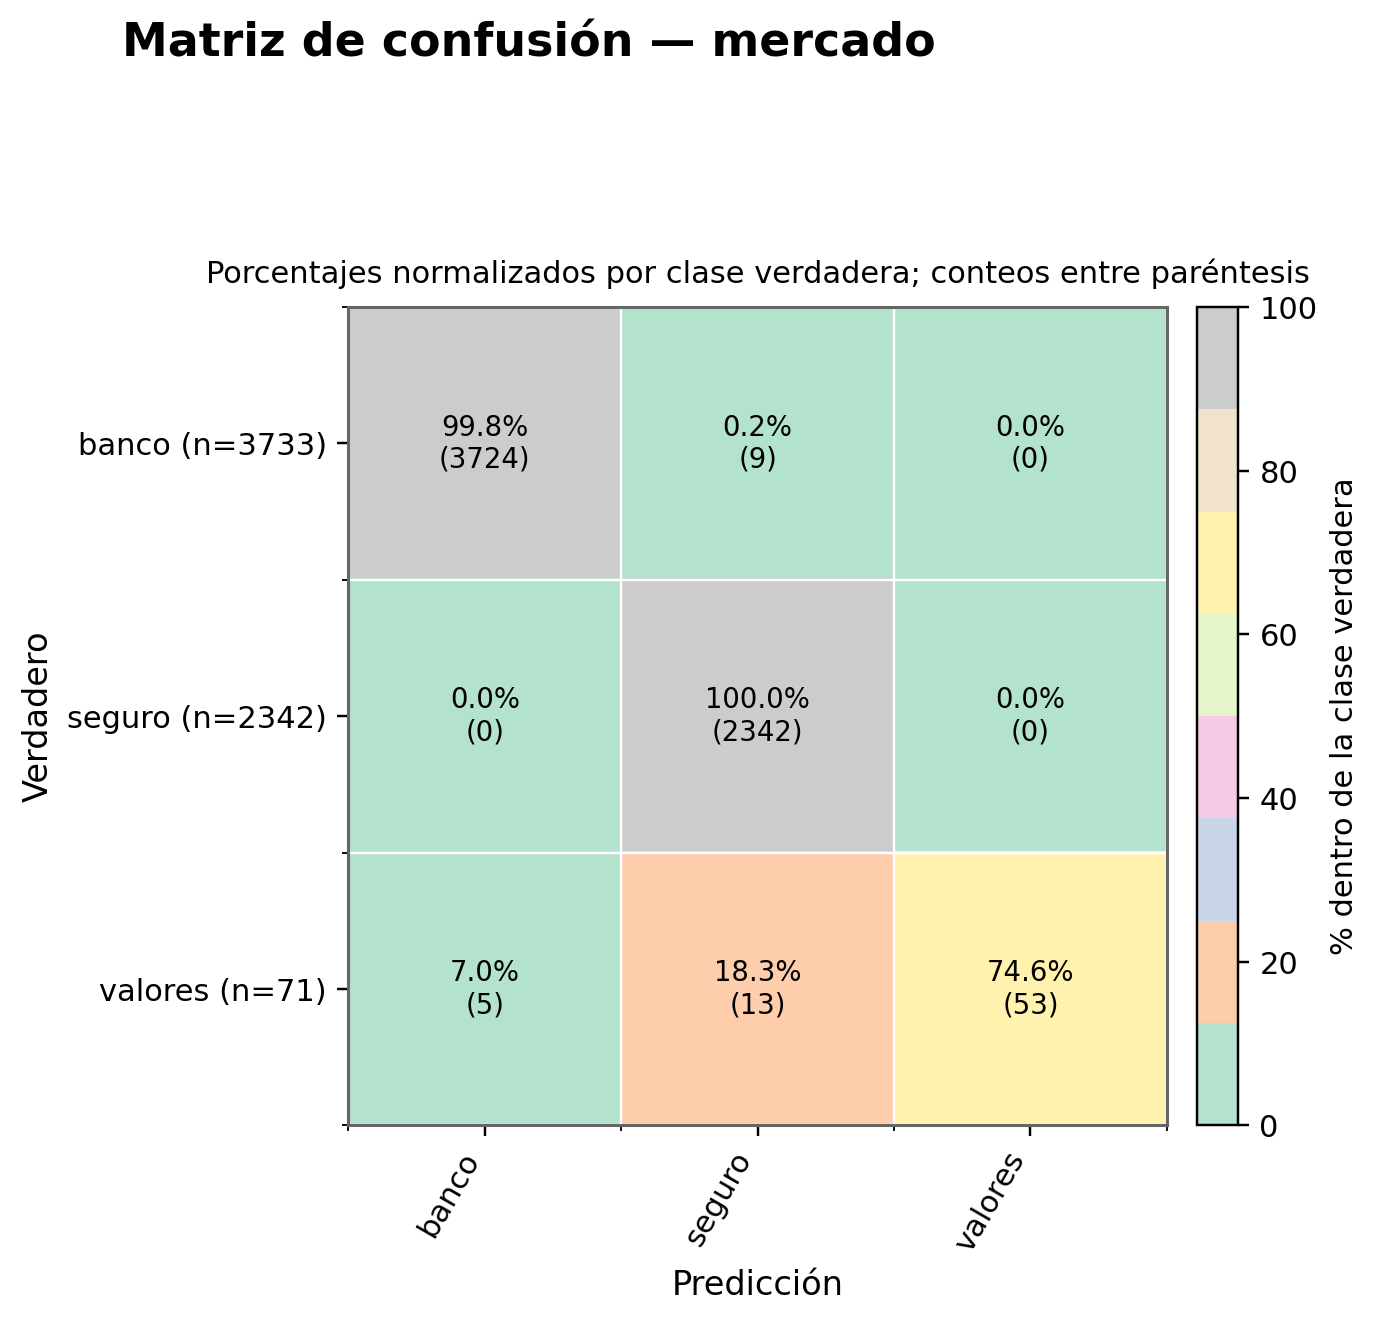

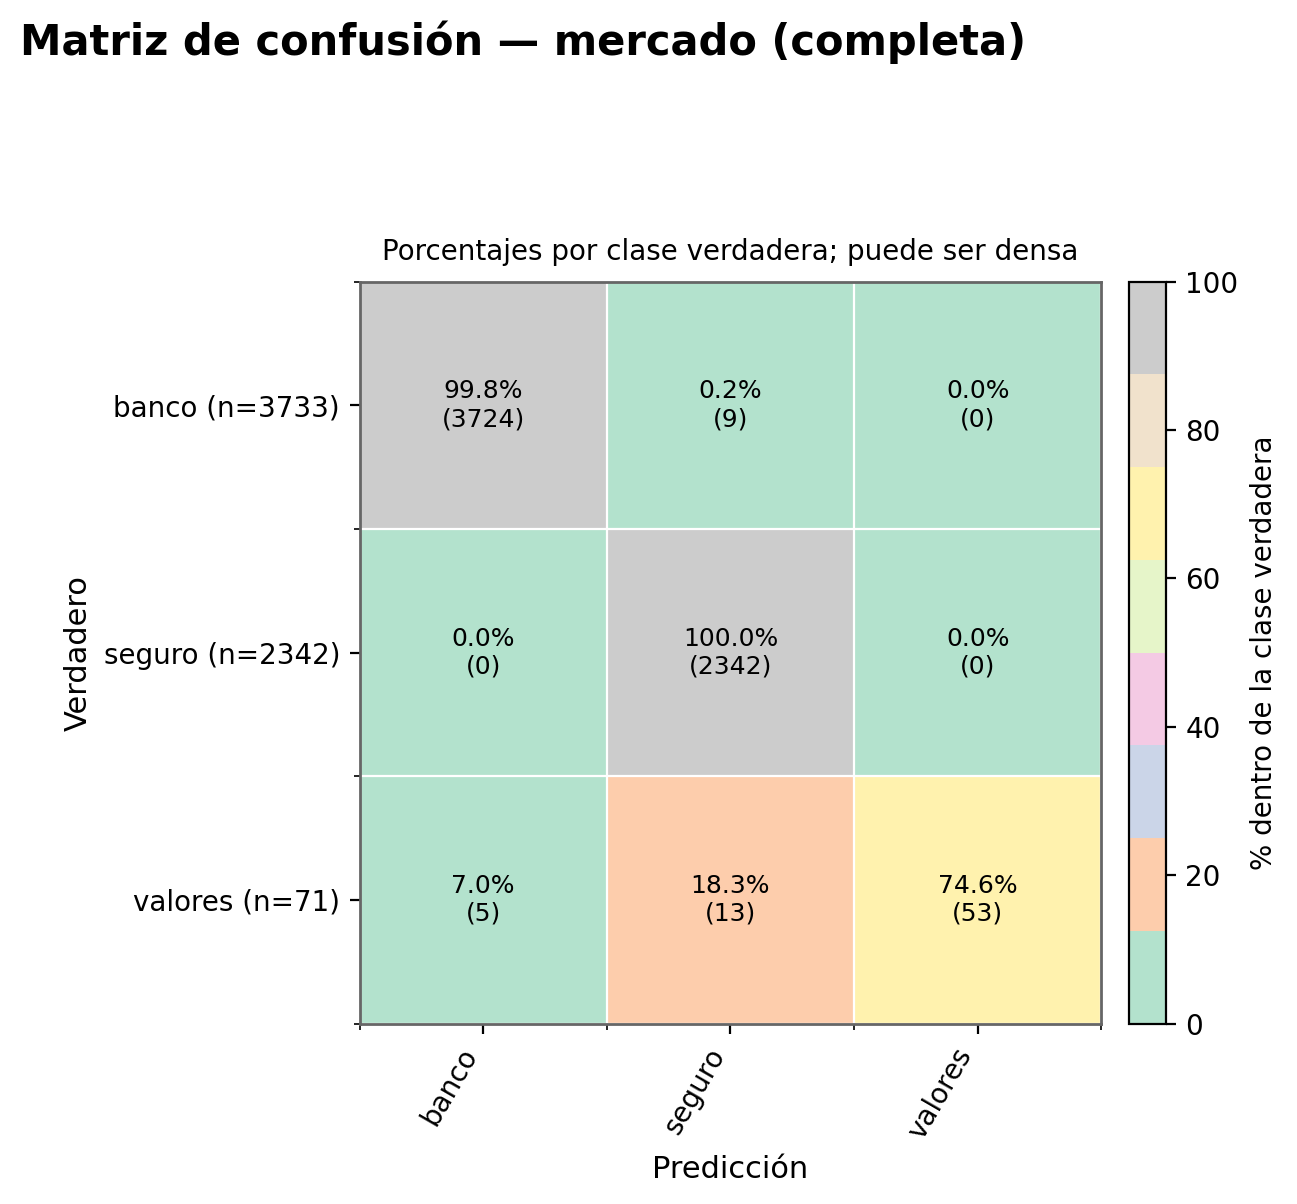

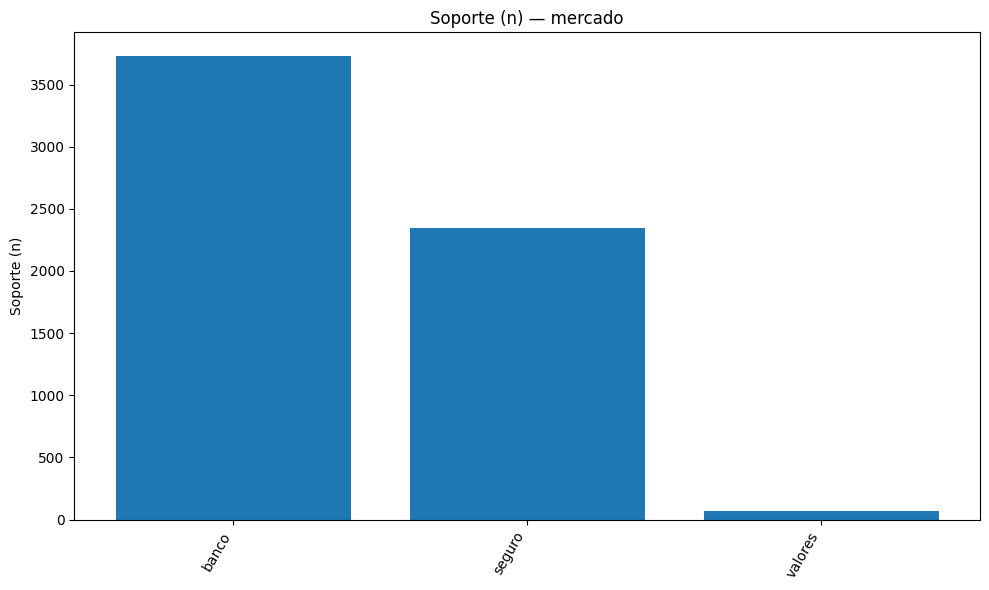

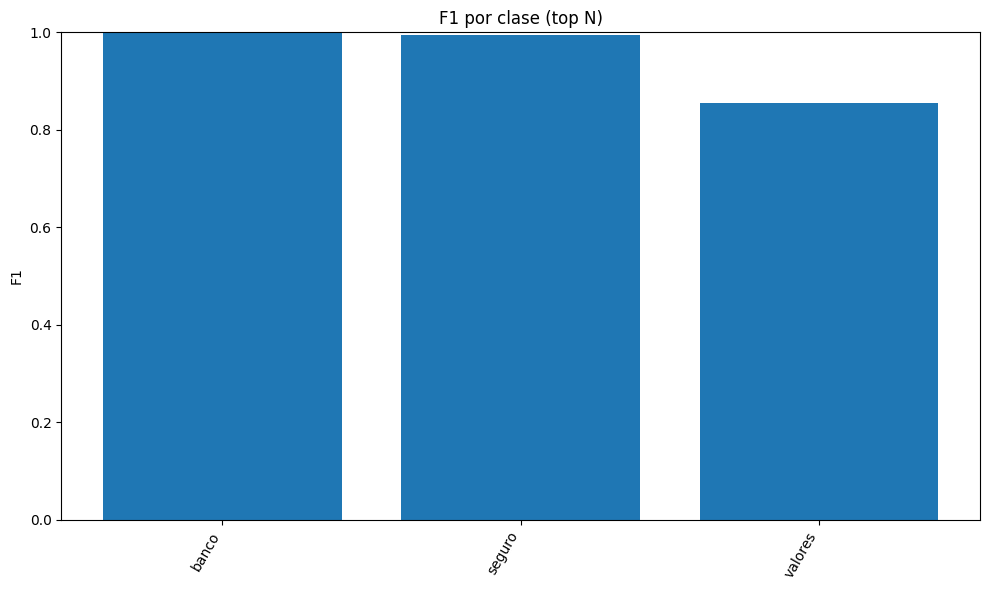

[mercado] micro-F1=0.996  macro-F1=0.949  weighted-F1=0.995  P=0.996  R=0.996
Errores guardados: outputs/errors_mercado.csv  (mostrando vista previa)


verdadero predicho                                              texto
0    valores   seguro  el furgon asegurado a nombre de comercial schu...
1    valores   seguro  no estoy de acuerdo con lo resuelto por la emp...
2    valores   seguro  apelacion siniestro de denuncio seguro salud e...
3      banco   seguro  tengo el reclamo ya ingresado con el numero 31...
4    valores    banco  les pido, por favor, ayuda en este caso... com...
5    valores    banco  me siento estafado por el leasing servicios fi...
6      banco   seguro  buenas tardes este reclamo es para forum servi...
7    valores   seguro  estimados, tengo contratada desde el ano 2016 ...
8    valores   seguro  estimados, junto con saludar, informo que la c...
9    valores    banco  ref.: reclamo por eventual negligencia en la a...
10   valores   seguro  se ha demorado la liquidacion del siniestro ho...
11     banco   seguro  garantia credito hipotecario hace casi 11 anos...
12   valores   seguro  no se ha pagado el seguro oncologico pese a qu...
13   valores   seguro  la indemnizacion no es suficiente para cubrir ...
14   valores   seguro  lo que pasa tuve un accidente , colisionado po...
15   valores    banco  estimados/as: por medio de la presente, vengo ...
16   valores   seguro  buenas tardes, el dia 09/09/2025 me robaron mi...
17     banco   seguro  estimada cmf, por medio del presente procedo a...
18     banco   seguro  nombre: marcelo ramos morales rut: 11615966-k ...
19     banco   seguro  mi padre, don pedro pizarro unanue (rut 6.518....
20     banco   seguro  i. exposicion de los hechos 1. desde hace vari...
21     banco   seguro  i. exposicion de los hechos 1. desde hace vari...
22   valores   seguro  contrate con fecha 02-07-2025 una poliza con b...
23   valores   seguro  buenos dias, yo contrate un seguro el dia 5 de...
24     banco   seguro  seguros que desconozco(3) desde 24 de junio 20...


Target: producto
  Vectorizadores usados: ['tfidf_word_producto.joblib']


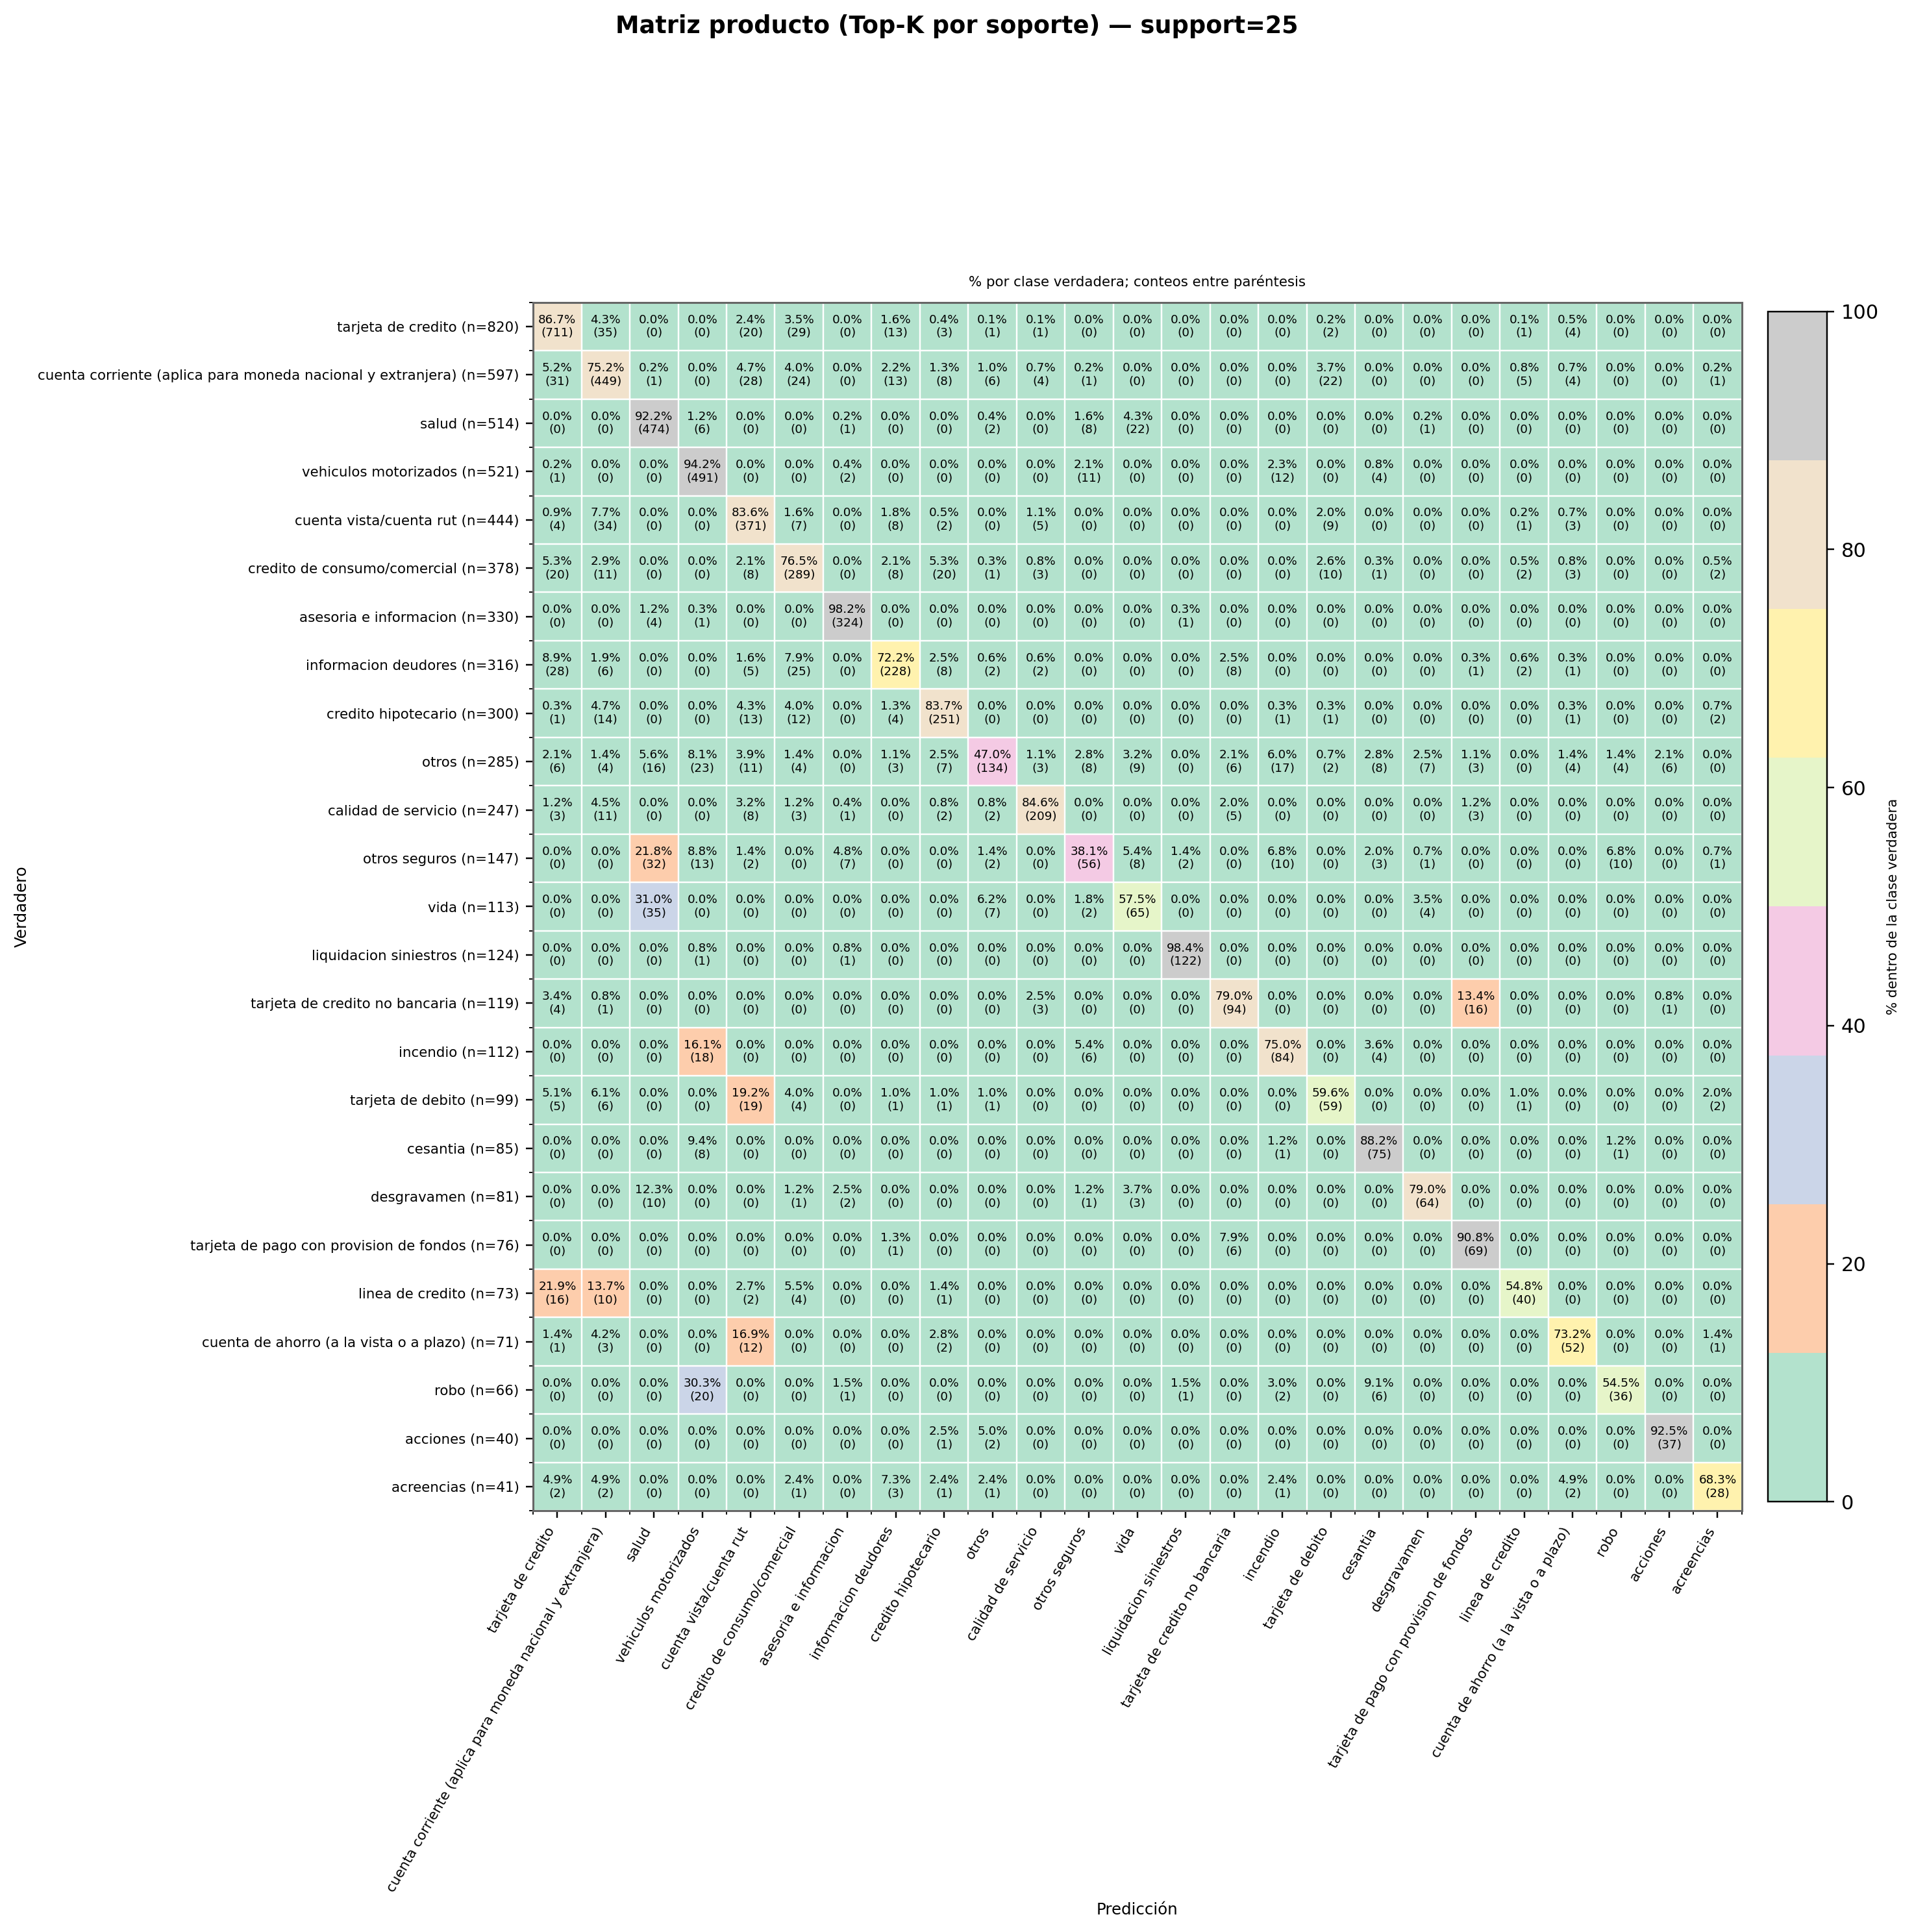

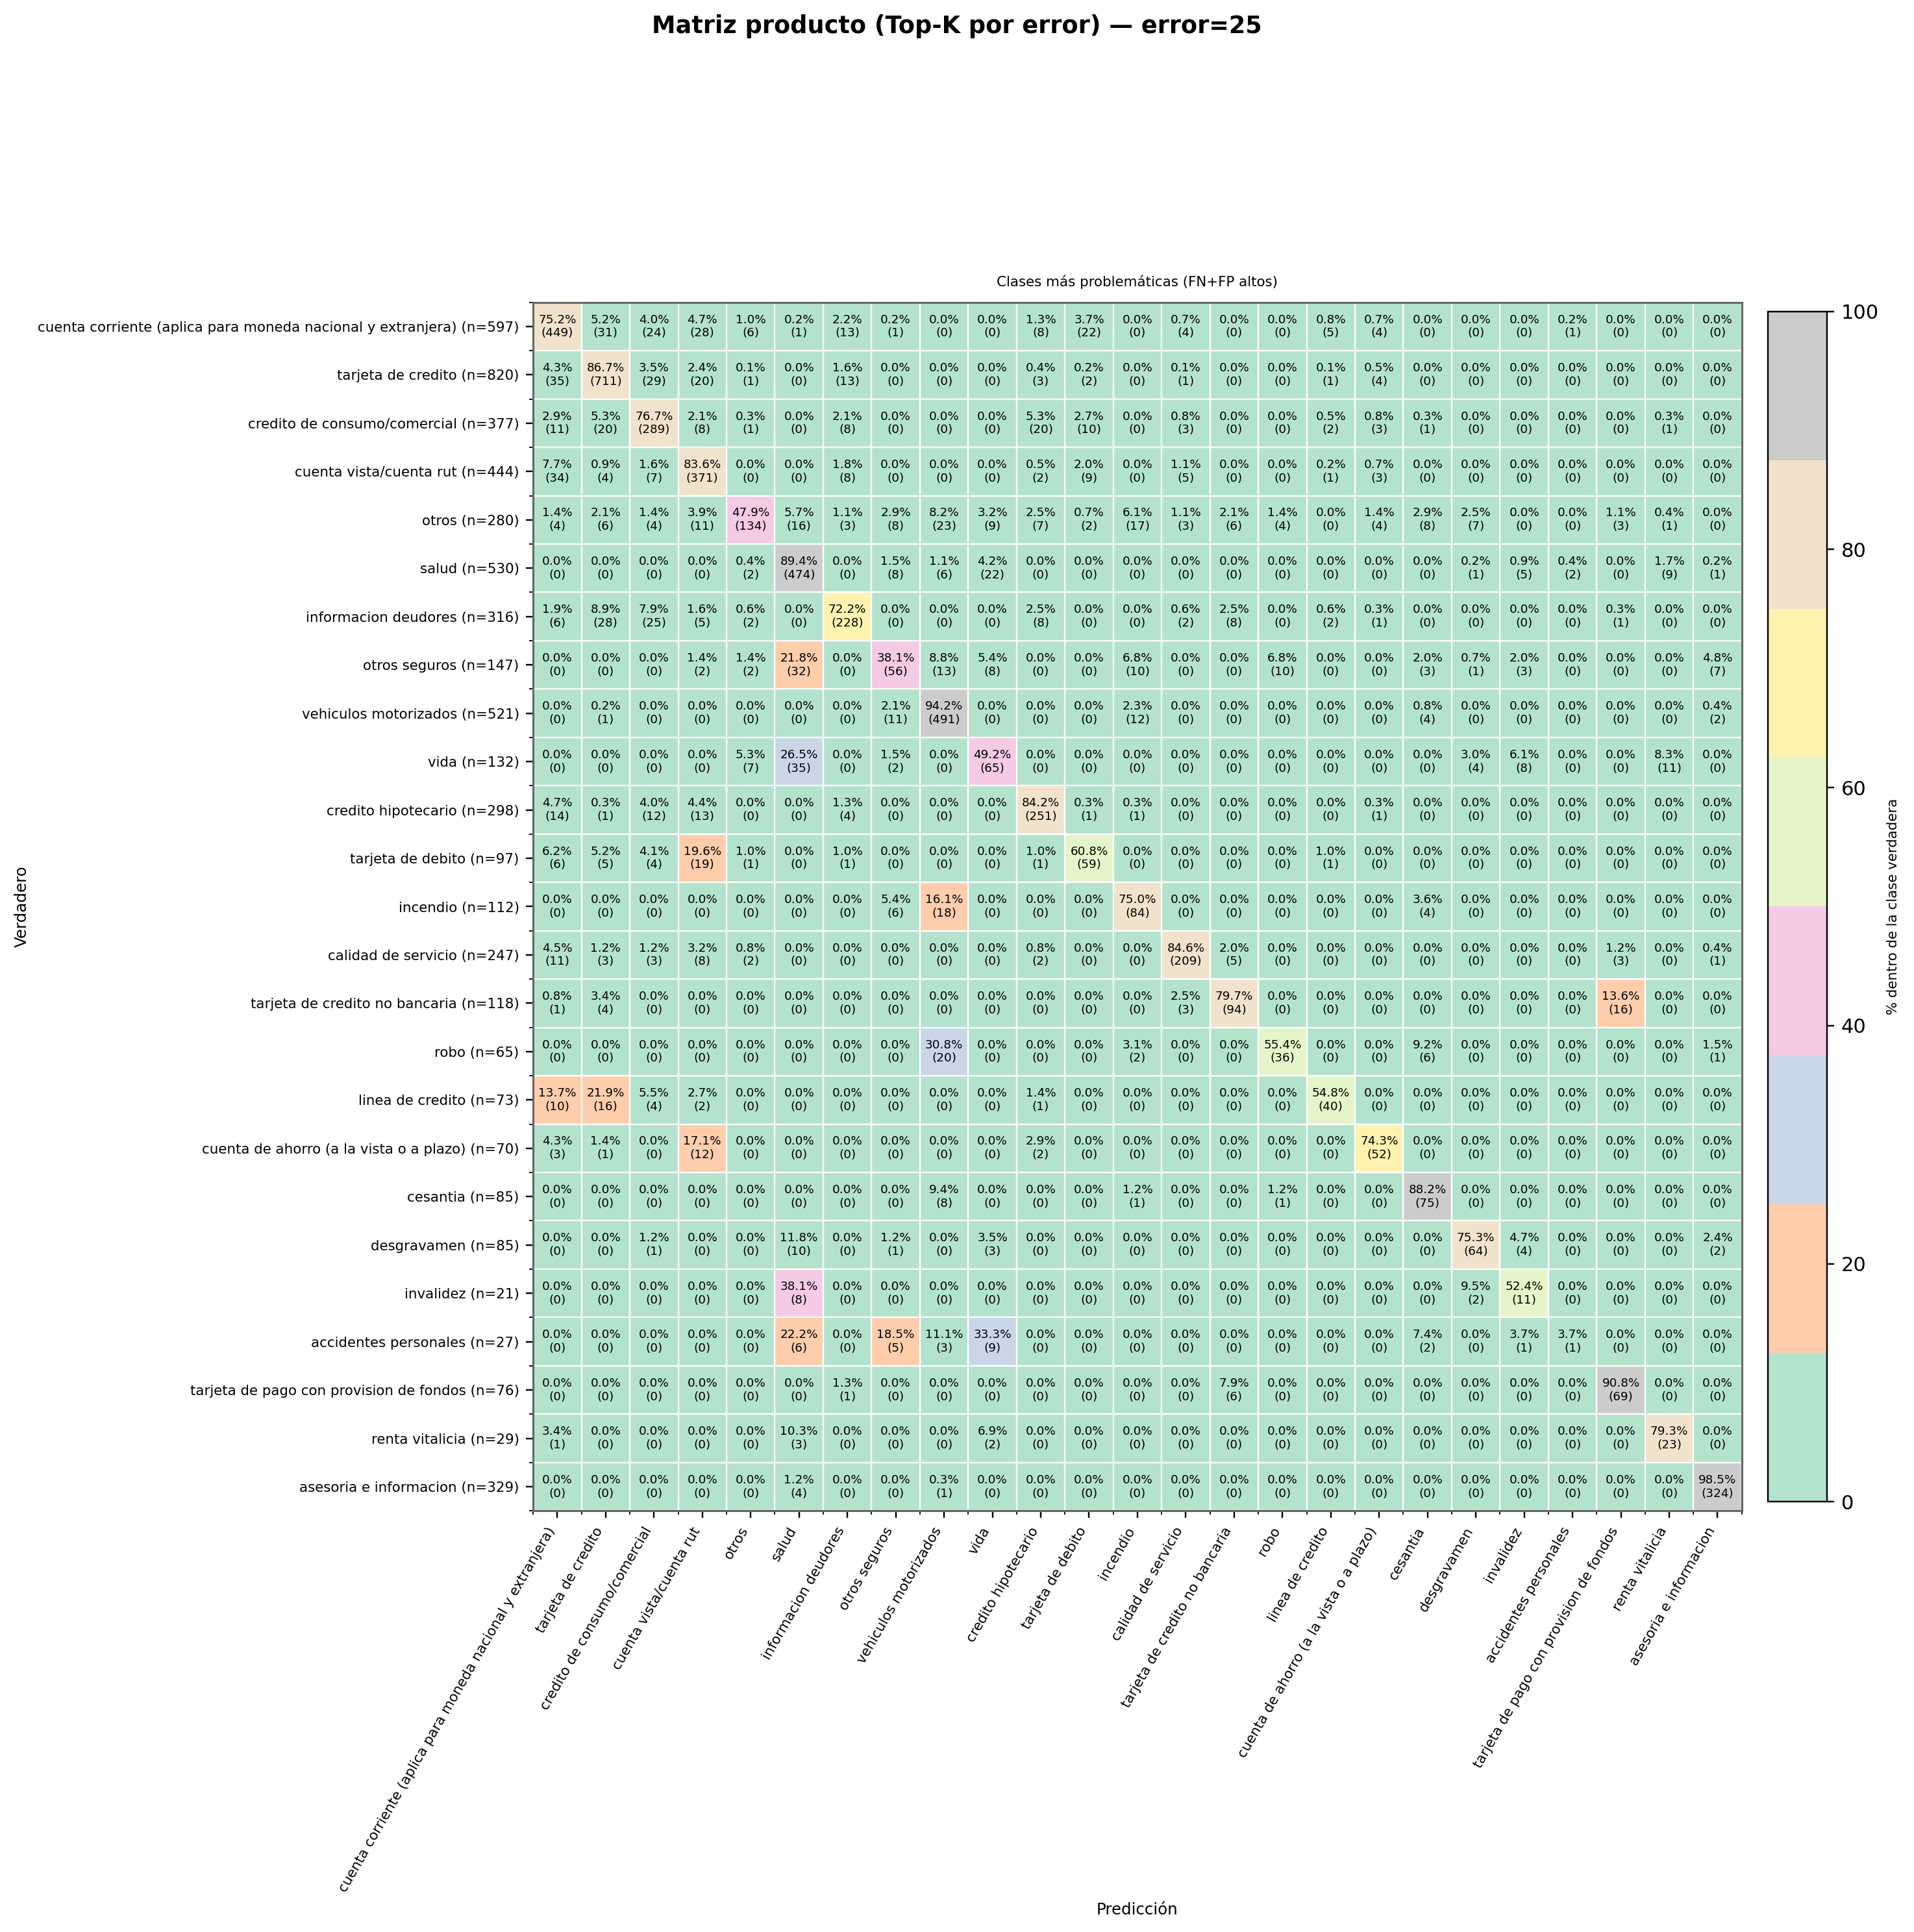

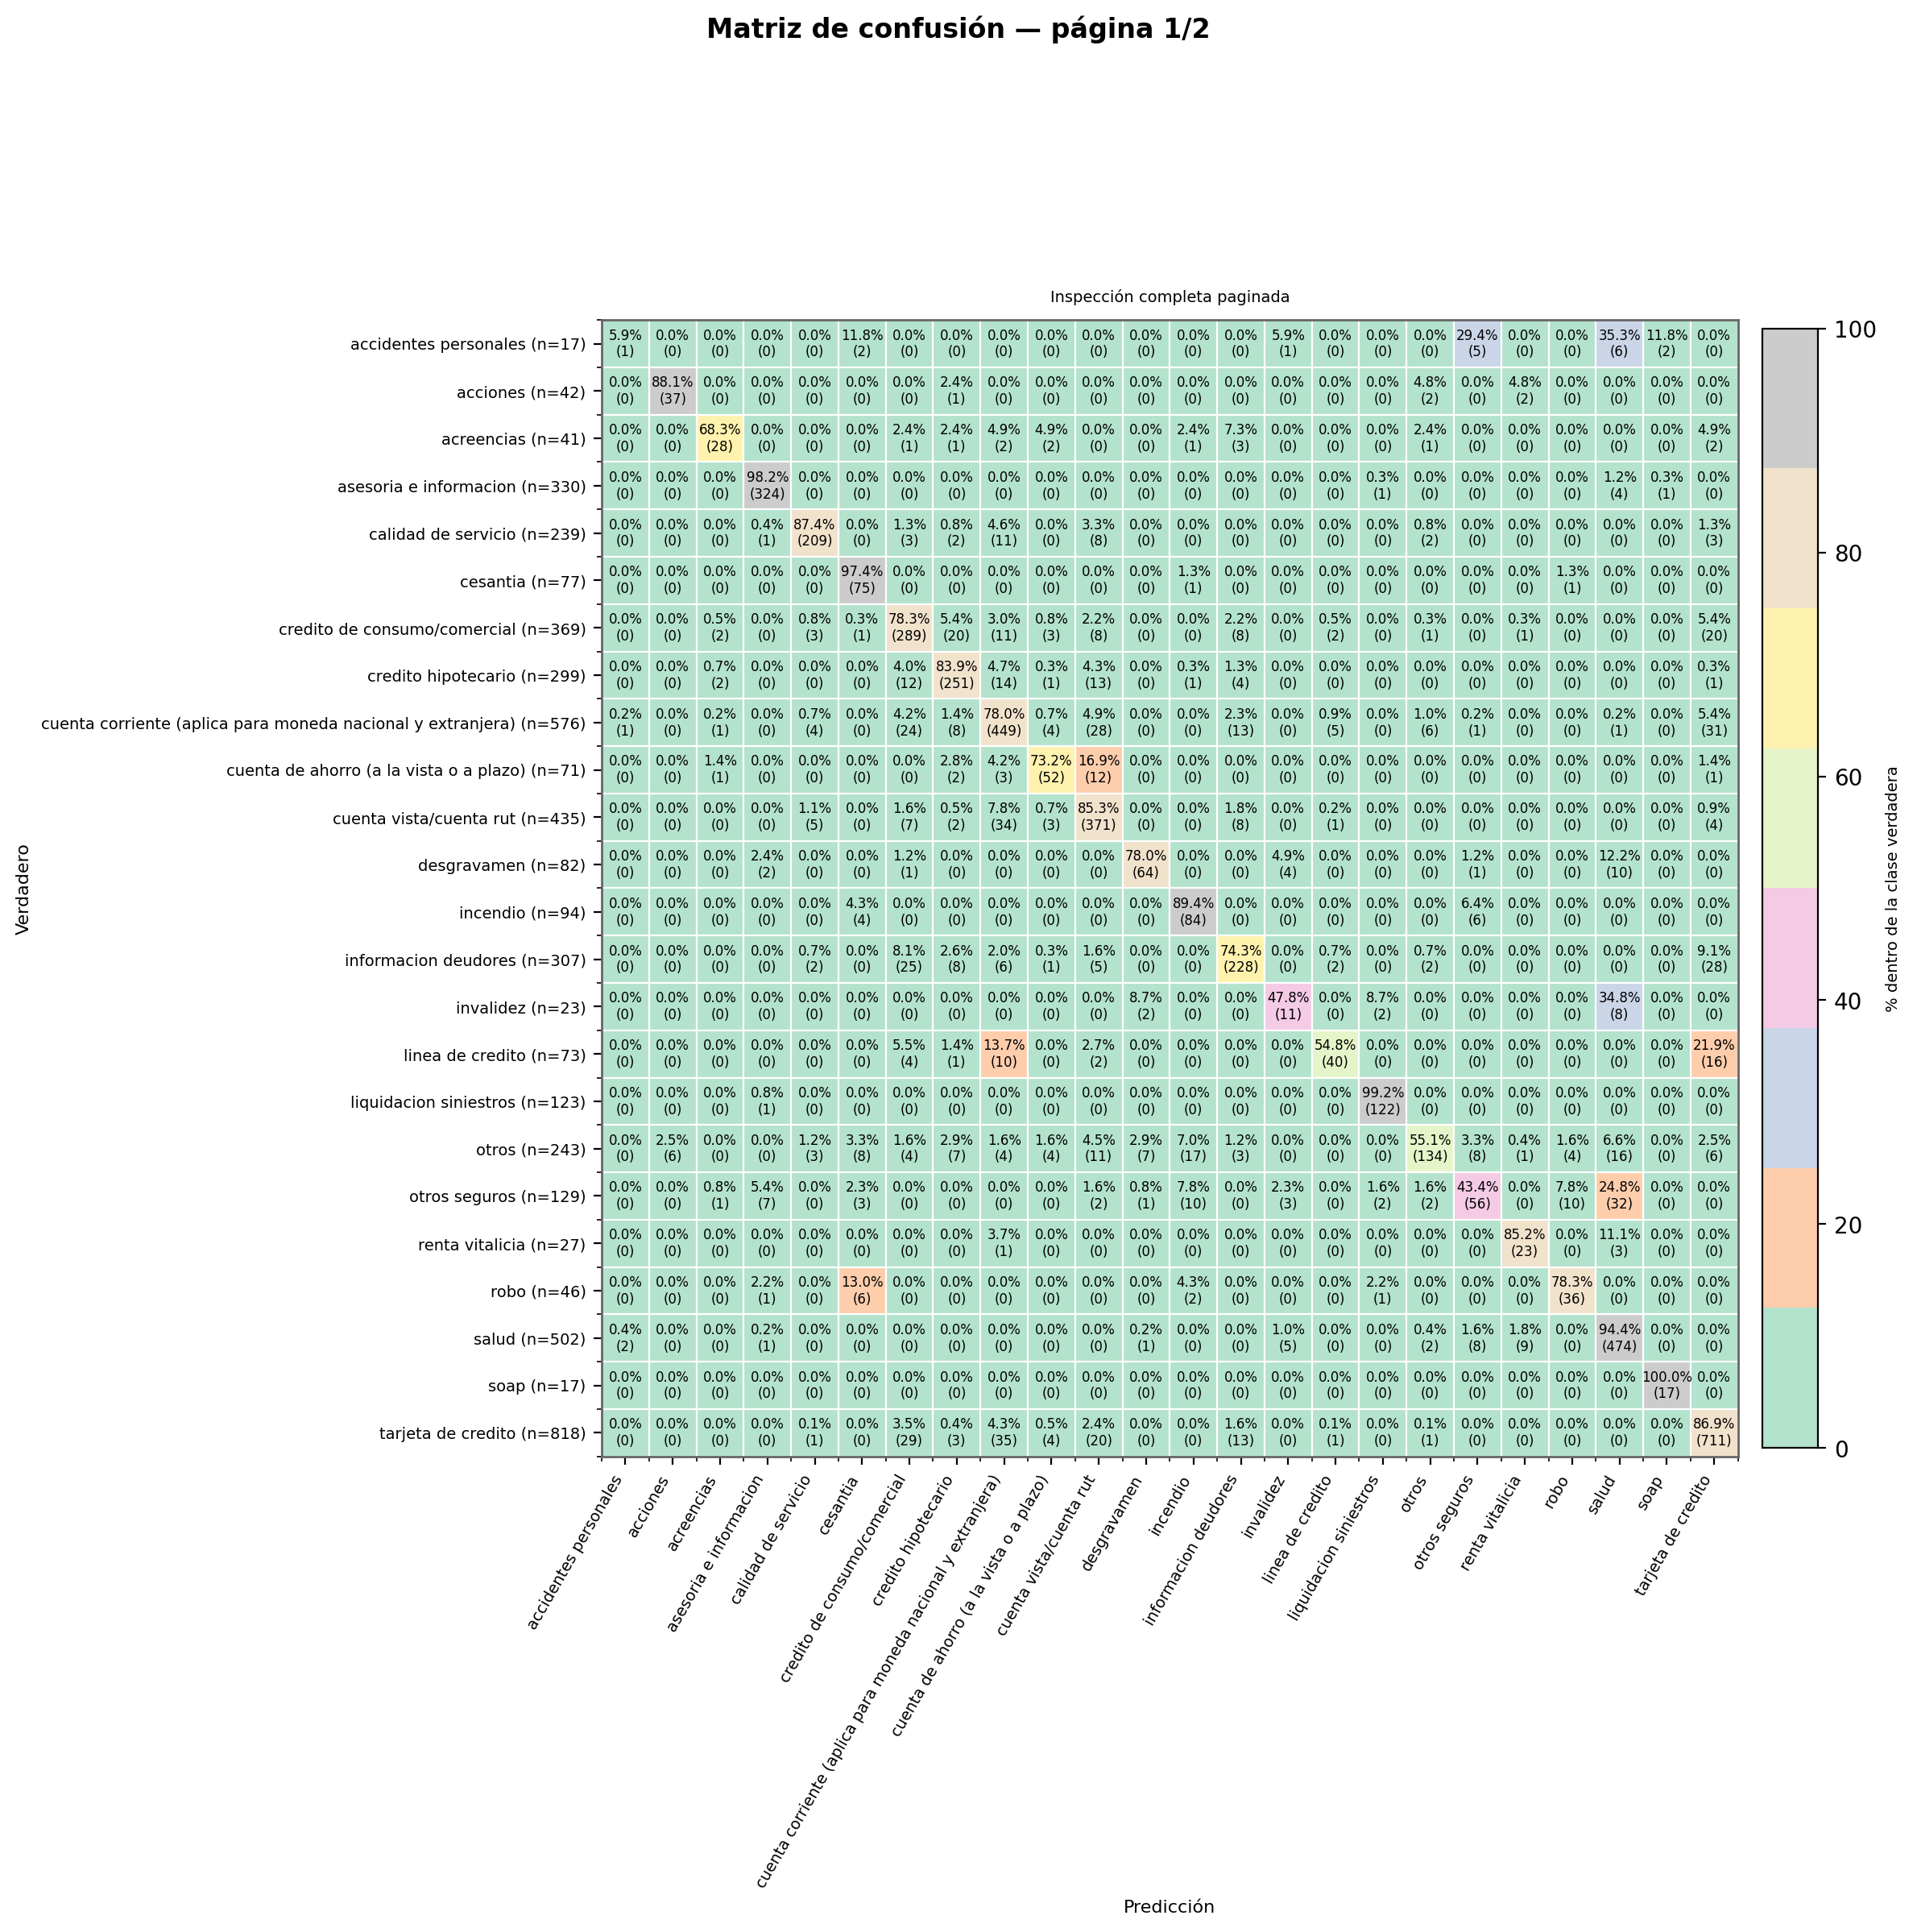

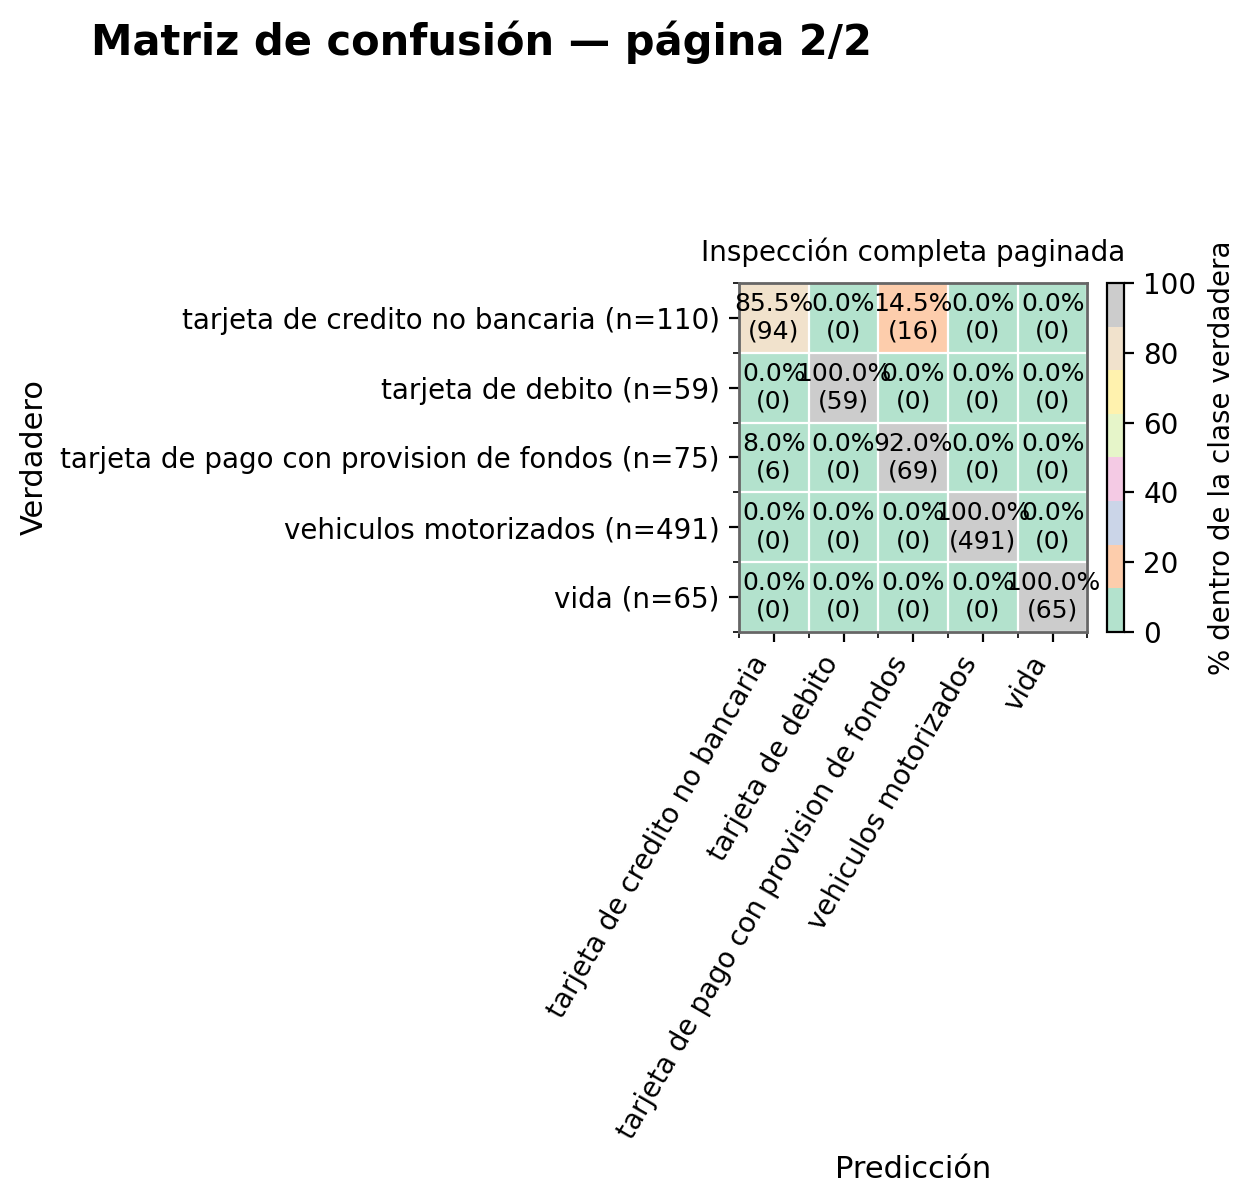

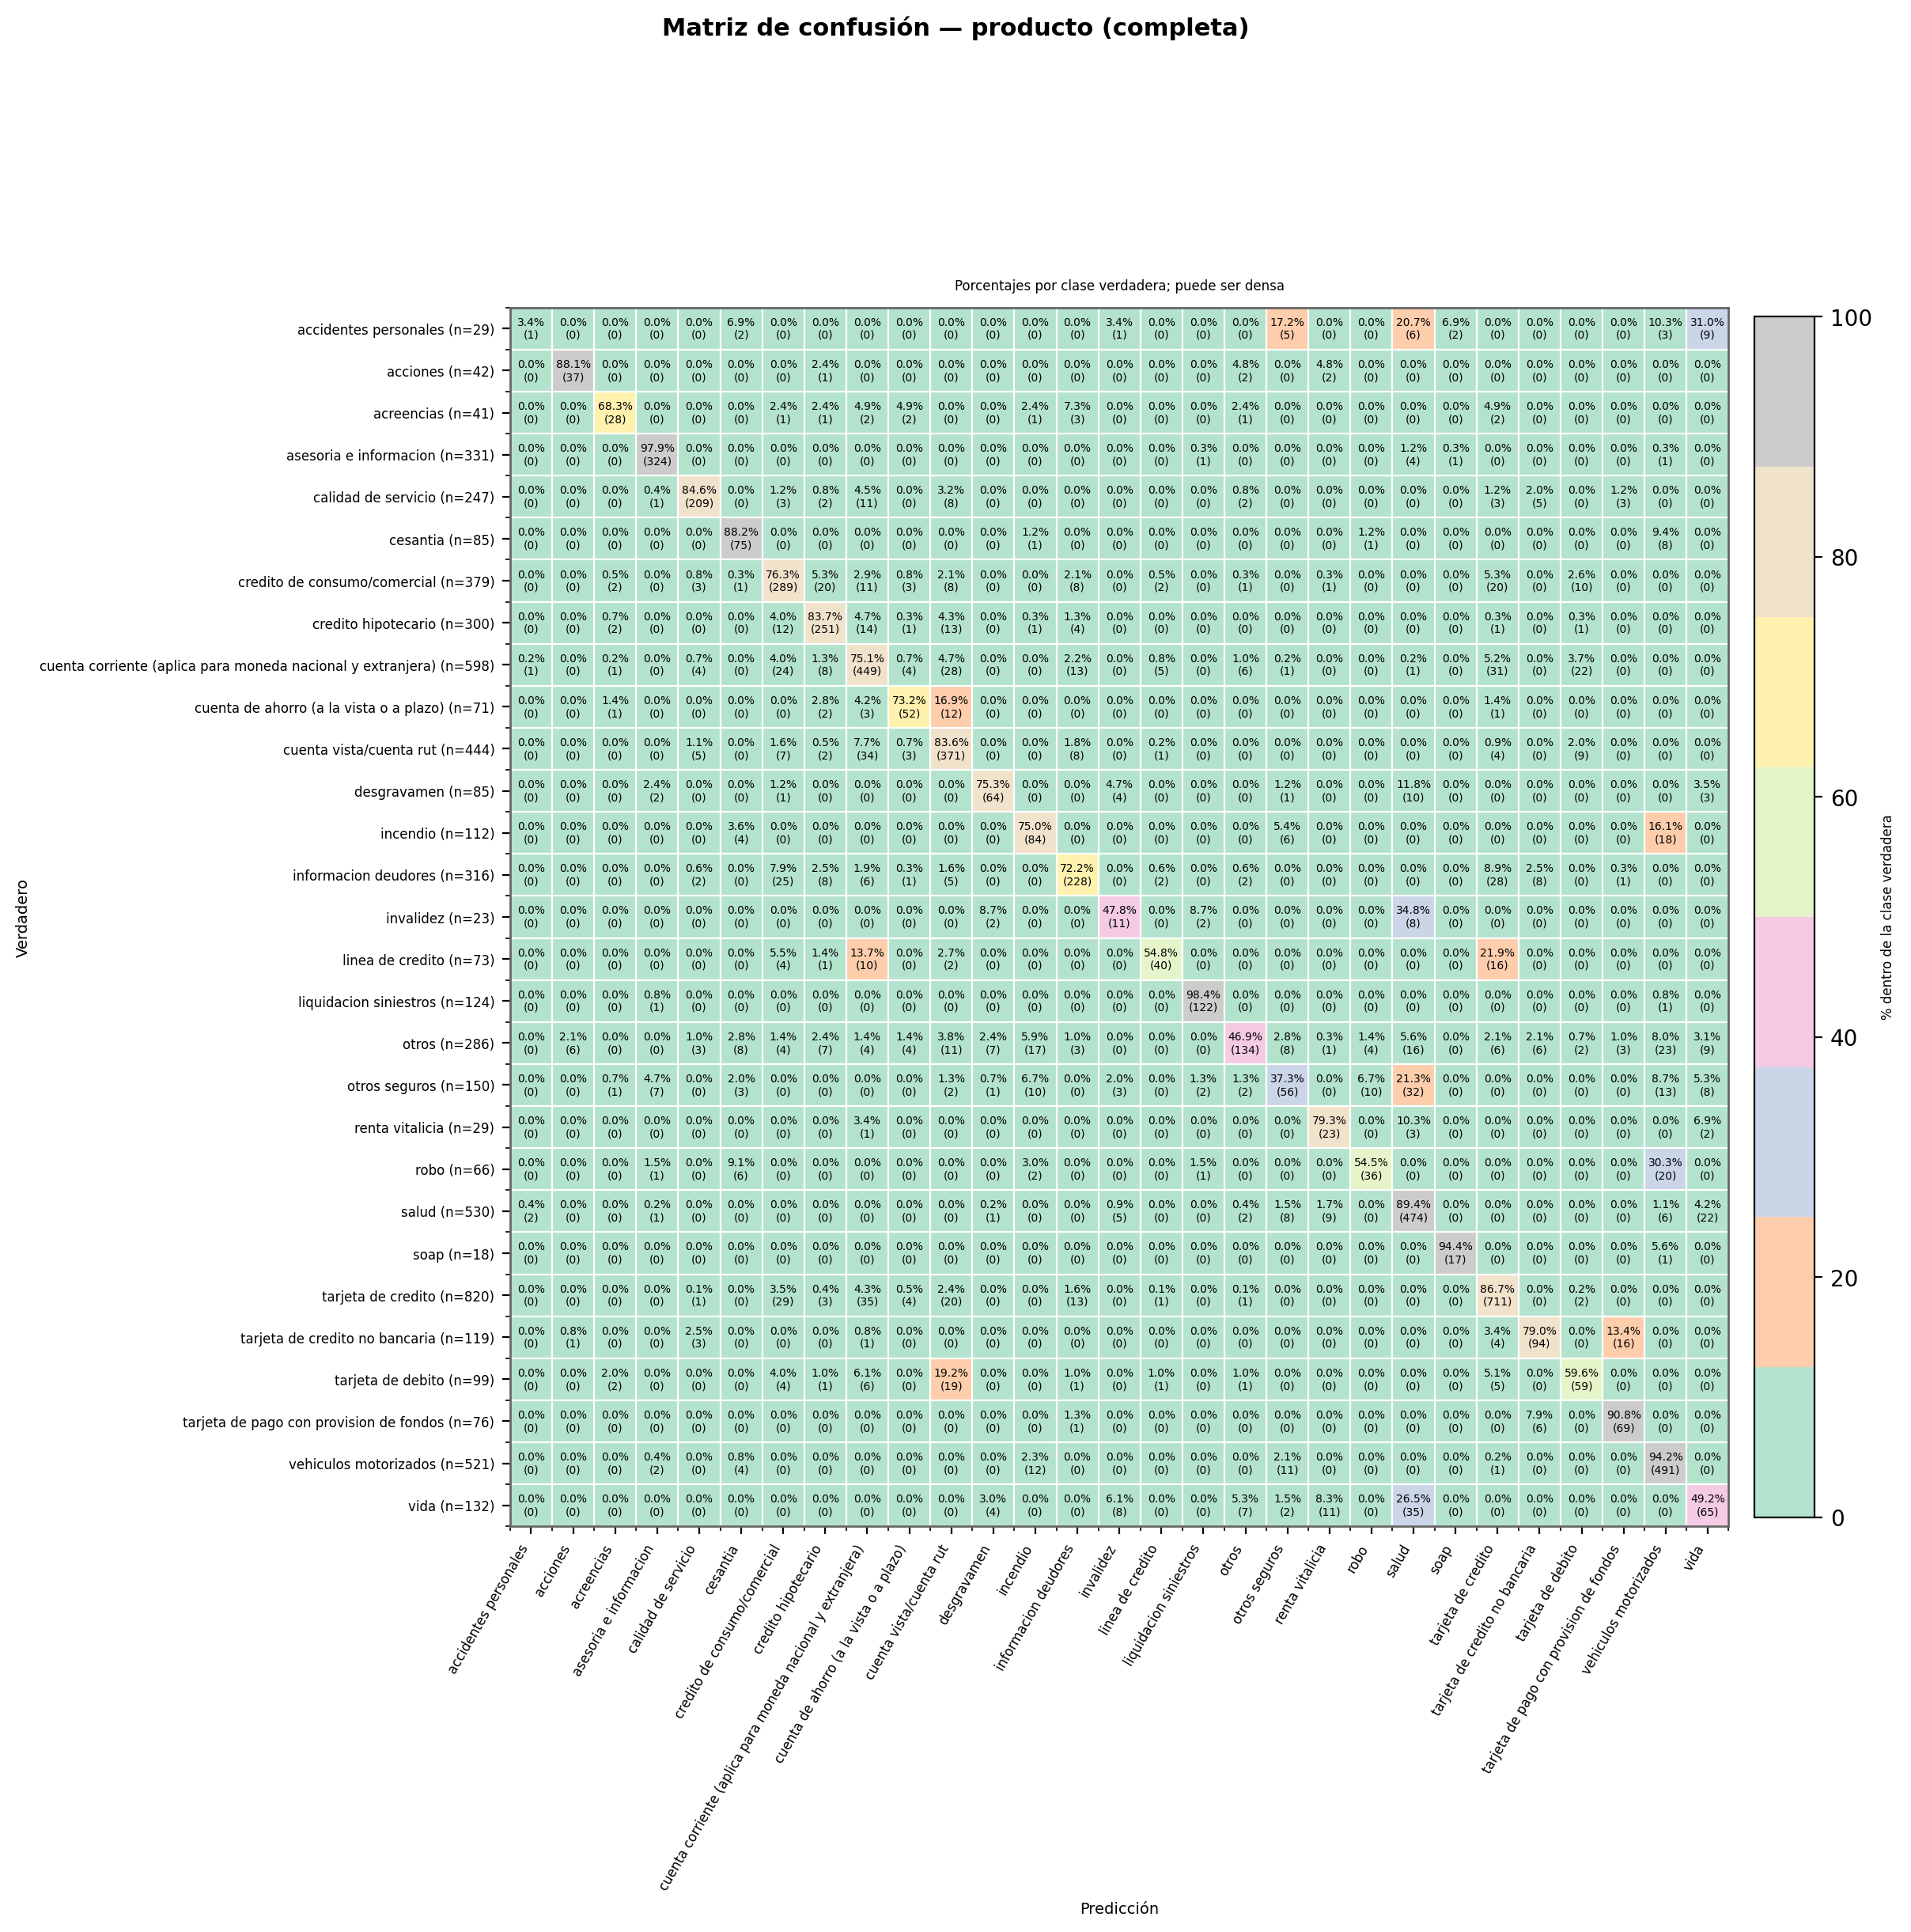

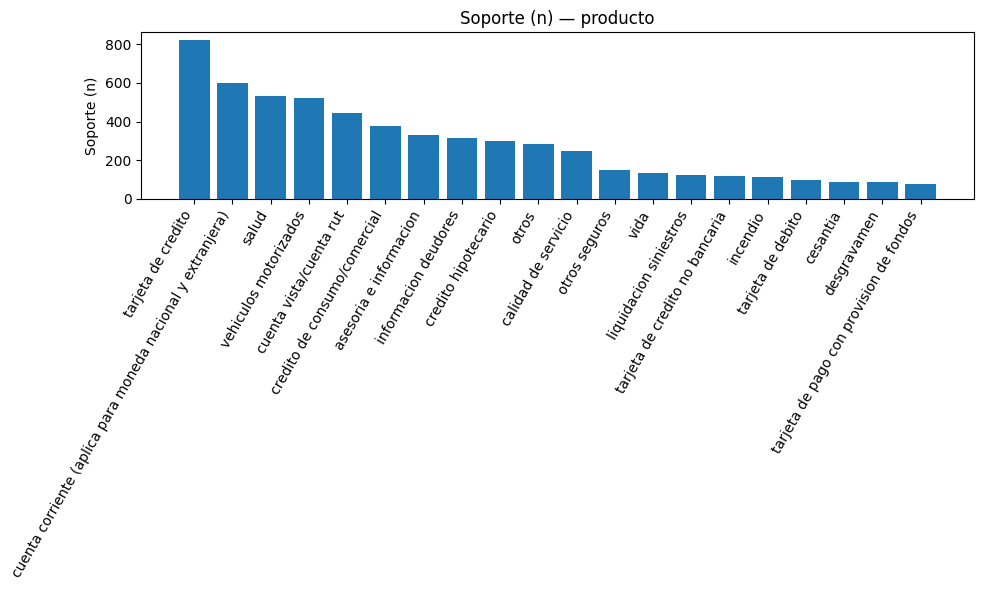

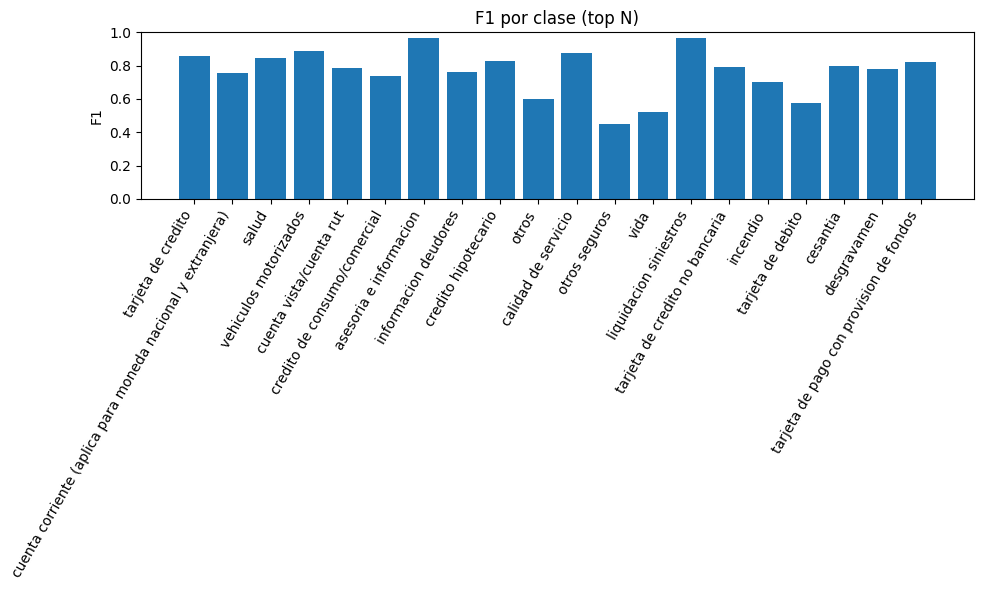

[producto] micro-F1=0.791  macro-F1=0.718  weighted-F1=0.786  P=0.790  R=0.791
Errores guardados: outputs/errors_producto.csv  (mostrando vista previa)


verdadero  \
0                                               salud   
1                                 credito hipotecario   
2                                  tarjeta de credito   
3                        credito de consumo/comercial   
4                                  tarjeta de credito   
5                                                vida   
6                               vehiculos motorizados   
7                                 calidad de servicio   
8                                     renta vitalicia   
9                                                vida   
10                                calidad de servicio   
11                                calidad de servicio   
12                                         acreencias   
13                                         acreencias   
14  cuenta corriente (aplica para moneda nacional ...   
15                                calidad de servicio   
16                                calidad de servicio   
17  cuenta corriente (aplica para moneda nacional ...   
18                               informacion deudores   
19                       credito de consumo/comercial   
20                                  tarjeta de debito   
21                                      otros seguros   
22                                      otros seguros   
23                                   linea de credito   
24                                calidad de servicio   

                                             predicho  \
0                                                vida   
1                        credito de consumo/comercial   
2   cuenta corriente (aplica para moneda nacional ...   
3                             cuenta vista/cuenta rut   
4                             cuenta vista/cuenta rut   
5                                     renta vitalicia   
6                                            incendio   
7                                               otros   
8                                               salud   
9                                     renta vitalicia   
10                     tarjeta de credito no bancaria   
11                     tarjeta de credito no bancaria   
12                                 tarjeta de credito   
13                                 tarjeta de credito   
14                                credito hipotecario   
15                            cuenta vista/cuenta rut   
16                            cuenta vista/cuenta rut   
17                            cuenta vista/cuenta rut   
18                     tarjeta de credito no bancaria   
19                                credito hipotecario   
20                            cuenta vista/cuenta rut   
21                                               robo   
22                                           incendio   
23                                 tarjeta de credito   
24                                 tarjeta de credito   

                                                texto  
0   estimados senores comision para el mercado fin...  
1   estimados , por este reclamo de mas abajo , so...  
2   2025090637129 freddy eduardo sotomayor leiva o...  
3   2025090637177 jorge alfredo vaquerizas labra o...  
4   2025090638322 cristian antonio cornejo fuentes...  
5   compl.ingresos sernac - 2649103 y reclamo segu...  
6   li 2025090638500 leonel andres salazar arias o...  
7   estimados junto con saludar cordialmente, me d...  
8   con fecha 20/08/2025, hice un reclamo a la com...  
9   compl.ingresos sernac - 2649103 y reclamo segu...  
10  2025090638675 genesis abigail salas munoz ofp ...  
11  2025090638675 genesis abigail salas munoz ofp ...  
12  2025090638708 grace marjorie watson donoso ofp...  
13  2025090638708 grace marjorie watson donoso ofp...  
14  el dia 29 de agosto del presente ano, el banco...  
15  2025090638749 gloria roxana valenzuela villaco...  
16  2025090638749 gloria roxana valenzuela villaco...  
17  2025090639154 gustavo adolfo cesped cariaga of...  
18  a pesar de


Target: materia
  Vectorizadores usados: ['tfidf_word_materia.joblib', 'tfidf_char_materia.joblib']


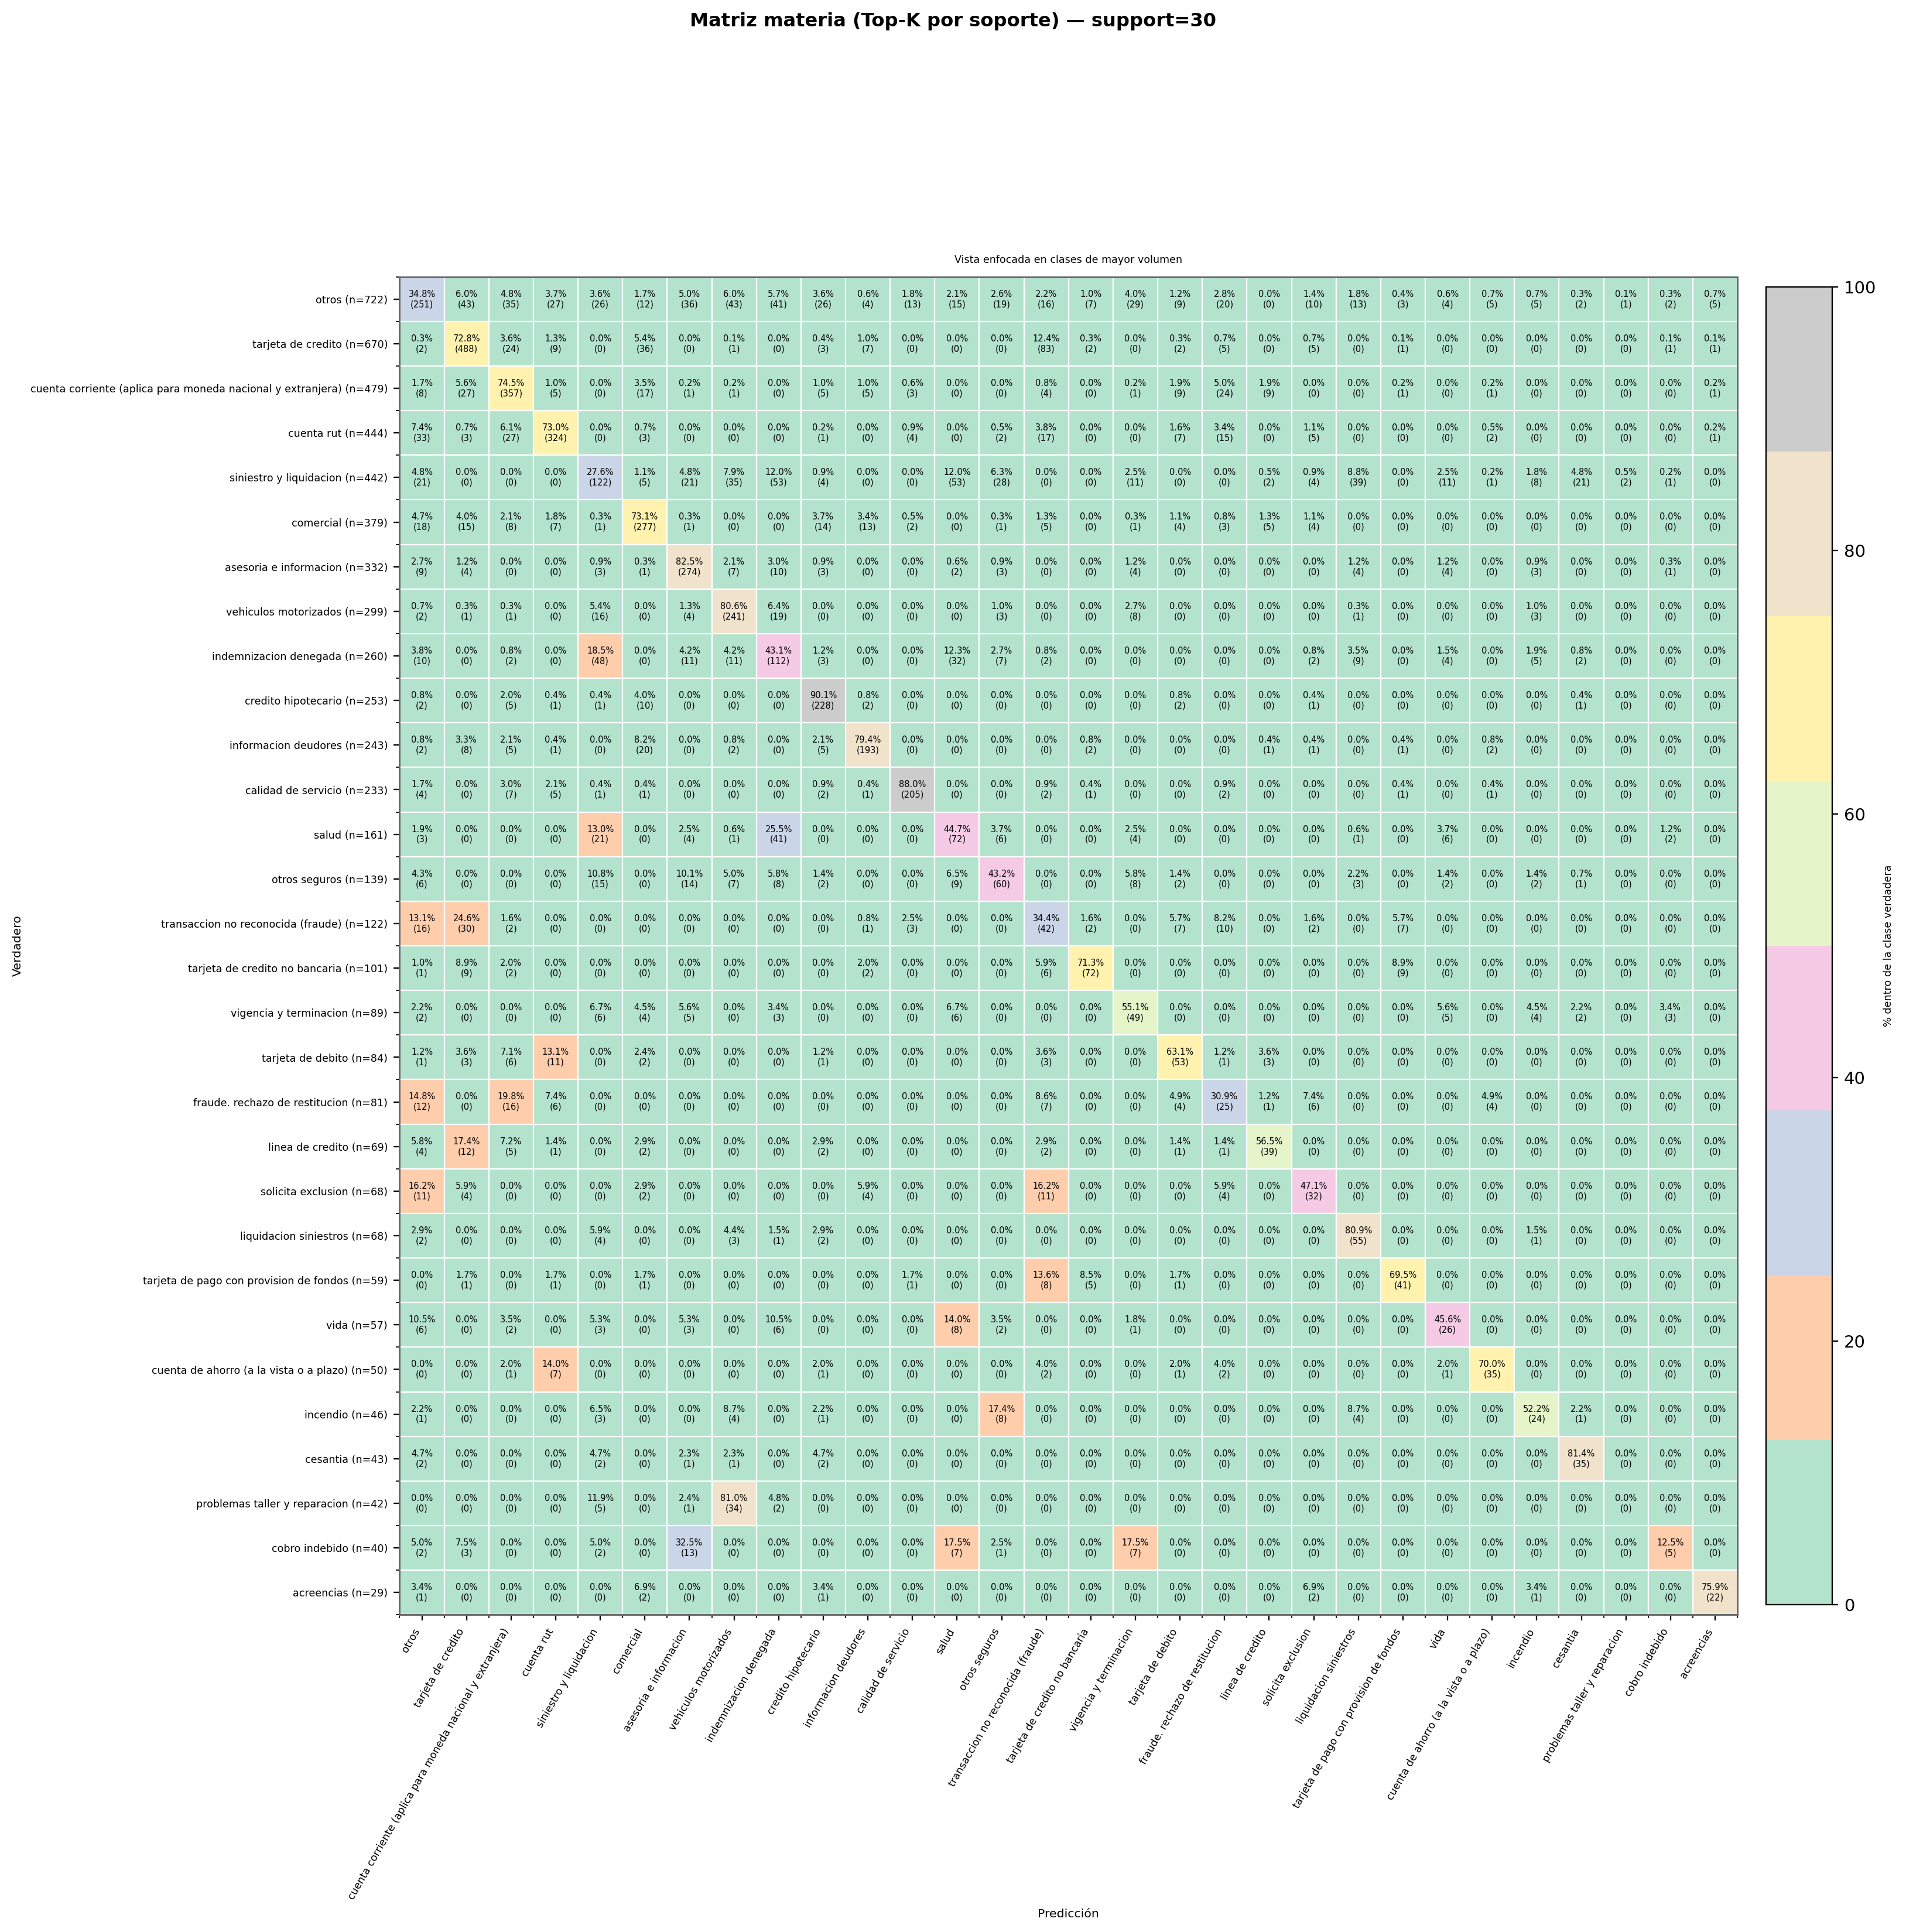

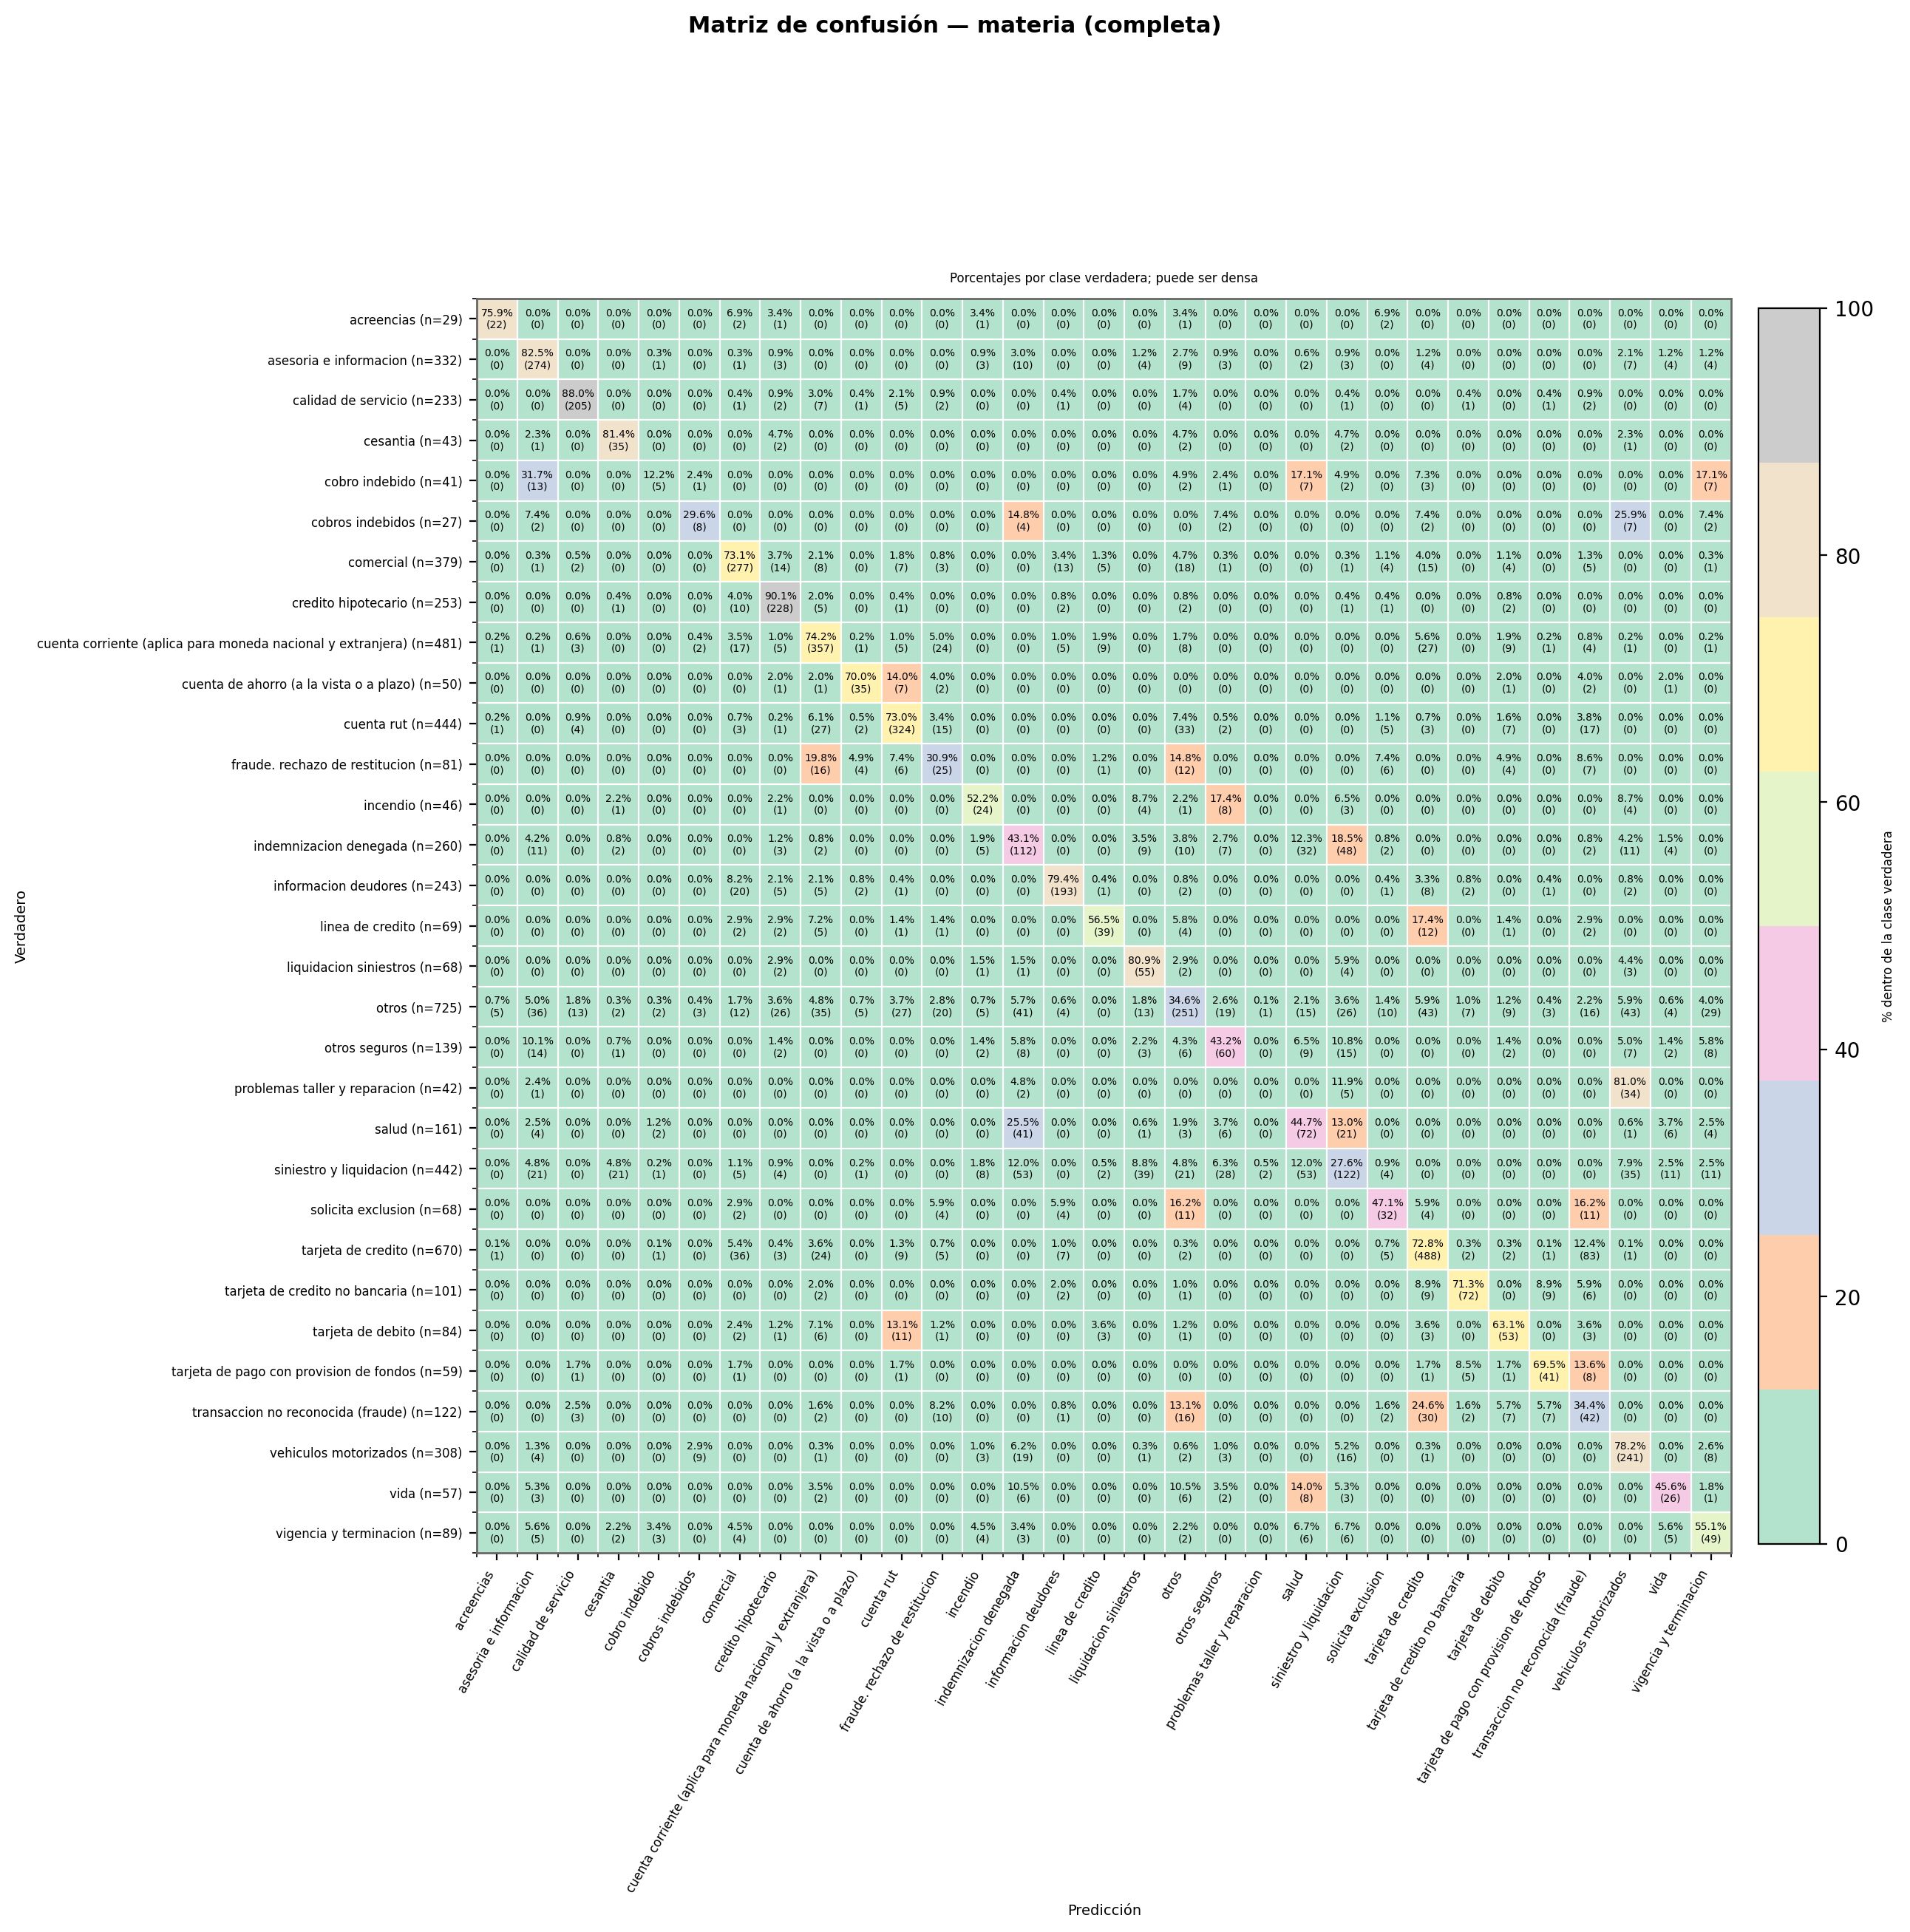

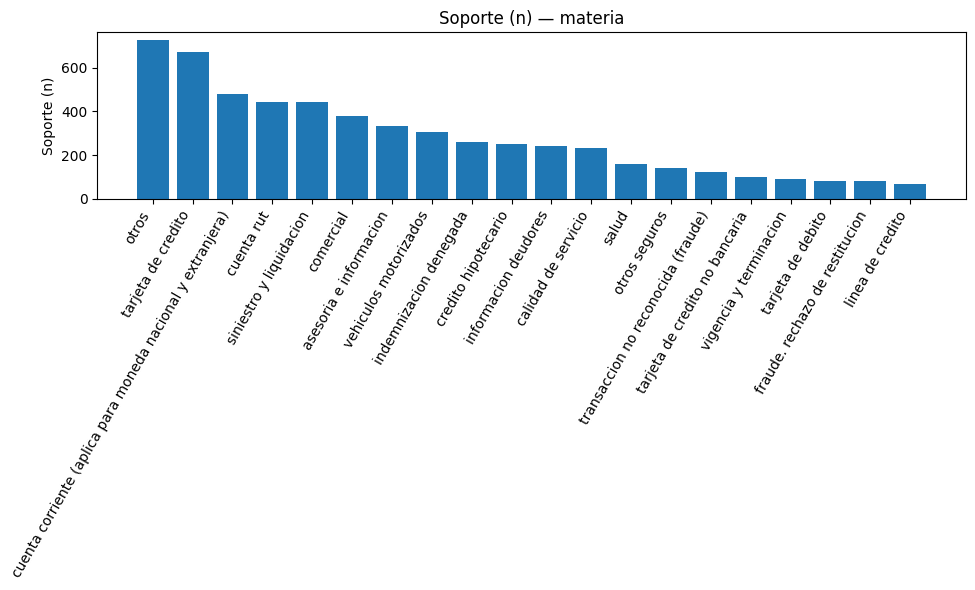

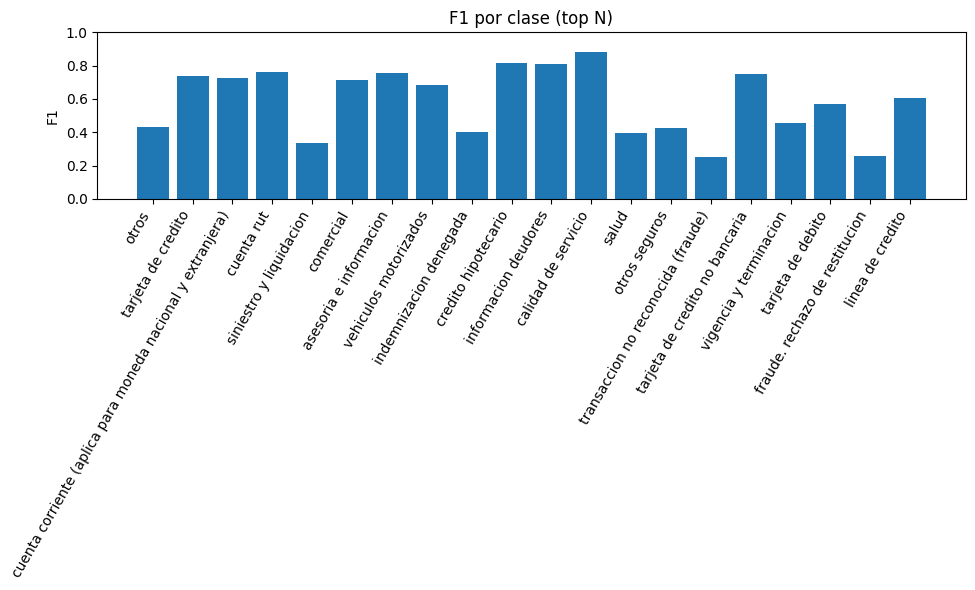

[materia] micro-F1=0.613  macro-F1=0.547  weighted-F1=0.607  P=0.617  R=0.613
Errores guardados: outputs/errors_materia.csv  (mostrando vista previa)


verdadero  \
0                             siniestro y liquidacion   
1                             siniestro y liquidacion   
2             tarjeta de pago con provision de fondos   
3                                 credito hipotecario   
4                                               otros   
5                  transaccion no reconocida (fraude)   
6                                           comercial   
7                                          cuenta rut   
8                                               otros   
9                              indemnizacion denegada   
10                            siniestro y liquidacion   
11                                calidad de servicio   
12                                              otros   
13                             indemnizacion denegada   
14  cuenta corriente (aplica para moneda nacional ...   
15                                              otros   
16                                              otros   
17                                              otros   
18                                              salud   
19                               informacion deudores   
20                                              salud   
21            tarjeta de pago con provision de fondos   
22                                 tarjeta de credito   
23                              vehiculos motorizados   
24                                  tarjeta de debito   

                              predicho  \
0                       cobro indebido   
1                                salud   
2                           cuenta rut   
3                    tarjeta de debito   
4               indemnizacion denegada   
5                                otros   
6                                otros   
7                                otros   
8                           cuenta rut   
9              siniestro y liquidacion   
10                               otros   
11                               otros   
12              asesoria e informacion   
13             siniestro y liquidacion   
14                 credito hipotecario   
15  transaccion no reconocida (fraude)   
16  transaccion no reconocida (fraude)   
17  transaccion no reconocida (fraude)   
18              vigencia y terminacion   
19      tarjeta de credito no bancaria   
20                                vida   
21                 calidad de servicio   
22  transaccion no reconocida (fraude)   
23                            incendio   
24                          cuenta rut   

                                                texto  
0   estimados senores comision para el mercado fin...  
1   asunto: reclamo formal - caso n.o 3099670 - se...  
2   se realizo por parte de tenpo bloqueo de mi cu...  
3   estimados , por este reclamo de mas abajo , so...  
4   li 2025090636918 brayan mario alcantara sanche...  
5   2025090637129 freddy eduardo sotomayor leiva o...  
6   2025090637177 jorge alfredo vaquerizas labra o...  
7   complementa wf 3075332 2025090637179 manuel al...  
8   2025090638322 cristian antonio cornejo fuentes...  
9   compl.ingresos sernac - 2649103 y reclamo segu...  
10  li 2025090638500 leonel andres salazar arias o...  
11  estimados junto con saludar cordialmente, me d...  
12  con fecha 20/08/2025, hice un reclamo a la com...  
13  compl.ingresos sernac - 2649103 y reclamo segu...  
14  el dia 29 de agosto del presente ano, el banco...  
15  2025090638749 gloria roxana valenzuela villaco...  
16  2025090638749 gloria roxana valenzuela villaco...  
17  2025090639154 gustavo adolfo cesped cariaga of...  
18  fui a renunciar a mi seguro a la clinica indis...  
19  a pesar de que pague la deuda con el acreedor,...  
20  el 21 de julio 2025 tuve a mi hija por parto c...  
21  el dia 03 de septiembre de 2025 fui victima de...  
22  banco ripley no realizo correctamente el proto...  
23  hasta la fecha de este reclamo, han transcurri...  
24  el 25 de noviembre de 2023 sufri el robo de mi...


Resumen global guardado en: outputs/resumen_metricas.csv


micro_f1  macro_f1  weighted_f1  precision    recall
mercado   0.995607  0.949429     0.995402   0.995639  0.995607
producto  0.791409  0.718322     0.785541   0.789741  0.791409
materia   0.612919  0.546684     0.606537   0.617060  0.612919

In [ ]:

# === Ejecutar evaluación por target ===
df_test = ensure_test_frames()
resultados = {}

for target, use_boost in [("mercado", False), ("producto", True), ("materia", False)]:
    print("\n"+"="*80)
    print(f"Target: {target}")
    model_path = os.path.join(ARTIFACTS_DIR, f"model_{target}.joblib")
    if not os.path.exists(model_path):
        print(f"  No existe {model_path}. Salto...")
        continue

    clf = load(model_path)
    parts, used = load_vectorizers_for(target)
    print("  Vectorizadores usados:", used)

    texts = df_test["texto"].astype(str)
    if target == "producto" and use_boost and {"PROCESO","NOMBRE_ENTIDAD"}.issubset(df_test.columns):
        texts = build_text_boost_producto(df_test)

    X = vectorize(parts, texts)
    y_true = df_test[target].astype(str).values
    y_pred = clf.predict(X)

    crdf = report_df(y_true, y_pred, f"Reporte de clasificación — {target}")
    # --- Uso dentro del loop de evaluación ---
    # Antes de llamar a plot_confusion, define etiquetas explícitas para "mercado"
    if target == "mercado":
      etiquetas = ["banco", "seguro", "valores"]
      plot_confusion_percent_pretty(
          y_true, y_pred,
          etiquetas=etiquetas,
          title=f"Matriz de confusión — {target}",
          subtitle="Porcentajes normalizados por clase verdadera; conteos entre paréntesis",
          show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
          figsize_scale=0.58, dpi=220, cmap="Pastel2", vmax=100, grid=True, border=True
      )

    elif target == "producto":
        # Top-K por soporte (presentación ejecutiva)
        plot_confusion_topk_pretty(
            y_true, y_pred,
            etiquetas=None, k=25, mode="support",
            title_prefix=f"Matriz {target} (Top-K por soporte)",
            subtitle="% por clase verdadera; conteos entre paréntesis",
            show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
            figsize_scale=0.54, dpi=220, cmap="Pastel2", vmax=100, grid=True, border=True
        )
        # Top-K por error (foco de mejora)
        plot_confusion_topk_pretty(
            y_true, y_pred,
            etiquetas=None, k=25, mode="error",
            title_prefix=f"Matriz {target} (Top-K por error)",
            subtitle="Clases más problemáticas (FN+FP altos)",
            show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
            figsize_scale=0.54, dpi=220, cmap="Pastel2", vmax=100, grid=True, border=True
        )
        # Paginado completo, robusto (omite páginas vacías)
        plot_confusion_paged_pretty(
            y_true, y_pred,
            etiquetas=None, page_size=24,
            subtitle="Inspección completa paginada",
            show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
            figsize_scale=0.50, dpi=200, cmap="Pastel2", vmax=100, grid=True, border=True
        )

    else:  # materia u otros
        plot_confusion_topk_pretty(
            y_true, y_pred,
            etiquetas=None, k=30, mode="support",
            title_prefix=f"Matriz {target} (Top-K por soporte)",
            subtitle="Vista enfocada en clases de mayor volumen",
            show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
            figsize_scale=0.52, dpi=210, cmap="Pastel2", vmax=100, grid=True, border=True
    )
    # Completa (si cabe)
    plot_confusion_percent_pretty(
        y_true, y_pred,
        etiquetas=None,
        title=f"Matriz de confusión — {target} (completa)",
        subtitle="Porcentajes por clase verdadera; puede ser densa",
        show_counts=True, min_pct_display=0.1, show_support_in_rows=True,
        figsize_scale=0.42, dpi=200, cmap="Pastel2", vmax=100, grid=True, border=True
    )
# -----------------------------
    bar_support_f1(crdf, top_n=20, titulo=f"Soporte (n) — {target}")

    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    w_f1  = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    prec  = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec   = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    resultados[target] = {"micro_f1":micro, "macro_f1":macro, "weighted_f1":w_f1, "precision":prec, "recall":rec}
    print(f"[{target}] micro-F1={micro:.3f}  macro-F1={macro:.3f}  weighted-F1={w_f1:.3f}  P={prec:.3f}  R={rec:.3f}")

    save_errors_csv(df_test, y_true, y_pred, target, n=500)

if resultados:
    res = pd.DataFrame(resultados).T
    out = OUT_DIR / "resumen_metricas.csv"
    res.to_csv(out, index=True, encoding="utf-8")
    print(f"\nResumen global guardado en: {out}")
    display(res)


# Sección: NER + Mapeo Lógico para subcriterios A–D

Integra los resultados de clasificación (pred_mercado, pred_producto, pred_materia)
 y calcula Valor_Evaluadoᵢ

 ∈ [0,1] + IC = Σ (wᵢ * sᵢ)


In [ ]:
# ============================================================
# CMF — Fase 1: NER + Mapeo Lógico para subcriterios A–D
# Integra los resultados de clasificación (pred_mercado, pred_producto, pred_materia)
# y calcula Valor_Evaluadoᵢ ∈ [0,1] + IC = Σ (wᵢ * sᵢ)
# ------------------------------------------------------------
# Pegar este bloque DESPUÉS de tener "df_test" (o tu DF final) con:
#  - columnas de texto: DESCRIPCION_CIUDADANO, PETICION_CIUDADANO, PRODUCTO_CIUDADANO, PROBLEMA_CIUDADANO
#  - columnas de contexto: NOMBRE_ENTIDAD, PROCESO, ESTADO_TERMINO, CANTIDAD_DIAS_TRANSCURRIDOS, CANTIDAD_DIAS_TERMINO
#  - columnas de clasificación: pred_mercado, pred_producto, pred_materia
# El bloque crea columnas: A1..D2, IC, y un dict "trace_map" con trazabilidad de NER/reglas por fila.
# ============================================================
import os, numpy as np, pandas as pd
from joblib import load
from scipy.sparse import hstack

# Ajusta si usaste otra carpeta
ARTIFACTS_DIR = "artifacts"

# ---------- Utilidades (reusa si ya las tienes) ----------
def load_vectorizers_for(target):
    from pathlib import Path
    vw_word    = os.path.join(ARTIFACTS_DIR, f"tfidf_word_{target}.joblib")
    vc_char    = os.path.join(ARTIFACTS_DIR, f"tfidf_char_{target}.joblib")
    v_alt_tfidf= os.path.join(ARTIFACTS_DIR, f"tfidf_{target}.joblib")
    v_alt_hash = os.path.join(ARTIFACTS_DIR, f"hash_{target}.joblib")
    parts, used = [], []
    if os.path.exists(vw_word):    parts.append(load(vw_word)); used.append(Path(vw_word).name)
    if os.path.exists(vc_char):    parts.append(load(vc_char)); used.append(Path(vc_char).name)
    if not parts and os.path.exists(v_alt_tfidf):
        parts = [load(v_alt_tfidf)]; used = [Path(v_alt_tfidf).name]
    if not parts and os.path.exists(v_alt_hash):
        parts = [load(v_alt_hash)]; used = [Path(v_alt_hash).name]
    if not parts:
        raise FileNotFoundError(f"No hay vectorizadores para '{target}' en {ARTIFACTS_DIR}")
    return parts, used

def vectorize(parts, texts):
    X = parts[0].transform(texts)
    for v in parts[1:]:
        X = hstack([X, v.transform(texts)], format="csr")
    return X

def clean_text(s):
    import re
    from unidecode import unidecode
    if pd.isna(s): return ""
    s = unidecode(str(s).lower()).strip()
    return re.sub(r"\s+", " ", s)

def build_text_boost_producto(df):
    extra = (df.get("PROCESO","").astype(str) + " " + df.get("NOMBRE_ENTIDAD","").astype(str)).map(clean_text)
    # duplica el extra para aumentar su peso en TF-IDF (heurística usada en la etapa de producto)
    return (df["texto"].astype(str) + " " + extra + " " + extra).str.strip()

# ---------- 1) Detectar el DataFrame base que dejó tu pipeline ----------
# Se intenta en este orden: test_df -> df_test -> canonical_df -> df_final
base_df = None
for cand in ("test_df", "df_test", "canonical_df", "df_final"):
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        base_df = globals()[cand].copy()
        print(f"Usando DataFrame base: {cand}  (shape={base_df.shape})")
        break

if base_df is None:
    raise RuntimeError(
        "No se encontró test_df/df_test/canonical_df/df_final en el entorno. "
        "Ejecuta antes tu notebook de clasificación (split + compactación + artifacts)."
    )

# ---------- 2) Asegurar columnas mínimas para NER/Mapeo ----------
min_text_cols = ["DESCRIPCION_CIUDADANO","PETICION_CIUDADANO","PRODUCTO_CIUDADANO",
                 "PROBLEMA_CIUDADANO","NOMBRE_ENTIDAD","PROCESO","ESTADO_TERMINO","CLASIFICACION"]
for c in min_text_cols:
    if c not in base_df.columns: base_df[c] = ""

# Tu campo unificado para clasificación debe existir (usado en TF-IDF como 'texto')
if "texto" not in base_df.columns:
    # Si no existe, crea uno concatenando los campos base
    base_df["texto"] = (
        base_df["DESCRIPCION_CIUDADANO"].astype(str) + " " +
        base_df["PETICION_CIUDADANO"].astype(str) + " " +
        base_df["PRODUCTO_CIUDADANO"].astype(str)
    ).str.strip()

# ---------- 3) Obtener/crear las columnas con predicciones ----------
# Si ya existen (porque las guardaste), se respetan. Si no, se vuelven a predecir con artifacts.
need_pred = []
for t in ("mercado","producto","materia"):
    col = f"pred_{t}"
    if col not in base_df.columns:
        need_pred.append(t)

if need_pred:
    print("Faltan predicciones para:", need_pred, " → se calcularán con artifacts/")
for target in need_pred:
    model_path = os.path.join(ARTIFACTS_DIR, f"model_{target}.joblib")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No se encontró {model_path}. Vuelve a ejecutar el entrenamiento para {target}.")
    clf = load(model_path)
    parts, used = load_vectorizers_for(target)
    texts = base_df["texto"].astype(str)
    if target == "producto" and {"PROCESO","NOMBRE_ENTIDAD"}.issubset(base_df.columns):
        texts = build_text_boost_producto(base_df)
    X = vectorize(parts, texts)
    base_df[f"pred_{target}"] = clf.predict(X)

print("Predicciones disponibles:",
      [c for c in base_df.columns if c.startswith("pred_")])

# ---------- 4) DF listo para NER + Mapeo ----------
DF = base_df.copy()
print("DF listo para NER/Mapeo:", DF.shape)



# -----------------------------
# 0) Utilidades generales
# -----------------------------
UF_CLP = 39640.0  # valor UF estimado (puedes sobreescribirlo desde fuera)

def norm_txt(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).lower()
    # normalizar separadores de miles y decimales
    s = re.sub(r"\s+", " ", s)
    return s

def concat_campos(row, cols):
    return " ".join([norm_txt(row.get(c, "")) for c in cols]).strip()

def safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

# -----------------------------
# 1) NER liviano: montos y actores
# -----------------------------
_pat_num = r"(?:\d{1,3}(?:[\.\s]\d{3})+|\d+)(?:[\,\.]\d+)?"
_rx_monto = re.compile(
    rf"(?P<monto>{_pat_num})\s*(?P<unidad>uf|u\.f\.|clp|\$|pesos|miles\s*de\s*pesos|millones\s*de\s*pesos)?",
    re.IGNORECASE
)

def parse_montos_uf(texto: str, uf_clp: float = UF_CLP):
    """
    Extrae todos los montos y los normaliza a UF cuando sea posible.
    - Si unidad es UF -> usa valor directo.
    - Si unidad es CLP/$/pesos -> divide por UF estimada para normalizar.
    - Si no hay unidad -> heurística: ignora (para no sobredimensionar).
    Retorna: lista de montos en UF (float).
    """
    res = []
    for m in _rx_monto.finditer(texto):
        bruto = m.group("monto")
        unidad = (m.group("unidad") or "").lower().strip()
        # normalizar número con miles y coma/punto
        num = bruto.replace(".", "").replace(" ", "")
        num = num.replace(",", ".")
        val = safe_float(num)
        if not math.isfinite(val):
            continue
        if "uf" in unidad:
            res.append(val)
        elif any(k in unidad for k in ["clp", "$", "peso"]):
            # convertir a UF aproximando
            if uf_clp and uf_clp > 0:
                res.append(val / uf_clp)
        else:
            # sin unidad: NO usar (reduce falsos positivos)
            continue
    return res

# Actores adicionales (aparte de la entidad principal)
ACTORES_PATRONES = [
    r"\bcorredor(es)?\b", r"\bintermediari[oa]s?\b", r"\bliquidador(es)?\b",
    r"\btercer[oa]s?\b", r"\bproveedor(es)?\b", r"\bcomercio(s)?\b",
    r"\bnotar[ií]a(s)?\b", r"\bservicio t[eé]cnico\b", r"\bplataforma(s)?\b",
    r"\bafiliadora(s)?\b", r"\bagente(s)?\b", r"\bcall\s*center\b",
    r"\bsernac\b", r"\bcompa[nñ][ií]a(s)?\b", r"\bempresa(s)?\b"
]
_rx_actores = re.compile("|".join(ACTORES_PATRONES), re.IGNORECASE)

# -----------------------------
# 2) Diccionarios / reglas semánticas
# -----------------------------
KW_A2_CRITICA = [r"\bcesant[íi]a\b", r"\bembargo\b", r"\bimpago(s)?\b", r"\bquiebra\b",
                 r"\bno puedo pagar\b", r"\bsin ingresos\b", r"\bdeuda(s)?\b", r"\bmora\b"]
_rx_A2_CRIT = re.compile("|".join(KW_A2_CRITICA), re.IGNORECASE)

KW_B2_ALTA = [r"\bcontroversia\b", r"\binterpretaci[óo]n\b", r"\bcontradicc[ií]on\b",
              r"\brechazo (injustificado|poco fundamentado)\b", r"\bcl[áa]usula ambigua\b"]
KW_B2_MEDIA = [r"\bdocumentaci[óo]n parcial\b", r"\bincomplet[ao]\b", r"\bfaltan antecedente(s)?\b"]
_rx_B2_ALTA = re.compile("|".join(KW_B2_ALTA), re.IGNORECASE)
_rx_B2_MEDIA = re.compile("|".join(KW_B2_MEDIA), re.IGNORECASE)

KW_C2_IRREV = [r"\bp[eé]rdida de cobertura\b", r"\bsalud\b", r"\bhospital\b", r"\bmedicamento(s)?\b",
               r"\bincapacidad\b", r"\boperaci[óo]n\b", r"\bvivienda\b", r"\bdesalojo\b"]
KW_C2_SIG   = [r"\bp[eé]rdida\b", r"\bdeterioro\b", r"\bda[nñ]o\b", r"\bfraude\b", r"\brobo\b"]
_rx_C2_IRR  = re.compile("|".join(KW_C2_IRREV), re.IGNORECASE)
_rx_C2_SIG  = re.compile("|".join(KW_C2_SIG), re.IGNORECASE)

KW_D2_ALTA  = [r"\bprensa\b", r"\bviral\b", r"\bredes sociales\b", r"\bdenuncia penal\b",
               r"\bphishing masivo\b", r"\bsuspensi[óo]n masiva\b", r"\bafecta a muchos\b"]
KW_D2_MED   = [r"\bqueja colectiva\b", r"\bafecta a clientes\b", r"\balerta\b", r"\bresoluci[óo]n regulatoria\b"]
_rx_D2_ALTA = re.compile("|".join(KW_D2_ALTA), re.IGNORECASE)
_rx_D2_MED  = re.compile("|".join(KW_D2_MED), re.IGNORECASE)

# -----------------------------
# 3) Reglas por subcriterio  (devuelven sᵢ ∈ [0,1] y trazabilidad)
# -----------------------------
def score_A1_monto(texto_concat):
    montos_uf = parse_montos_uf(texto_concat, UF_CLP)
    if not montos_uf:
        return 0.0, {"montos_uf": []}
    mmax = max(montos_uf)
    if mmax >= 100:  # alto
        s = 1.0
    elif 10 <= mmax < 100:  # medio
        s = 0.5
    elif mmax < 10:  # bajo
        s = 0.2
    return s, {"montos_uf": montos_uf, "monto_max_uf": mmax}

def score_A2_proporcionalidad(texto_concat):
    # Heurística: presencia de términos financieros críticos
    if _rx_A2_CRIT.search(texto_concat):
        return 1.0, {"match": "critico"}
    # Semántica leve: presencia de 'problema', 'error', 'cobro', etc. pero sin términos críticos
    if re.search(r"\b(cobro|error|problema|revers[aó]n|reclamo)\b", texto_concat):
        return 0.5, {"match": "parcial"}
    return 0.2, {"match": "leve/sin evidencia"}

def score_B1_partes(texto_concat, entidad):
    # cuenta actores: entidad principal + patrones en texto + PROCESO/CLASIFICACION ya concatenados
    actores = set()
    if entidad and str(entidad).strip():
        actores.add("entidad")
    # cuenta apariciones de patrones
    m = list(_rx_actores.finditer(texto_concat))
    # derivar un conjunto de tipos únicos por keyword
    tipos = set([mi.group(0).lower() for mi in m])
    n = 1 + len(tipos) if actores else len(tipos)
    if n >= 3:
        s = 1.0
    elif n == 2:
        s = 0.7
    elif n == 1:
        s = 0.3
    else:
        s = 0.0
    return s, {"actores_detectados": sorted(list(tipos)), "n_actores": n}

def score_B2_ambig(texto_concat, estado_termino):
    if _rx_B2_ALTA.search(texto_concat) or (estado_termino and "rechazo" in norm_txt(estado_termino)):
        return 1.0, {"nivel": "alta"}
    if _rx_B2_MEDIA.search(texto_concat):
        return 0.5, {"nivel": "media"}
    return 0.0, {"nivel": "baja/completa"}

def score_C1_tiempo(dias_trans, dias_termino):
    # usar el mejor disponible
    d = dias_trans
    if pd.isna(d) and not pd.isna(dias_termino):
        d = dias_termino
    d = safe_float(d, default=0.0)
    if d > 90:
        s = 1.0
    elif 61 <= d <= 90:
        s = 0.7
    elif 31 <= d <= 60:
        s = 0.5
    elif 15 <= d <= 30:
        s = 0.2
    else:
        s = 0.0
    return s, {"dias": d}

def score_C2_riesgo(texto_concat):
    if _rx_C2_IRR.search(texto_concat):
        return 1.0, {"nivel": "irreversible"}
    if _rx_C2_SIG.search(texto_concat):
        return 0.7, {"nivel": "significativo reversible"}
    if re.search(r"\b(demora|atraso|plazo)\b", texto_concat):
        return 0.3, {"nivel": "operativo leve"}
    return 0.0, {"nivel": "sin riesgo"}

def score_D1_reiteracion(df, row_idx):
    # agrupa por (NOMBRE_ENTIDAD, pred_materia) para medir recurrencia
    e = DF.loc[row_idx, "NOMBRE_ENTIDAD"] if "NOMBRE_ENTIDAD" in DF.columns else ""
    m = DF.loc[row_idx, "pred_materia"]    if "pred_materia" in DF.columns else ""
    if pd.isna(e) and pd.isna(m):
        return 0.0, {"grupo": None, "conteo": 0}
    mask = (DF.get("NOMBRE_ENTIDAD","") == e) & (DF.get("pred_materia","") == m)
    conteo = int(mask.sum())
    if conteo > 5:
        s = 1.0
    elif 2 <= conteo <= 5:
        s = 0.5
    elif conteo == 1:
        s = 0.2
    else:
        s = 0.0
    return s, {"grupo": (e, m), "conteo": conteo}

def score_D2_reputacion(texto_concat, proceso, producto, materia):
    base = " ".join([texto_concat, norm_txt(proceso), norm_txt(producto), norm_txt(materia)])
    if _rx_D2_ALTA.search(base):
        return 1.0, {"nivel": "alta"}
    if _rx_D2_MED.search(base):
        return 0.5, {"nivel": "moderada"}
    return 0.0, {"nivel": "baja"}

# -----------------------------
# 4) Ponderadores AHP (de tu tabla)
# -----------------------------
W = {
    "A1": 0.13031,
    "A2": 0.11363,
    "B1": 0.15691,
    "B2": 0.16203,
    "C1": 0.05417,
    "C2": 0.16970,
    "D1": 0.10491,
    "D2": 0.10833,
}

# -----------------------------
# 5) Evaluación fila a fila
# -----------------------------
trace_map = {}  # trazabilidad por índice

cols_concat = [
    "DESCRIPCION_CIUDADANO", "PETICION_CIUDADANO", "PRODUCTO_CIUDADANO",
    "PROBLEMA_CIUDADANO", "NOMBRE_ENTIDAD", "PROCESO", "CLASIFICACION",
    "pred_mercado", "pred_producto", "pred_materia"
]
for c in cols_concat:
    if c not in DF.columns:
        DF[c] = ""

scores = {"A1":[], "A2":[], "B1":[], "B2":[], "C1":[], "C2":[], "D1":[], "D2":[]}

for idx, row in DF.iterrows():
    texto_concat = concat_campos(row, cols_concat)

    sA1, tA1 = score_A1_monto(texto_concat)
    sA2, tA2 = score_A2_proporcionalidad(texto_concat)
    sB1, tB1 = score_B1_partes(texto_concat, row.get("NOMBRE_ENTIDAD", ""))
    sB2, tB2 = score_B2_ambig(texto_concat, row.get("ESTADO_TERMINO", ""))
    sC1, tC1 = score_C1_tiempo(row.get("CANTIDAD_DIAS_TRANSCURRIDOS", np.nan),
                                row.get("CANTIDAD_DIAS_TERMINO", np.nan))
    sC2, tC2 = score_C2_riesgo(texto_concat)
    sD1, tD1 = score_D1_reiteracion(DF, idx)
    sD2, tD2 = score_D2_reputacion(texto_concat,
                                   row.get("PROCESO",""),
                                   row.get("pred_producto",""),
                                   row.get("pred_materia",""))

    scores["A1"].append(sA1); scores["A2"].append(sA2)
    scores["B1"].append(sB1); scores["B2"].append(sB2)
    scores["C1"].append(sC1); scores["C2"].append(sC2)
    scores["D1"].append(sD1); scores["D2"].append(sD2)

    trace_map[idx] = {"A1":tA1, "A2":tA2, "B1":tB1, "B2":tB2, "C1":tC1, "C2":tC2, "D1":tD1, "D2":tD2}

for k,v in scores.items():
    DF[k] = v

# Índice de Criticidad IC = Σ (wᵢ * sᵢ)
DF["IC"] = (
    W["A1"]*DF["A1"] + W["A2"]*DF["A2"] +
    W["B1"]*DF["B1"] + W["B2"]*DF["B2"] +
    W["C1"]*DF["C1"] + W["C2"]*DF["C2"] +
    W["D1"]*DF["D1"] + W["D2"]*DF["D2"]
)

# Nivel de prioridad (usando los cortes definidos en tu Cap. 4)
def prioridad_from_ic(ic):
    if ic >= 0.66:
        return "P1"
    elif ic >= 0.36:
        return "P2"
    else:
        return "P3"

DF["PRIORIDAD"] = DF["IC"].apply(prioridad_from_ic)

# Si quieres conservar el original:
df_map_ner = DF.copy()

# (Opcional) Mostrar un resumen rápido
resumen_cols = ["pred_mercado","pred_producto","pred_materia","A1","A2","B1","B2","C1","C2","D1","D2","IC","PRIORIDAD"]
display(df_map_ner[resumen_cols].head(10))

# 'trace_map' contiene la explicación por fila/subcriterio:
# Ejemplo: trace_map[<idx>]["A1"] -> montos detectados y monto_max_uf


Usando DataFrame base: test_df  (shape=(6146, 20))
Faltan predicciones para: ['mercado', 'producto', 'materia']  → se calcularán con artifacts/
Predicciones disponibles: ['pred_mercado', 'pred_producto', 'pred_materia']
DF listo para NER/Mapeo: (6146, 25)


pred_mercado                                      pred_producto  \
24583        banco                                calidad de servicio   
24584       seguro                                              salud   
24585        banco  cuenta corriente (aplica para moneda nacional ...   
24586        banco                                              otros   
24587       seguro                                              salud   
24588       seguro                              vehiculos motorizados   
24589       seguro                              vehiculos motorizados   
24590        banco                                calidad de servicio   
24591       seguro                                               vida   
24592       seguro                                              salud   

                                            pred_materia   A1   A2   B1   B2  \
24583                                calidad de servicio  0.0  0.5  0.3  0.0   
24584                             indemnizacion denegada  0.0  0.5  0.3  0.0   
24585  cuenta corriente (aplica para moneda nacional ...  0.0  0.2  0.3  0.0   
24586                                              otros  0.0  0.2  0.3  0.0   
24587                            siniestro y liquidacion  0.0  0.5  0.3  0.0   
24588                              vehiculos motorizados  0.0  0.5  0.3  0.0   
24589                            siniestro y liquidacion  0.0  0.5  0.3  0.0   
24590                                calidad de servicio  0.0  0.2  0.3  0.5   
24591                                     cobro indebido  0.0  0.5  0.7  0.0   
24592                                              salud  0.0  0.5  0.7  0.0   

        C1   C2   D1   D2        IC PRIORIDAD  
24583  0.0  0.0  1.0  0.0  0.208798        P3  
24584  0.0  1.0  1.0  0.0  0.378498        P2  
24585  0.0  0.0  1.0  0.0  0.174709        P3  
24586  0.0  0.0  1.0  0.0  0.174709        P3  
24587  0.0  1.0  1.0  0.0  0.378498        P2  
24588  0.0  0.0  1.0  0.0  0.208798        P3  
24589  0.0  0.0  1.0  0.0  0.208798        P3  
24590  0.0  0.0  0.5  0.0  0.203269        P3  
24591  0.0  1.0  1.0  0.0  0.441262        P2  
24592  0.0  1.0  0.2  0.0  0.357334        P3

In [ ]:
out = OUT_DIR / "reclamos_prioridad.csv"
df_map_ner.to_csv(out, index=True, encoding="utf-8")
print(f"\nPriodidad guardado en: {out}")


Priodidad guardado en: outputs/reclamos_prioridad.csv


In [ ]:

print("Conteo de PRIORIDAD:")
print(df_map_ner["PRIORIDAD"].value_counts(dropna=False).sort_index())

print("\nEstadísticos del IC:")
print(df_map_ner["IC"].describe())

print("\nTop 10 casos por IC:")
cols = ["A1","A2","B1","B2","C1","C2","D1","D2","IC","PRIORIDAD"]
display(df_map_ner.sort_values("IC", ascending=False)[cols].head(10))


Conteo de PRIORIDAD:
PRIORIDAD
P2     591
P3    5555
Name: count, dtype: int64

Estadísticos del IC:
count    6146.000000
mean        0.242312
std         0.074762
min         0.069799
25%         0.174709
50%         0.208798
75%         0.293499
max         0.498077
Name: IC, dtype: float64

Top 10 casos por IC:


A1   A2   B1   B2   C1   C2   D1   D2        IC PRIORIDAD
27281  0.0  1.0  0.7  0.0  0.0  1.0  1.0  0.0  0.498077        P2
24680  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
25827  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
26625  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
24854  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
25812  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
26633  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
26741  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
24988  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2
25834  0.0  0.5  1.0  0.0  0.0  1.0  1.0  0.0  0.488335        P2

from matplotlib import pyplot as plt
_df_0['A2'].plot(kind='hist', bins=20, title='A2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['B1'].plot(kind='hist', bins=20, title='B1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['IC'].plot(kind='hist', bins=20, title='IC')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='A2', y='B1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='B1', y='IC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['A1']
  ys = series['A2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('A1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('A1')
_ = plt.ylabel('A2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['A1']
  ys = series['IC']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('A1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('A1')
_ = plt.ylabel('IC')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['A1']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'A1'}, axis=1)
              .sort_values('A1', ascending=True))
  xs = counted['A1']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('A1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('A1')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['B1']
  ys = series['A2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('B1', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('B1')
_ = plt.ylabel('A2')

from matplotlib import pyplot as plt
_df_9['A2'].plot(kind='line', figsize=(8, 4), title='A2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['B1'].plot(kind='line', figsize=(8, 4), title='B1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['IC'].plot(kind='line', figsize=(8, 4), title='IC')
plt.gca().spines[['top', 'right']].set_visible(False)

# Asignación Inteligente

In [ ]:
# ============================================================
# Fase 1 — Asignación Inteligente (usa df_map_ner con IC y predicciones)
# Crea un pool simulado de analistas:
#   - 8 para mercado "banco"
#   - 9 para mercado "seguro"
#   - 9 para mercado "valores"
# Calcula Score_{a,r} = (α1*IC_r) + (α2*Skill_{a,r}) + (α3*Pref_a) - (α4*LoadN_a)
# Devuelve df_asignacion por caso y persiste CSVs en outputs/.
# ============================================================
from pathlib import Path
import numpy as np, pandas as pd

# ---------- 0) Insumo ----------
# Se asume que df_map_ner proviene del bloque NER+Mapeo (contiene IC, PRIORIDAD,
# pred_mercado, pred_producto, pred_materia). Si no existe, lanza error.
assert 'df_map_ner' in globals(), "df_map_ner no definido (ejecuta primero el bloque NER+Mapeo)."

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Utilidades ----------
def _to_set(x):
    if isinstance(x, (list, set, tuple)):
        return set(map(lambda s: str(s).lower().strip(), x))
    return set([t.strip().lower() for t in str(x or "").split("|") if t.strip()])

def match_skill(prod: str, mat: str, prod_set: set, mat_set: set) -> float:
    """Afinidad 0..1, pondera match de materia (0.6) y producto (0.4)."""
    p = 1.0 if str(prod).lower() in prod_set else 0.0
    m = 1.0 if str(mat).lower()  in mat_set  else 0.0
    return 0.4*p + 0.6*m

def norm_inverse_load(x: float, xmin: float, xmax: float) -> float:
    """Normaliza la carga a [0,1]; más carga => valor más alto (penaliza)."""
    if xmax == xmin:
        return 0.0
    x = min(max(float(x), xmin), xmax)
    return (x - xmin) / (xmax - xmin)  # 0..1 (0=min carga, 1=max carga)

def build_matrix_asignacion(DF: pd.DataFrame, df_analistas: pd.DataFrame,
                            alphas=(0.40,0.30,0.20,0.10)) -> pd.DataFrame:
    a1, a2, a3, a4 = alphas
    A = df_analistas.copy()
    A['skills_producto'] = A['skills_producto'].apply(_to_set)
    A['skills_materia']  = A['skills_materia'].apply(_to_set)

    xmin, xmax = A['carga_actual'].min(), A['carga_actual'].max()
    rows = []
    for idx, r in DF.iterrows():
        ic = float(r.get('IC', 0.0))
        prod = r.get('pred_producto', r.get('PRODUCTO_CIUDADANO', ''))
        mat  = r.get('pred_materia',  r.get('CLASIFICACION', ''))
        mdo  = r.get('pred_mercado',  r.get('mercado', ''))
        for _, a in A.iterrows():
            # filtra por mercado (asigna solo a analistas del mismo mercado)
            if str(a['mercado']).lower() != str(mdo).lower():
                continue
            skill = match_skill(prod, mat, a['skills_producto'], a['skills_materia'])
            pref  = float(a.get('preferencia', 0.0))
            loadN = norm_inverse_load(float(a.get('carga_actual', 0.0)), xmin, xmax)  # 0..1
            score = (a1*ic) + (a2*skill) + (a3*pref) - (a4*loadN)
            rows.append({
                'CASO_ID': r.get('CASO_ID', idx),
                'analista_id': a['analista_id'],
                'mercado': mdo, 'IC': ic,
                'Skill': skill, 'Pref': pref, 'LoadN': loadN,
                'Score': score,
                'pred_producto': prod, 'pred_materia': mat
            })
    return pd.DataFrame(rows)

def pick_assignment(M: pd.DataFrame) -> pd.DataFrame:
    """Selecciona mejor analista por caso (máximo Score)."""
    if M.empty:
        return M
    idx = M.groupby('CASO_ID')['Score'].idxmax()
    return M.loc[idx].sort_values(['mercado','Score'], ascending=[True, False]).reset_index(drop=True)

# ---------- 2) Construcción de skills desde el dataset (para simular pool realista) ----------
np.random.seed(42)

def top_k_values(series, k=12):
    vc = series.fillna("").astype(str).str.lower().value_counts()
    return list(vc.index[:k])

top_prod_banco   = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='banco','pred_producto'], 12)
top_mat_banco    = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='banco','pred_materia'], 12)
top_prod_seguro  = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='seguro','pred_producto'], 12)
top_mat_seguro   = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='seguro','pred_materia'], 12)
top_prod_valores = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='valores','pred_producto'], 12)
top_mat_valores  = top_k_values(df_map_ner.loc[df_map_ner['pred_mercado'].str.lower()=='valores','pred_materia'], 12)

def sample_skills(prod_list, mat_list, prod_size=(3,5), mat_size=(3,5)):
    ps = np.random.randint(prod_size[0], prod_size[1]+1)
    ms = np.random.randint(mat_size[0],  mat_size[1]+1)
    p = "|".join(np.random.choice(prod_list, size=min(ps, len(prod_list)), replace=False)) if prod_list else ""
    m = "|".join(np.random.choice(mat_list, size=min(ms, len(mat_list)), replace=False))   if mat_list else ""
    return p, m

def simulate_analysts():
    rows = []
    # 8 banco
    for i in range(1, 8+1):
        p, m = sample_skills(top_prod_banco, top_mat_banco)
        rows.append([
            f"a_banco_{i}", "banco", p, m,
            np.round(np.random.uniform(0.5, 0.9), 2),   # preferencia
            int(np.random.randint(2, 12))              # carga_actual (casos abiertos)
        ])
    # 9 seguro
    for i in range(1, 9+1):
        p, m = sample_skills(top_prod_seguro, top_mat_seguro)
        rows.append([
            f"a_seguro_{i}", "seguro", p, m,
            np.round(np.random.uniform(0.4, 0.85), 2),
            int(np.random.randint(1, 10))
        ])
    # 9 valores
    for i in range(1, 9+1):
        p, m = sample_skills(top_prod_valores, top_mat_valores)
        rows.append([
            f"a_valores_{i}", "valores", p, m,
            np.round(np.random.uniform(0.4, 0.85), 2),
            int(np.random.randint(0, 8))
        ])
    return pd.DataFrame(rows, columns=[
        'analista_id','mercado','skills_producto','skills_materia','preferencia','carga_actual'
    ])

df_analistas = simulate_analysts()

# ---------- 3) Matriz y selección ----------
M_scores = build_matrix_asignacion(df_map_ner, df_analistas, alphas=(0.40,0.30,0.20,0.10))
df_asignacion = pick_assignment(M_scores)

# ---------- 4) Salidas ----------
# merge por índice si no hay CASO_ID; si existe, se usa esa llave
key_left = 'CASO_ID' if 'CASO_ID' in df_map_ner.columns else df_map_ner.index
asign_final = df_map_ner[['IC','PRIORIDAD','pred_mercado','pred_producto','pred_materia']].merge(
    df_asignacion[['CASO_ID','analista_id','mercado','Score','Skill','Pref','LoadN']],
    left_on=key_left, right_on='CASO_ID', how='left'
)

# Persistir (opcional)
asign_final.to_csv(OUT_DIR / "asignacion_inteligente.csv", index=False, encoding="utf-8")
M_scores.to_csv(OUT_DIR / "asignacion_scores_detalle.csv", index=False, encoding="utf-8")
df_analistas.to_csv(OUT_DIR / "analistas_simulados.csv", index=False, encoding="utf-8")

print("Generado:")
print(" - Pool analistas  →", OUT_DIR / "analistas_simulados.csv")
print(" - Matriz scores   →", OUT_DIR / "asignacion_scores_detalle.csv")
print(" - Asignación top  →", OUT_DIR / "asignacion_inteligente.csv")

# Vista rápida
display(df_analistas.head(10))
display(asign_final.head(10))


Generado:
 - Pool analistas  → outputs/analistas_simulados.csv
 - Matriz scores   → outputs/asignacion_scores_detalle.csv
 - Asignación top  → outputs/asignacion_inteligente.csv


analista_id mercado                                    skills_producto  \
0   a_banco_1   banco  tarjeta de debito|cuenta de ahorro (a la vista...   
1   a_banco_2   banco  cuenta corriente (aplica para moneda nacional ...   
2   a_banco_3   banco  tarjeta de pago con provision de fondos|otros|...   
3   a_banco_4   banco  cuenta vista/cuenta rut|tarjeta de credito|inf...   
4   a_banco_5   banco  cuenta vista/cuenta rut|tarjeta de debito|tarj...   
5   a_banco_6   banco  credito hipotecario|cuenta vista/cuenta rut|ta...   
6   a_banco_7   banco  tarjeta de credito|cuenta vista/cuenta rut|cue...   
7   a_banco_8   banco  cuenta de ahorro (a la vista o a plazo)|tarjet...   
8  a_seguro_1  seguro                  otros|asesoria e informacion|robo   
9  a_seguro_2  seguro           robo|vehiculos motorizados|otros seguros   

                                      skills_materia  preferencia  \
0  tarjeta de debito|fraude. rechazo de restituci...         0.62   
1                 otros|cuenta rut|tarjeta de debito         0.62   
2  tarjeta de credito|cuenta rut|informacion deud...         0.86   
3  cuenta corriente (aplica para moneda nacional ...         0.58   
4  cuenta corriente (aplica para moneda nacional ...         0.55   
5  calidad de servicio|cuenta corriente (aplica p...         0.74   
6  comercial|cuenta corriente (aplica para moneda...         0.50   
7  cuenta rut|informacion deudores|credito hipote...         0.70   
8                vida|vehiculos motorizados|cesantia         0.73   
9   otros seguros|asesoria e informacion|otros|salud         0.78   

   carga_actual  
0             7  
1             6  
2             9  
3             9  
4             4  
5             4  
6            10  
7             2  
8             8  
9             9

IC PRIORIDAD pred_mercado  \
0  0.208798        P3        banco   
1  0.378498        P2       seguro   
2  0.174709        P3        banco   
3  0.174709        P3        banco   
4  0.378498        P2       seguro   
5  0.208798        P3       seguro   
6  0.208798        P3       seguro   
7  0.203269        P3        banco   
8  0.441262        P2       seguro   
9  0.357334        P3       seguro   

                                       pred_producto  \
0                                calidad de servicio   
1                                              salud   
2  cuenta corriente (aplica para moneda nacional ...   
3                                              otros   
4                                              salud   
5                              vehiculos motorizados   
6                              vehiculos motorizados   
7                                calidad de servicio   
8                                               vida   
9                                              salud   

                                        pred_materia  CASO_ID analista_id  \
0                                calidad de servicio    24583   a_banco_6   
1                             indemnizacion denegada    24584  a_seguro_7   
2  cuenta corriente (aplica para moneda nacional ...    24585   a_banco_7   
3                                              otros    24586   a_banco_2   
4                            siniestro y liquidacion    24587  a_seguro_7   
5                              vehiculos motorizados    24588  a_seguro_4   
6                            siniestro y liquidacion    24589  a_seguro_4   
7                                calidad de servicio    24590   a_banco_6   
8                                     cobro indebido    24591  a_seguro_3   
9                                              salud    24592  a_seguro_2   

  mercado     Score  Skill  Pref  LoadN  
0   banco  0.371519    0.6  0.74    0.4  
1  seguro  0.475399    1.0  0.52    0.8  
2   banco  0.369884    1.0  0.50    1.0  
3   banco  0.313884    0.6  0.62    0.6  
4  seguro  0.475399    1.0  0.52    0.8  
5  seguro  0.435519    1.0  0.51    0.5  
6  seguro  0.435519    1.0  0.51    0.5  
7   banco  0.369308    0.6  0.74    0.4  
8  seguro  0.376505    0.4  0.80    0.8  
9  seguro  0.388934    0.6  0.78    0.9

## Gráficos

Figura guardada en: outputs/g1_casos_por_analista.png


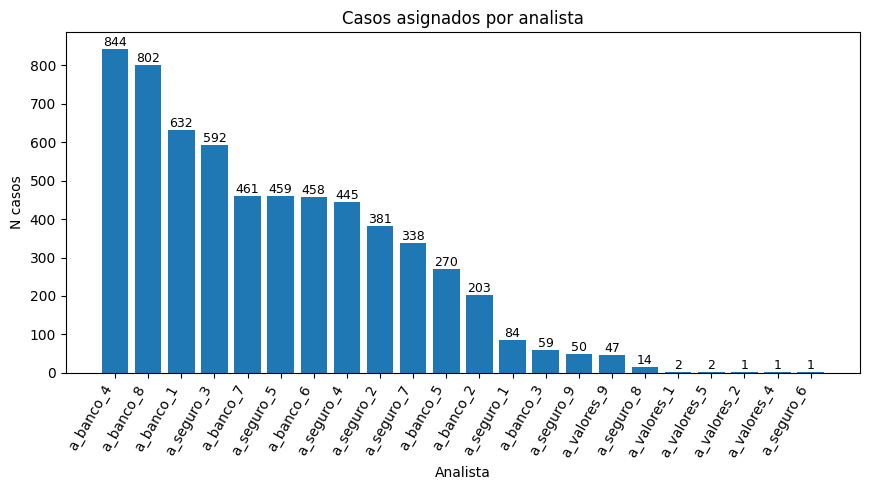

Figura guardada en: outputs/g2_score_promedio_por_analista.png


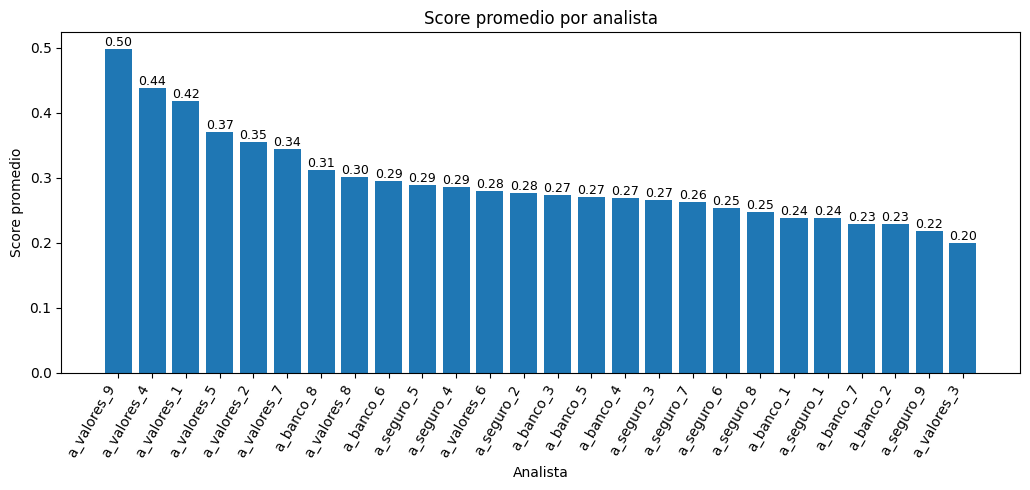

Figura guardada en: outputs/g3_carga_vs_score.png


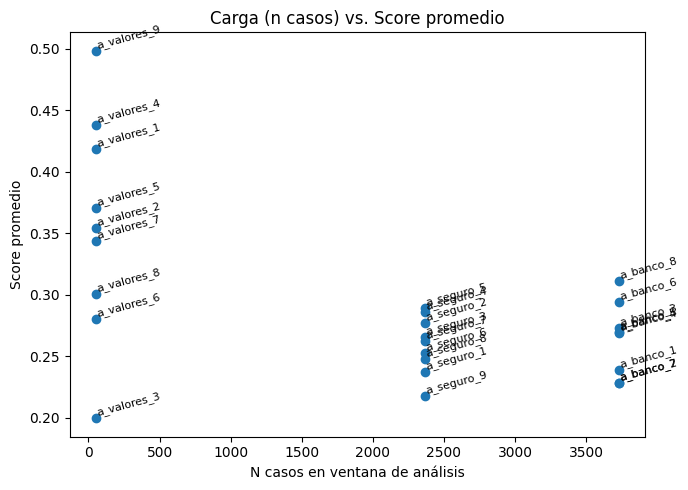

Figura guardada en: outputs/g4_box_score_mercado.png


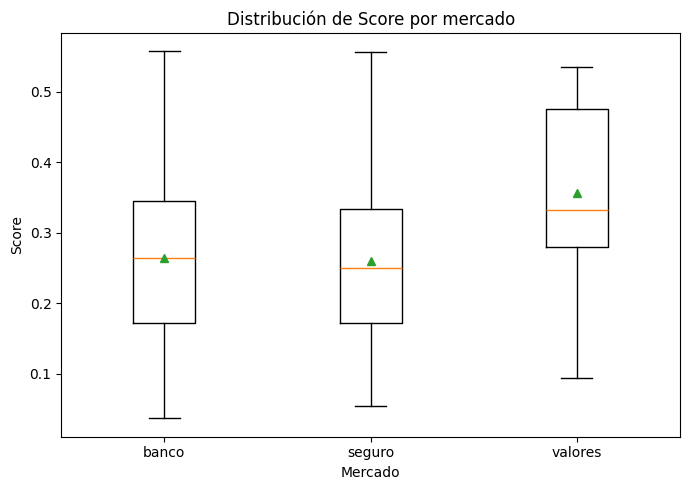

Figura guardada en: outputs/g5_mezcla_prioridad_por_analista.png


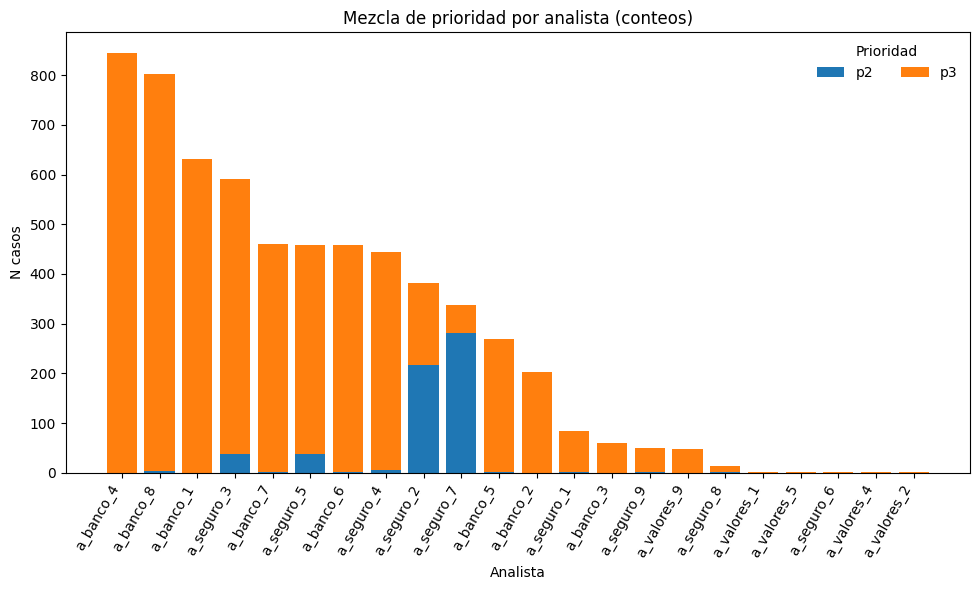

Figura guardada en: outputs/g6_tradeoff_skill_score.png


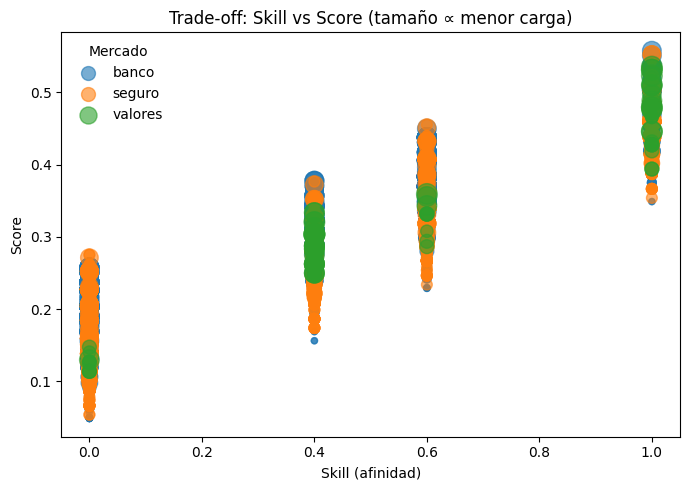


Top-10 analistas por número de casos:
 analista_id
a_banco_4     844
a_banco_8     802
a_banco_1     632
a_seguro_3    592
a_banco_7     461
a_seguro_5    459
a_banco_6     458
a_seguro_4    445
a_seguro_2    381
a_seguro_7    338
Name: count, dtype: int64

Top-10 analistas por score promedio:
 analista_id
a_valores_9    0.499
a_valores_4    0.438
a_valores_1    0.418
a_valores_5    0.371
a_valores_2    0.354
a_valores_7    0.344
a_banco_8      0.312
a_valores_8    0.301
a_banco_6      0.294
a_seguro_5     0.289
Name: Score, dtype: float64


In [ ]:
# ============================================================
# Gráficos para interpretar la asignación inteligente
# Lee los CSV generados y produce visualizaciones con matplotlib (sin seaborn)
# ============================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- 1) Carga robusta de datos ----------
def load_asignacion_paths():
    # Prioriza outputs/ del notebook; si no, usa los archivos subidos
    candidates = [
        ("outputs/asignacion_inteligente.csv", "outputs/asignacion_scores_detalle.csv"),
        ("/mnt/data/asignacion_inteligente.csv", "/mnt/data/asignacion_scores_detalle.csv"),
        ("asignacion_inteligente.csv", "asignacion_scores_detalle.csv"),
    ]
    for a,b in candidates:
        if os.path.exists(a) and os.path.exists(b):
            return a,b
    raise FileNotFoundError("No se encontraron los CSV de asignación. Verifica rutas.")

asign_path, detalle_path = load_asignacion_paths()
asign = pd.read_csv(asign_path)
detalle = pd.read_csv(detalle_path)

# normaliza strings
for c in ['analista_id','mercado','pred_producto','pred_materia','PRIORIDAD']:
    if c in asign.columns:
        asign[c] = asign[c].astype(str).str.lower()
    if c in detalle.columns:
        detalle[c] = detalle[c].astype(str).str.lower()

# ---------- 2) Funciones de gráficos (matplotlib puro) ----------
def save_or_show(fig, name=None):
    out = Path("outputs")
    out.mkdir(parents=True, exist_ok=True)
    if name:
        p = out / name
        fig.savefig(p, bbox_inches="tight", dpi=220)
        print(f"Figura guardada en: {p}")
    plt.show()

def plot_cases_per_analyst(df):
    cnt = df['analista_id'].value_counts().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(max(8, len(cnt)*0.4), 5))
    ax.bar(cnt.index, cnt.values)
    ax.set_title("Casos asignados por analista")
    ax.set_ylabel("N casos")
    ax.set_xlabel("Analista")
    ax.set_xticklabels(cnt.index, rotation=60, ha="right")
    for i,v in enumerate(cnt.values):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    save_or_show(fig, "g1_casos_por_analista.png")

def plot_avg_score_per_analyst(df):
    grp = df.groupby('analista_id')['Score'].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(max(8, len(grp)*0.4), 5))
    ax.bar(grp.index, grp.values)
    ax.set_title("Score promedio por analista")
    ax.set_ylabel("Score promedio")
    ax.set_xlabel("Analista")
    ax.set_xticklabels(grp.index, rotation=60, ha="right")
    for i,v in enumerate(grp.values):
        ax.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    save_or_show(fig, "g2_score_promedio_por_analista.png")

def plot_workload_vs_efficiency(df_det):
    # Para cada analista: carga estimada (n casos en detalle) vs score promedio
    summary = df_det.groupby('analista_id').agg(
        n=('CASO_ID','nunique'),
        score_mean=('Score','mean')
    ).reset_index()
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(summary['n'], summary['score_mean'])
    ax.set_title("Carga (n casos) vs. Score promedio")
    ax.set_xlabel("N casos en ventana de análisis")
    ax.set_ylabel("Score promedio")
    for _, r in summary.iterrows():
        ax.text(r['n'], r['score_mean'], r['analista_id'], fontsize=8, ha="left", va="bottom", rotation=15)
    fig.tight_layout()
    save_or_show(fig, "g3_carga_vs_score.png")

def plot_box_score_by_mercado(df_det):
    order = df_det['mercado'].value_counts().index.tolist()
    data = [df_det.loc[df_det['mercado']==m, 'Score'].values for m in order]
    fig, ax = plt.subplots(figsize=(7,5))
    ax.boxplot(data, labels=order, showmeans=True)
    ax.set_title("Distribución de Score por mercado")
    ax.set_ylabel("Score")
    ax.set_xlabel("Mercado")
    fig.tight_layout()
    save_or_show(fig, "g4_box_score_mercado.png")

def plot_priority_mix(df_asign):
    if 'PRIORIDAD' not in df_asign.columns:
        print("Columna PRIORIDAD no disponible en asignación final; se omite gráfico de mezcla de prioridad.")
        return
    # mezcla por analista (stacked)
    mix = (df_asign
           .groupby(['analista_id','PRIORIDAD'])['IC']
           .count()
           .unstack(fill_value=0))
    mix = mix.loc[mix.sum(axis=1).sort_values(ascending=False).index]
    totals = mix.sum(axis=1)
    fig, ax = plt.subplots(figsize=(max(8, len(mix)*0.45), 6))
    bottom = np.zeros(len(mix))
    for col in sorted(mix.columns):   # P1,P2,P3
        vals = mix[col].values
        ax.bar(mix.index, vals, bottom=bottom, label=col)
        bottom += vals
    ax.set_title("Mezcla de prioridad por analista (conteos)")
    ax.set_ylabel("N casos")
    ax.set_xlabel("Analista")
    ax.legend(title="Prioridad", ncol=3, frameon=False)
    ax.set_xticklabels(mix.index, rotation=60, ha="right")
    fig.tight_layout()
    save_or_show(fig, "g5_mezcla_prioridad_por_analista.png")

def plot_skill_pref_load_tradeoff(df_det):
    # Dispersión Skill vs Score, tamaño ~ (1-LoadN) y color por mercado (uso ciclo default)
    fig, ax = plt.subplots(figsize=(7,5))
    # Muestra sólo un muestreo si es muy grande
    dfp = df_det.copy()
    if len(dfp) > 10000:
        dfp = dfp.sample(10000, random_state=42)
    sizes = (1.0 - dfp['LoadN'].clip(0,1)) * 200 + 20
    for m in dfp['mercado'].dropna().unique():
        sub = dfp[dfp['mercado']==m]
        ax.scatter(sub['Skill'], sub['Score'], s=sizes.loc[sub.index], alpha=0.6, label=str(m))
    ax.set_title("Trade-off: Skill vs Score (tamaño ∝ menor carga)")
    ax.set_xlabel("Skill (afinidad)")
    ax.set_ylabel("Score")
    ax.legend(title="Mercado", frameon=False)
    fig.tight_layout()
    save_or_show(fig, "g6_tradeoff_skill_score.png")

# ---------- 3) Ejecutar gráficos ----------
plot_cases_per_analyst(asign)             # G1: distribución de asignaciones
plot_avg_score_per_analyst(detalle)       # G2: score promedio por analista
plot_workload_vs_efficiency(detalle)      # G3: carga vs score promedio
plot_box_score_by_mercado(detalle)        # G4: boxplot de score por mercado
plot_priority_mix(asign)                  # G5: mezcla de prioridades por analista (si está PRIORIDAD)
plot_skill_pref_load_tradeoff(detalle)    # G6: trade-off skill vs score

# ---------- 4) Tablas de apoyo (opcional, para interpretar) ----------
top10_count = asign['analista_id'].value_counts().head(10)
top10_score = detalle.groupby('analista_id')['Score'].mean().sort_values(ascending=False).head(10)
print("\nTop-10 analistas por número de casos:\n", top10_count)
print("\nTop-10 analistas por score promedio:\n", top10_score.round(3))
